<a href="https://colab.research.google.com/github/oeldaghar/mnist-testing/blob/main/MNIST_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

import tensorflow as tf
# #for producing explanations
# from tensorflow_addons.explainers import XRAI


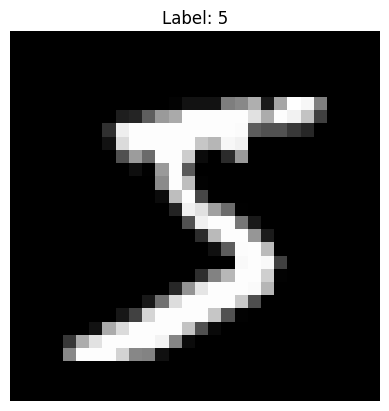

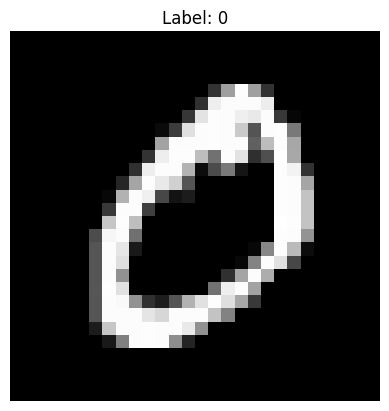

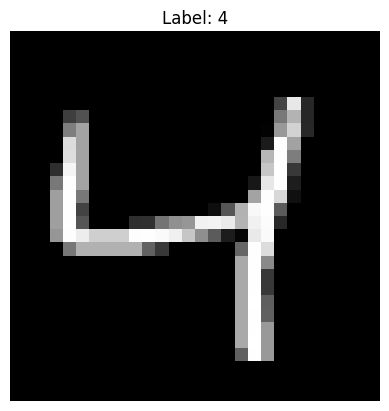

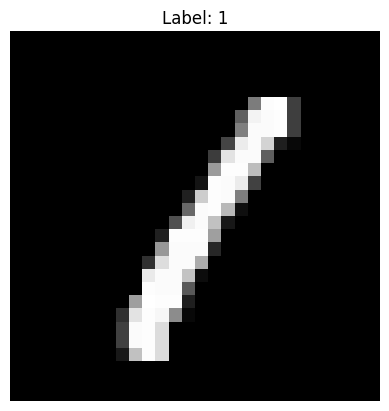

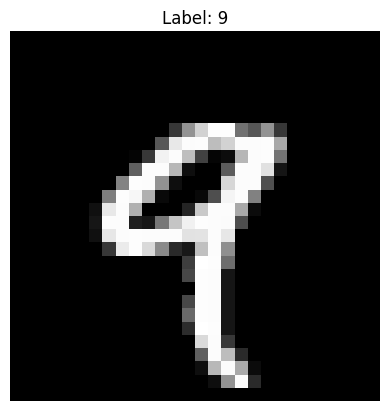

In [41]:
# Load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Display some images
for i in range(5):
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
    plt.show()

In [42]:
# Reshape data to fit model
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Normalize pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert labels to categorical one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define a simple CNN model using the Functional API
inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', name='conv2d')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 39s 20ms/step - accuracy: 0.9080 - loss: 0.3075 - val_accuracy: 0.9745 - val_loss: 0.0784
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.9838 - loss: 0.0542 - val_accuracy: 0.9853 - val_loss: 0.0434
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9904 - loss: 0.0306 - val_accuracy: 0.9842 - val_loss: 0.0506
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9813 - loss: 0.0612
Test accuracy: 0.9842000007629395
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


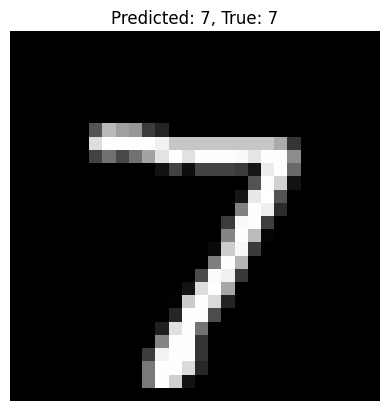

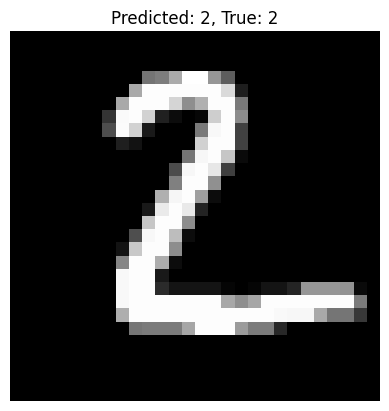

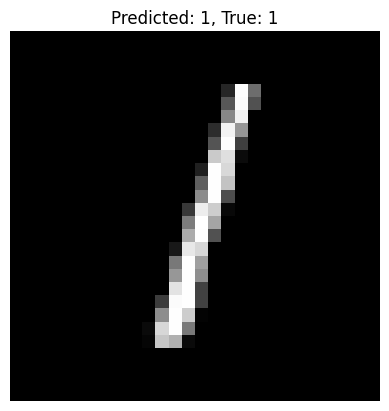

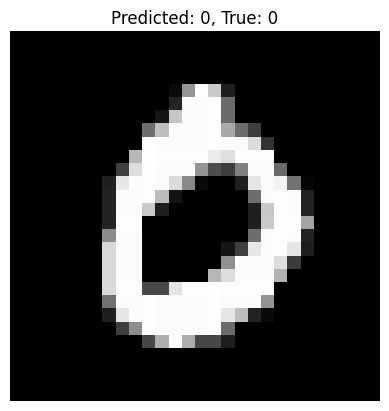

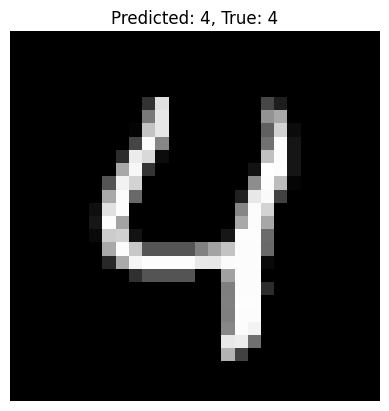

In [43]:
# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(X_test)

# Display some predictions
for i in range(5):
    plt.imshow(X_test[i].reshape(28,28), cmap='gray')
    plt.title(f'Predicted: {np.argmax(predictions[i])}, True: {np.argmax(y_test[i])}')
    plt.axis('off')
    plt.show()


In [44]:
model.layers

[<InputLayer name=input_layer_1, built=True>,
 <Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Flatten name=flatten_1, built=True>,
 <Dense name=dense_2, built=True>,
 <Dense name=dense_3, built=True>]

In [51]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ tf.expand_dims(pooled_grads, -1)
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

In [60]:
model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


array([[2.8889795e-07, 8.1865338e-08, 1.2062312e-05, ..., 9.9997085e-01,
        1.0713427e-06, 2.6268947e-06],
       [7.0864530e-07, 8.5560583e-05, 9.9991363e-01, ..., 1.0342462e-09,
        2.7861461e-08, 3.6016812e-10],
       [7.0702872e-06, 9.9919742e-01, 2.7814107e-05, ..., 5.3828553e-04,
        1.4919437e-04, 3.6629112e-07],
       ...,
       [2.1521306e-11, 3.9397436e-09, 2.1653830e-09, ..., 2.5750734e-07,
        2.3938624e-06, 9.0286831e-06],
       [5.4912959e-09, 2.2152483e-11, 6.2615178e-12, ..., 3.2274045e-08,
        6.6654517e-05, 5.1340554e-09],
       [6.3751131e-08, 9.3675254e-09, 1.6985797e-07, ..., 4.6833737e-10,
        3.2965090e-07, 2.5055067e-09]], dtype=float32)

In [101]:
#find instance where wrong
preds = [np.argmax(x) for x in predictions]
trues = [np.argmax(x) for x in y_test]
error_inds = [i for i in range(len(preds)) if preds[i]!=trues[i]]

predicted value: 8
true value: 3


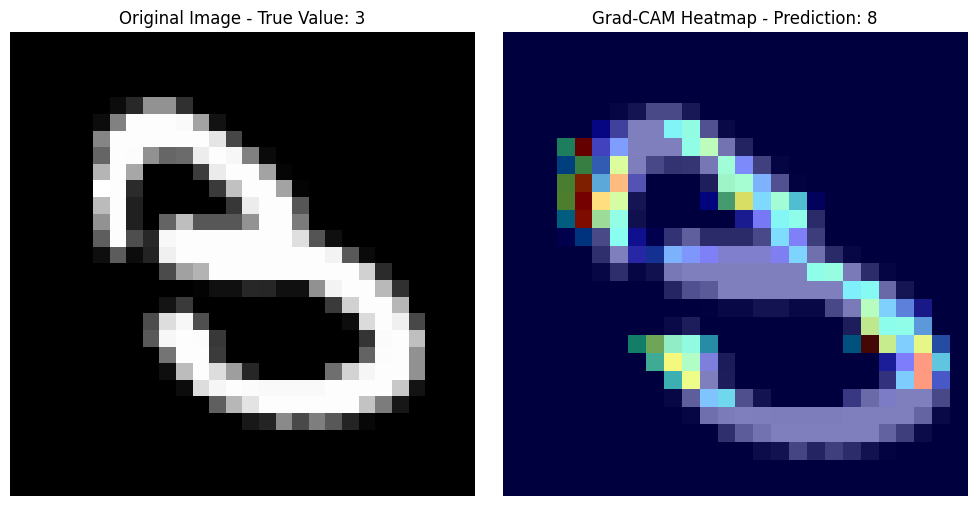

In [107]:
img_ind = error_inds[0]
img_to_explain = X_test[img_ind]

print(f"predicted value: {preds[img_ind]}")
print(f"true value: {trues[img_ind]}")

def explain_image(img_to_explain,model,last_conv_layer_name):
  # Choose an image from the test set
  img_array = np.expand_dims(img_to_explain, axis=0)

  # Generate Grad-CAM heatmap
  heatmap = make_gradcam_heatmap(img_array, model, 'conv2d')

  # Display the image and overlay it with the heatmap
  f = plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(img_to_explain.reshape(28, 28), cmap='gray')
  plt.title(f'Original Image - True Value: {trues[img_ind]}')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(img_to_explain.reshape(28, 28), cmap='gray')
  plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap with transparency
  plt.title(f'Grad-CAM Heatmap - Prediction: {preds[img_ind]}')
  plt.axis('off')

  plt.tight_layout()
  return f

f = explain_image(img_to_explain,model,'conv2d')

plt.show(f)

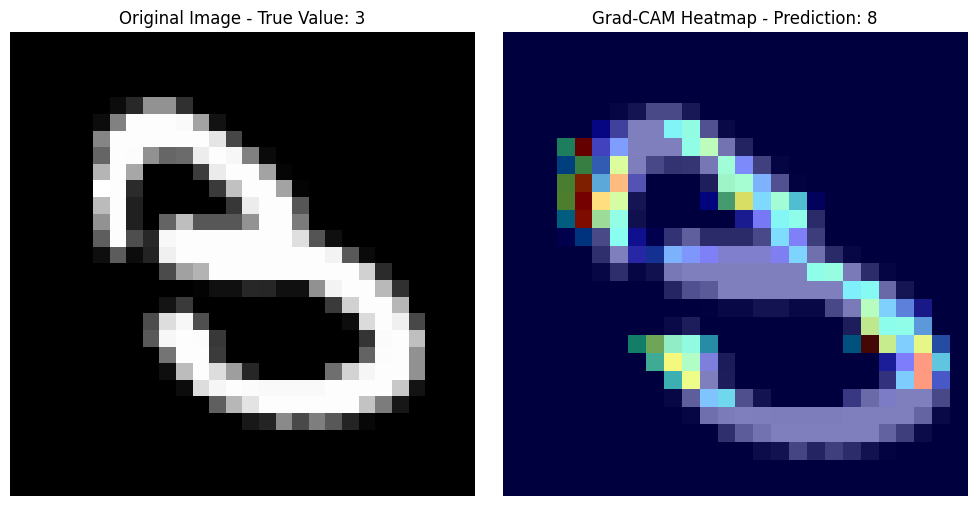

<Figure size 640x480 with 0 Axes>

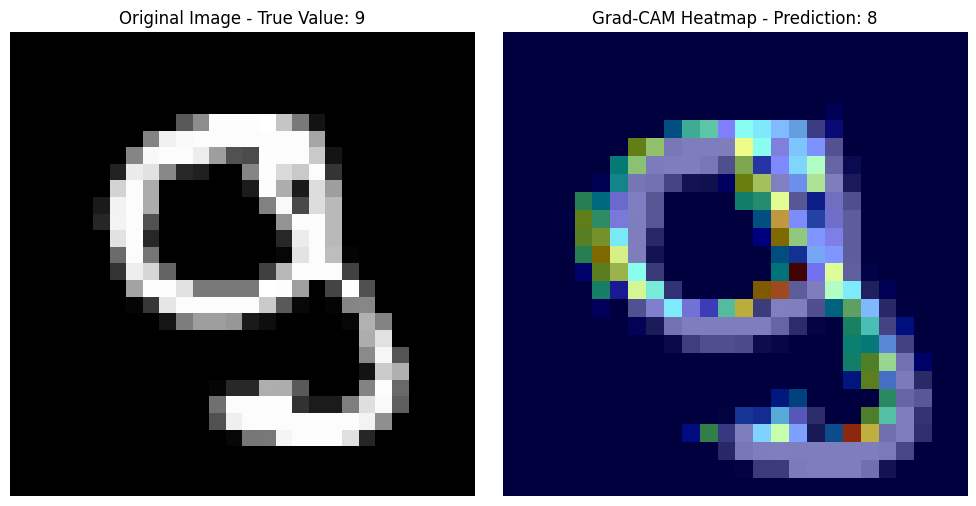

<Figure size 640x480 with 0 Axes>

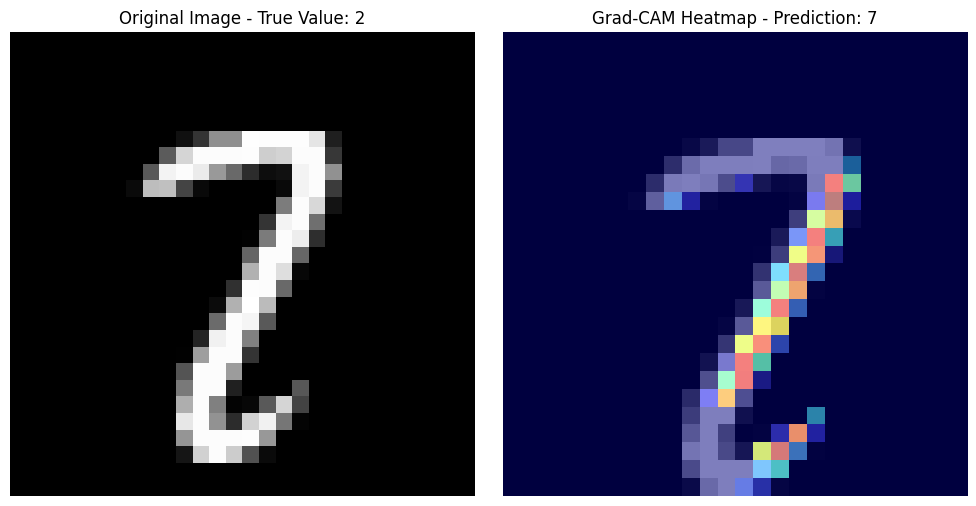

<Figure size 640x480 with 0 Axes>

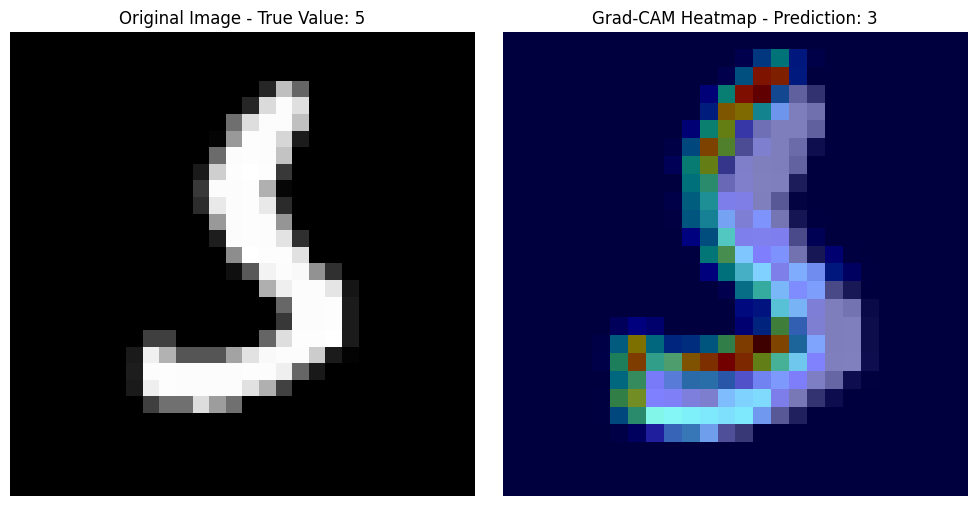

<Figure size 640x480 with 0 Axes>

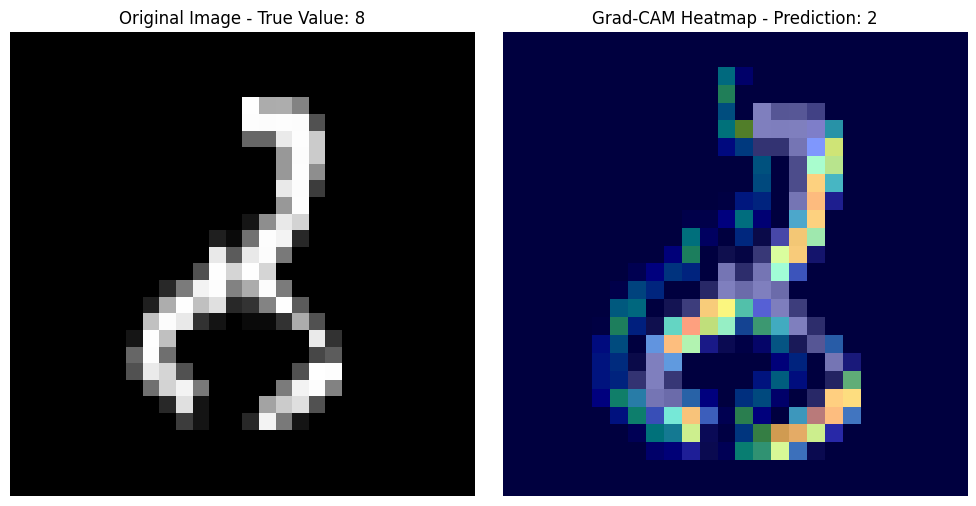

<Figure size 640x480 with 0 Axes>

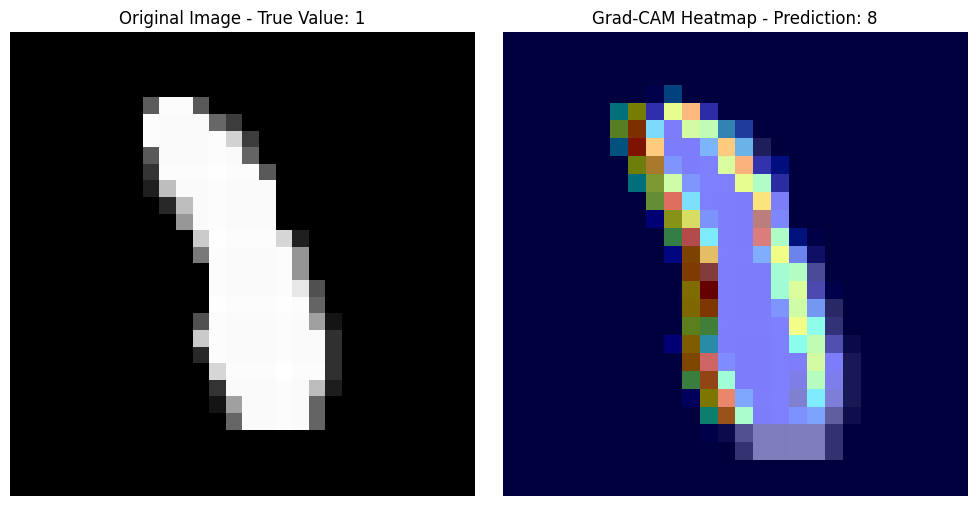

<Figure size 640x480 with 0 Axes>

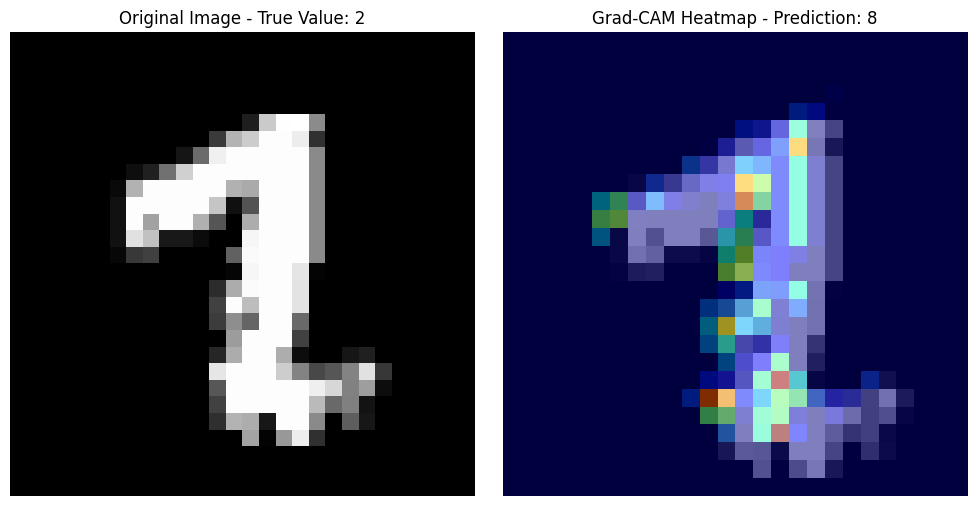

<Figure size 640x480 with 0 Axes>

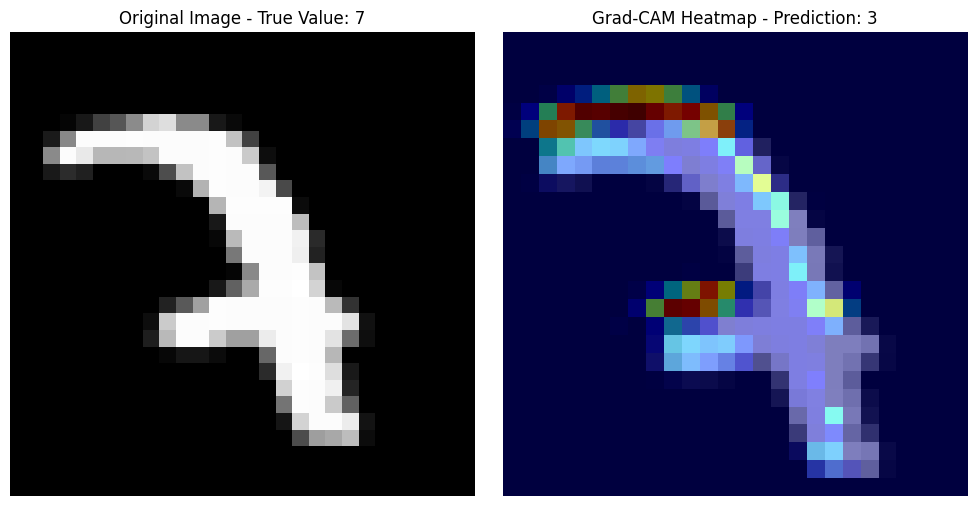

<Figure size 640x480 with 0 Axes>

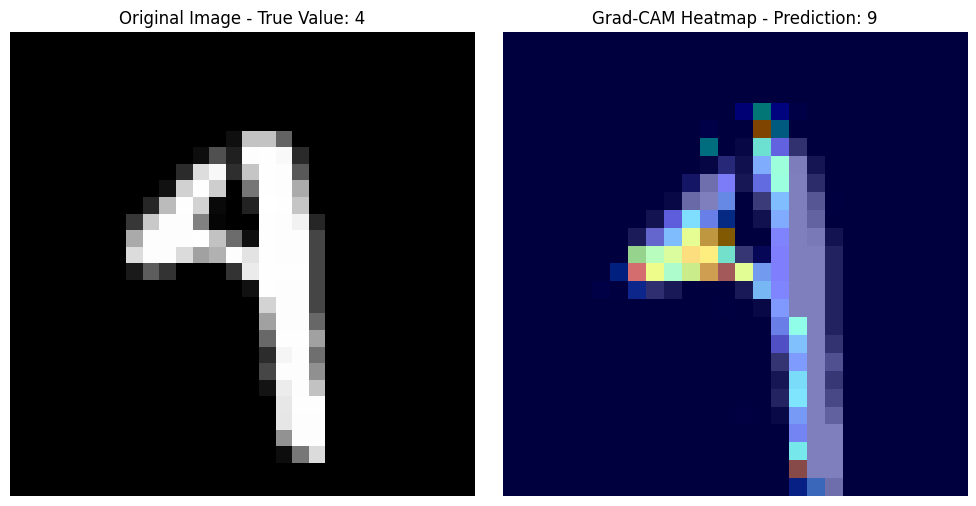

<Figure size 640x480 with 0 Axes>

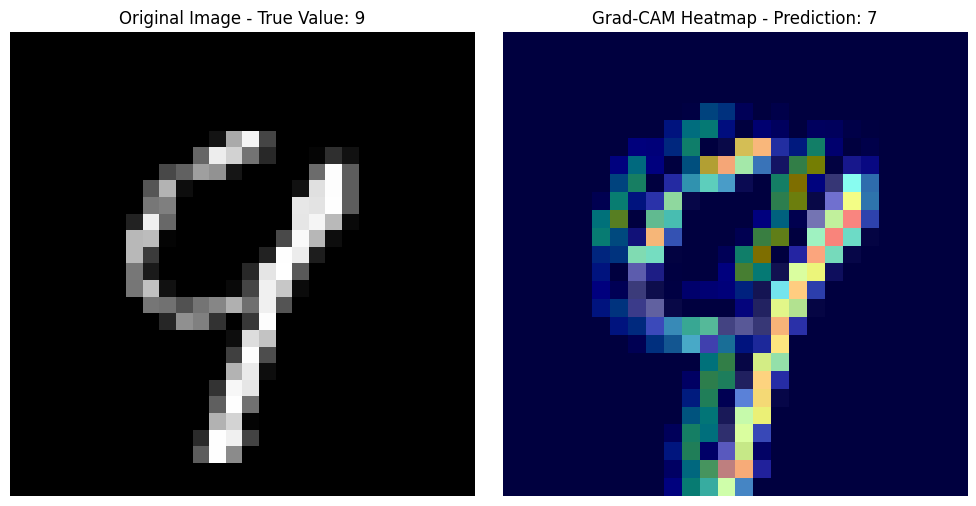

<Figure size 640x480 with 0 Axes>

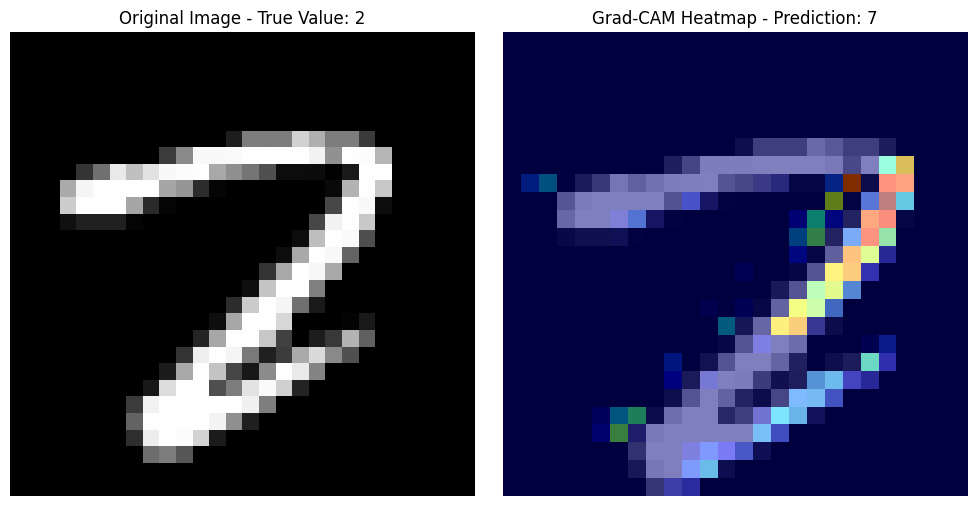

<Figure size 640x480 with 0 Axes>

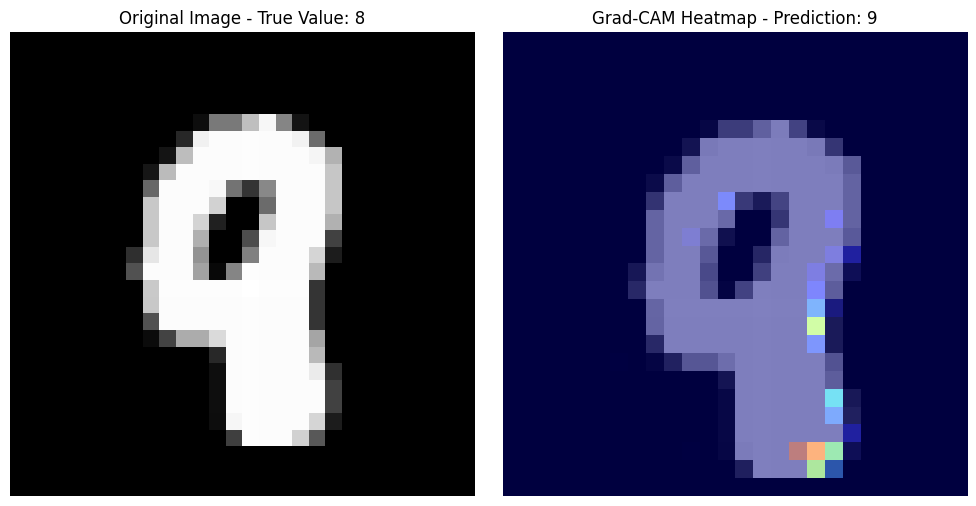

<Figure size 640x480 with 0 Axes>

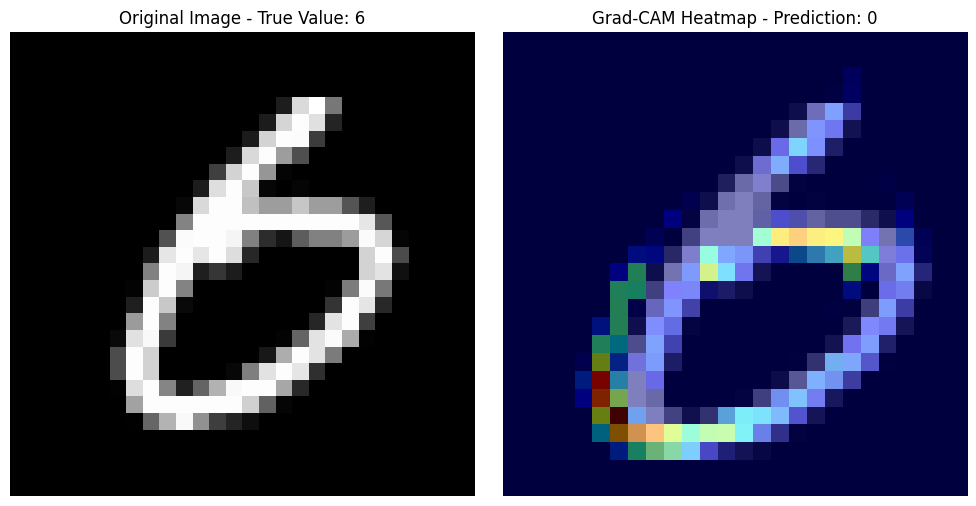

<Figure size 640x480 with 0 Axes>

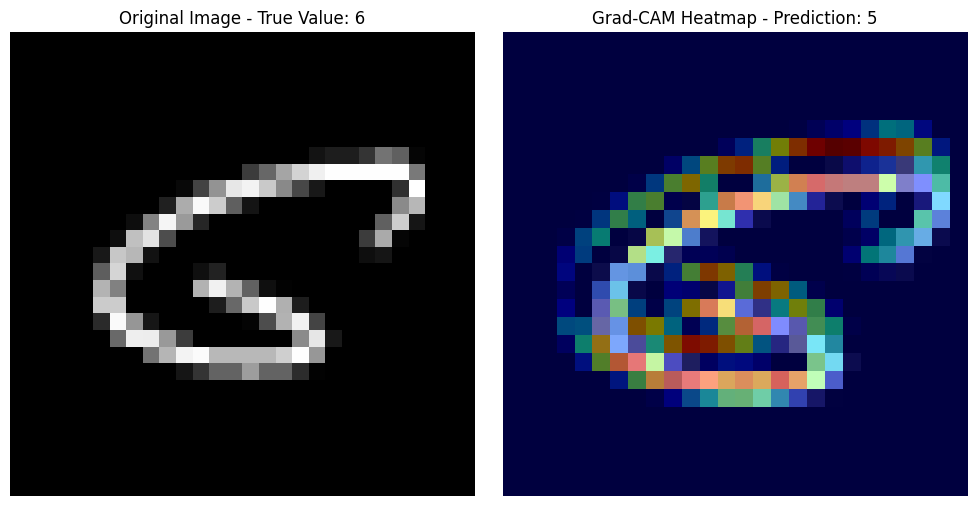

<Figure size 640x480 with 0 Axes>

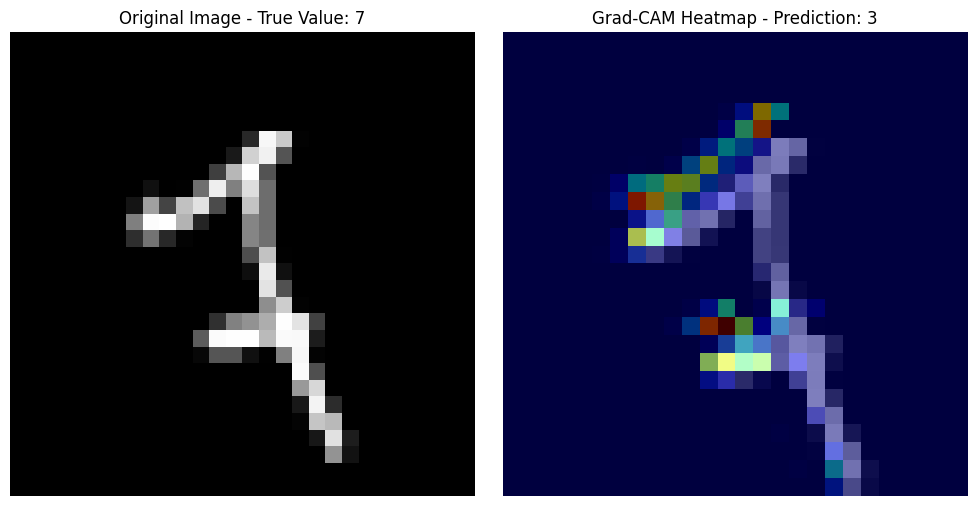

<Figure size 640x480 with 0 Axes>

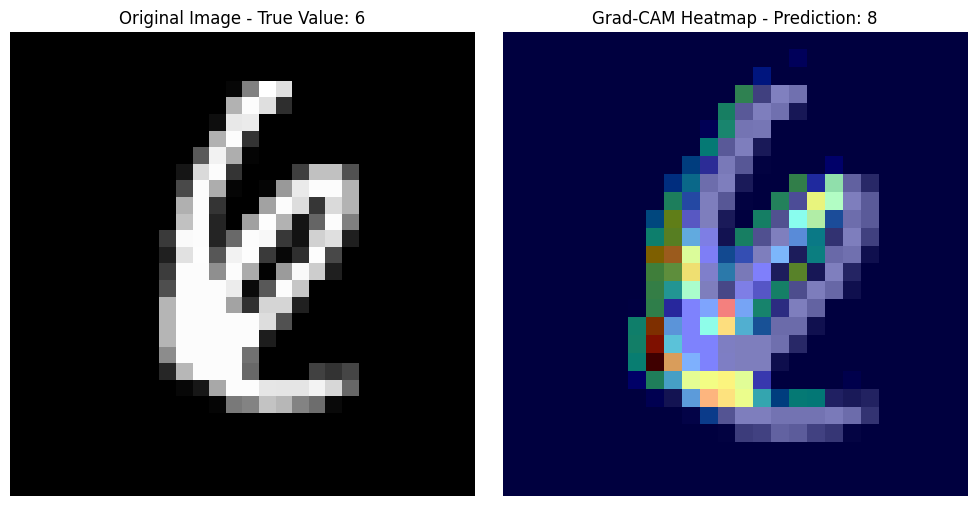

<Figure size 640x480 with 0 Axes>

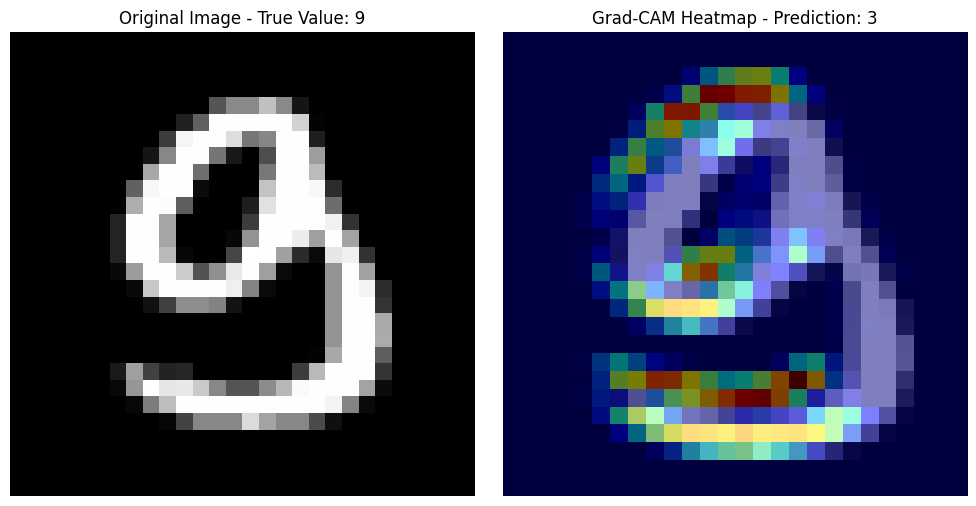

<Figure size 640x480 with 0 Axes>

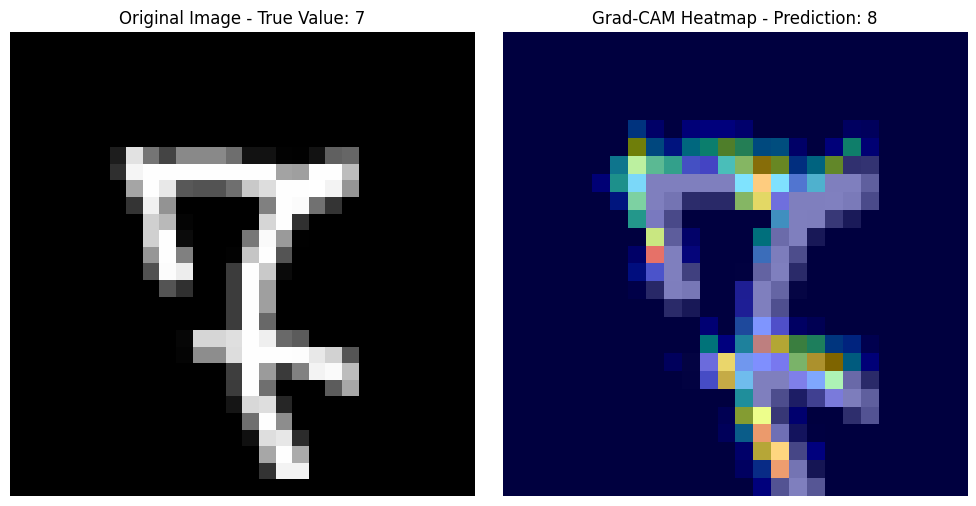

<Figure size 640x480 with 0 Axes>

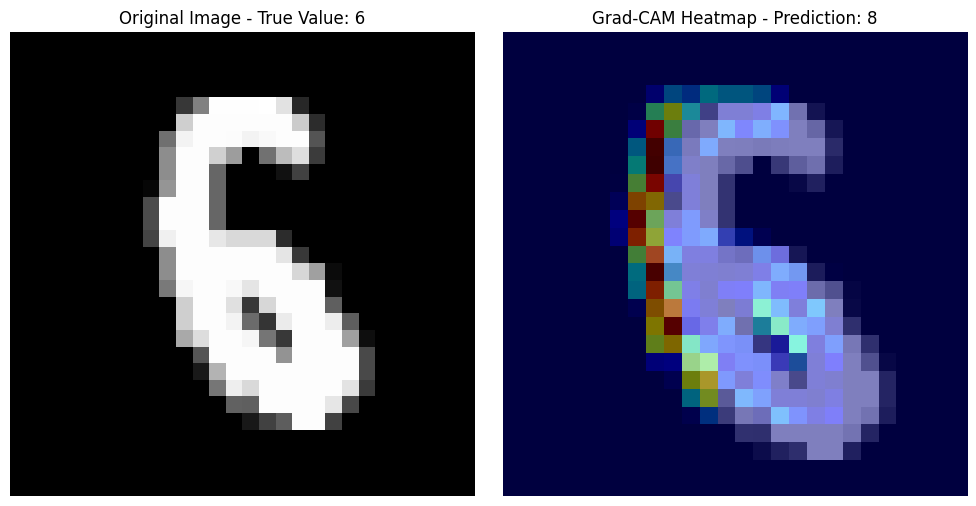

<Figure size 640x480 with 0 Axes>

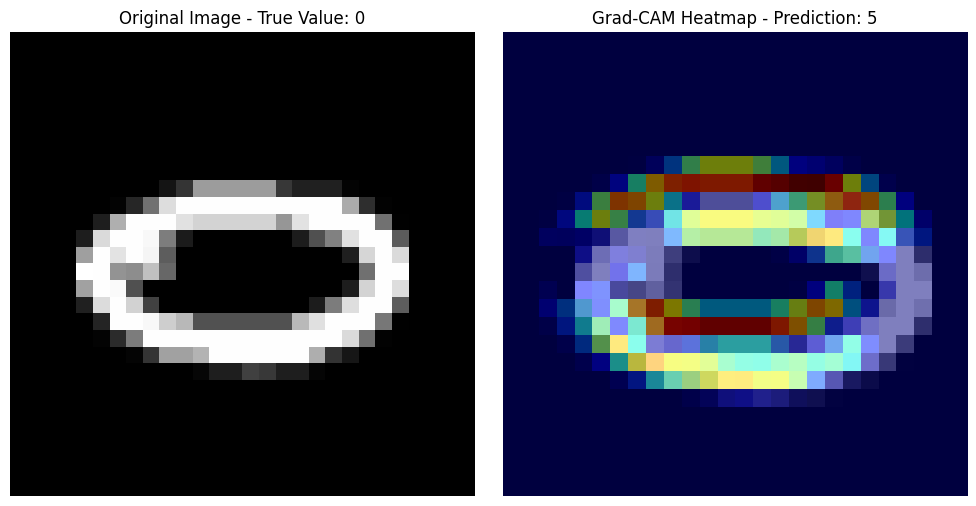

<Figure size 640x480 with 0 Axes>

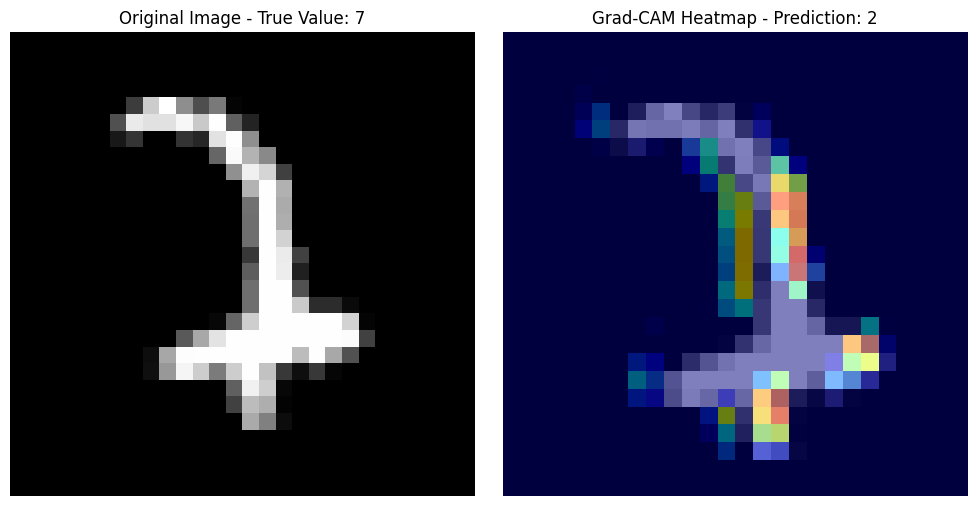

<Figure size 640x480 with 0 Axes>

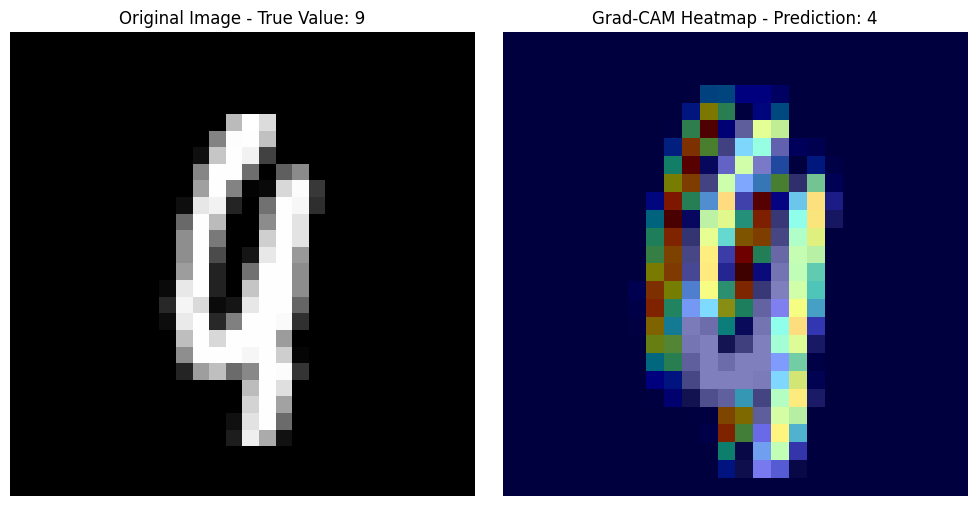

<Figure size 640x480 with 0 Axes>

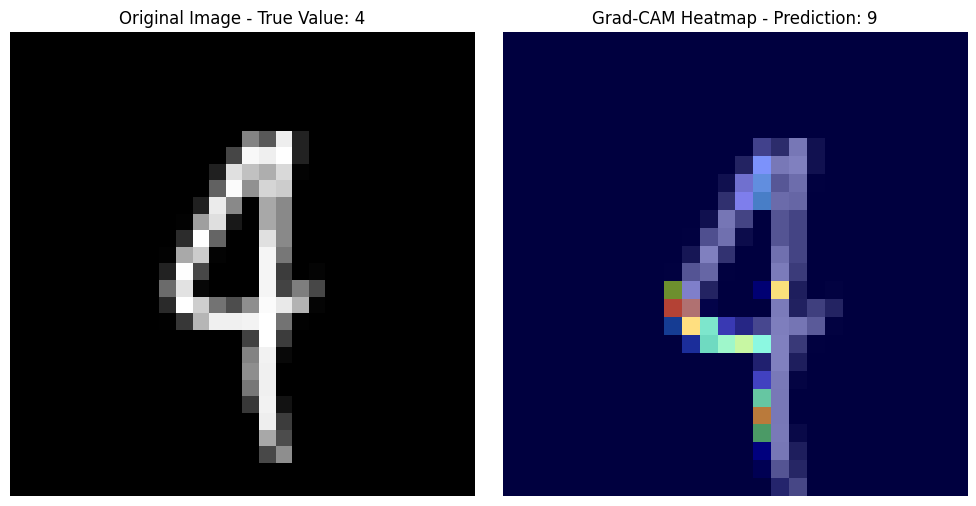

<Figure size 640x480 with 0 Axes>

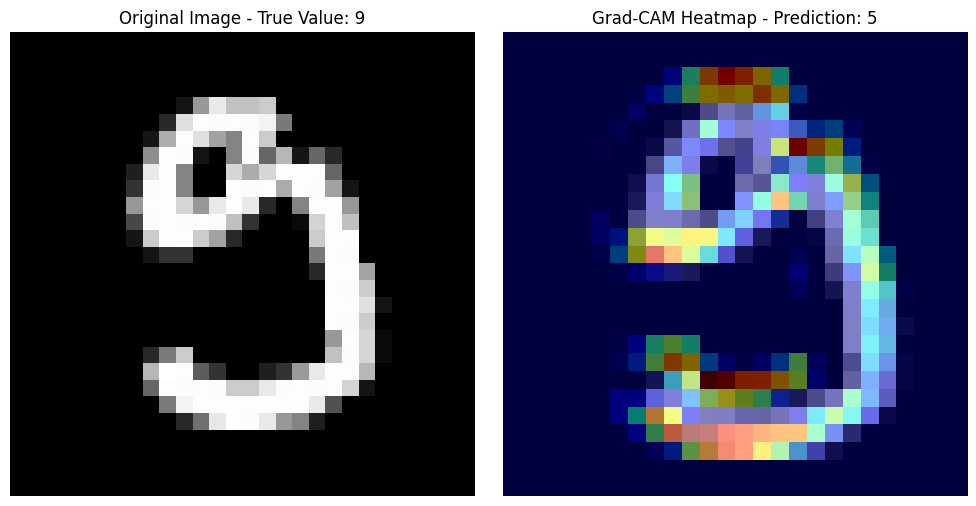

<Figure size 640x480 with 0 Axes>

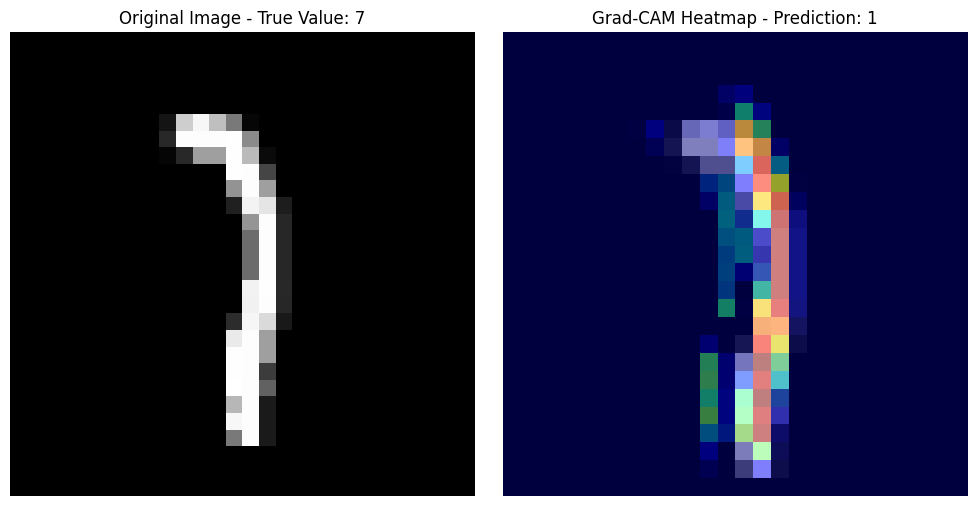

<Figure size 640x480 with 0 Axes>

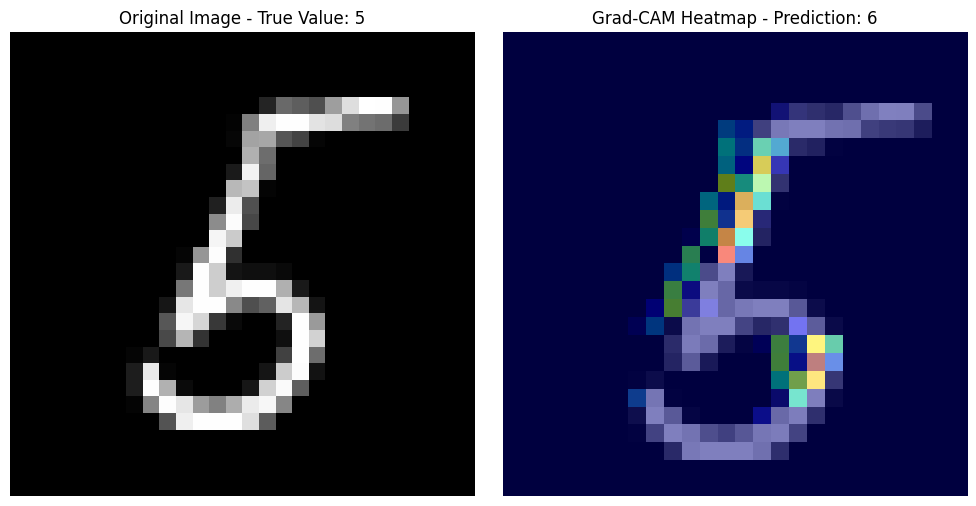

<Figure size 640x480 with 0 Axes>

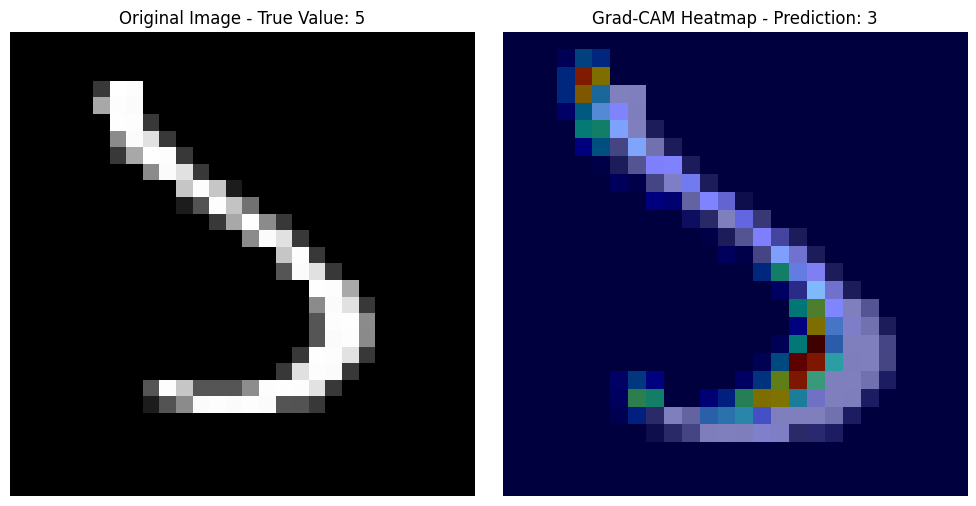

<Figure size 640x480 with 0 Axes>

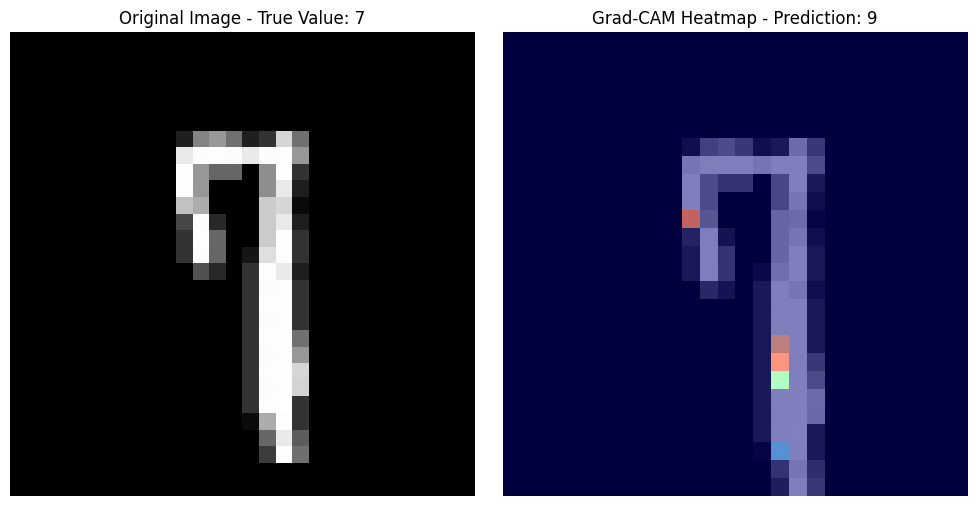

<Figure size 640x480 with 0 Axes>

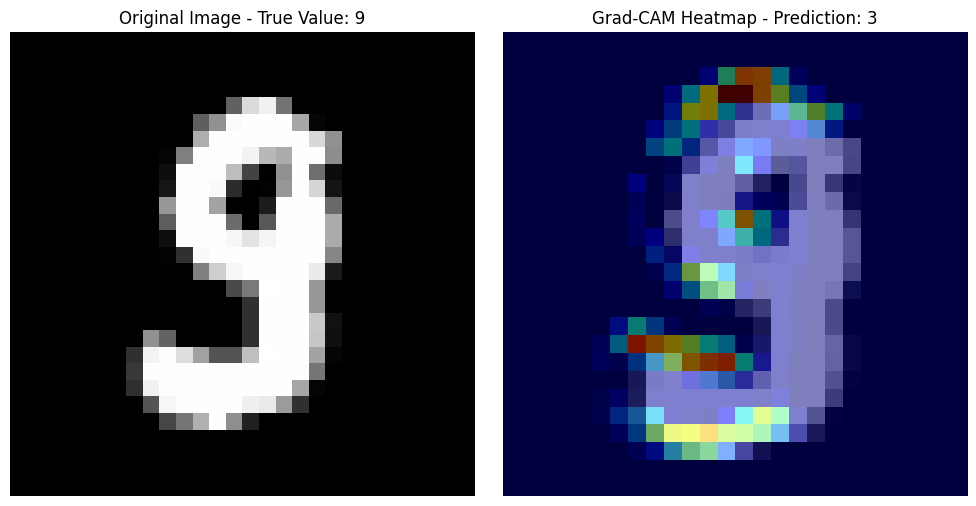

<Figure size 640x480 with 0 Axes>

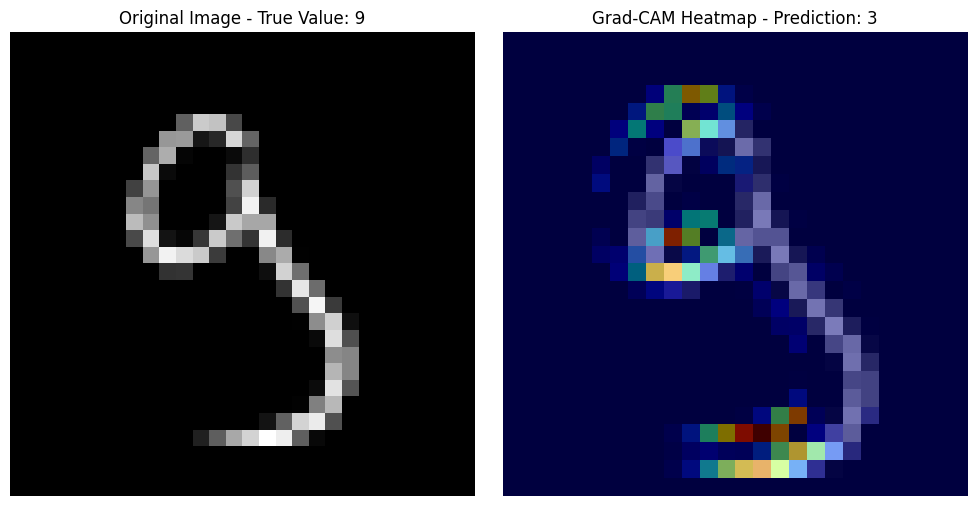

<Figure size 640x480 with 0 Axes>

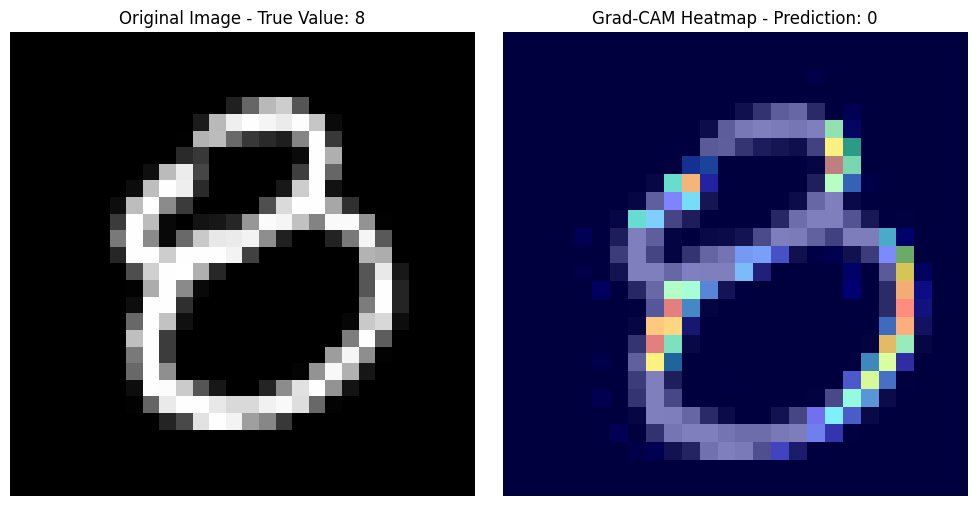

<Figure size 640x480 with 0 Axes>

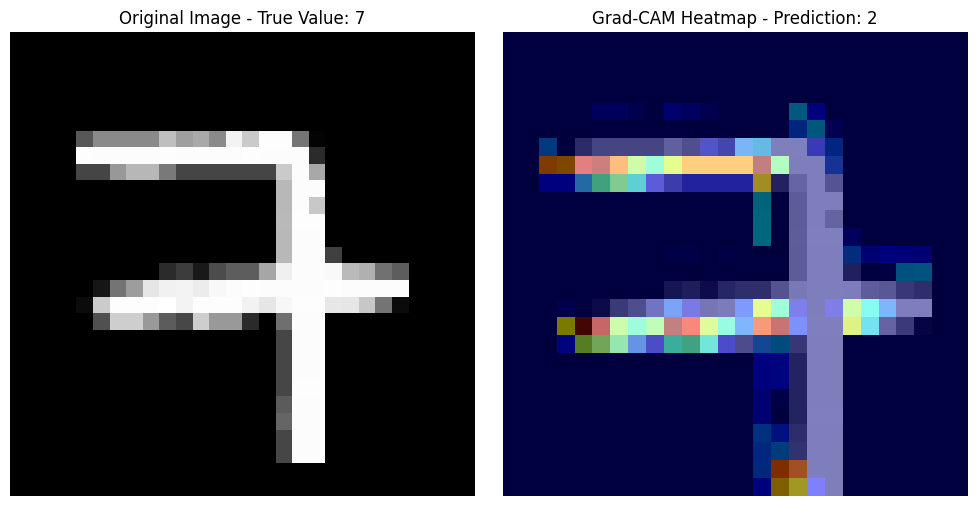

<Figure size 640x480 with 0 Axes>

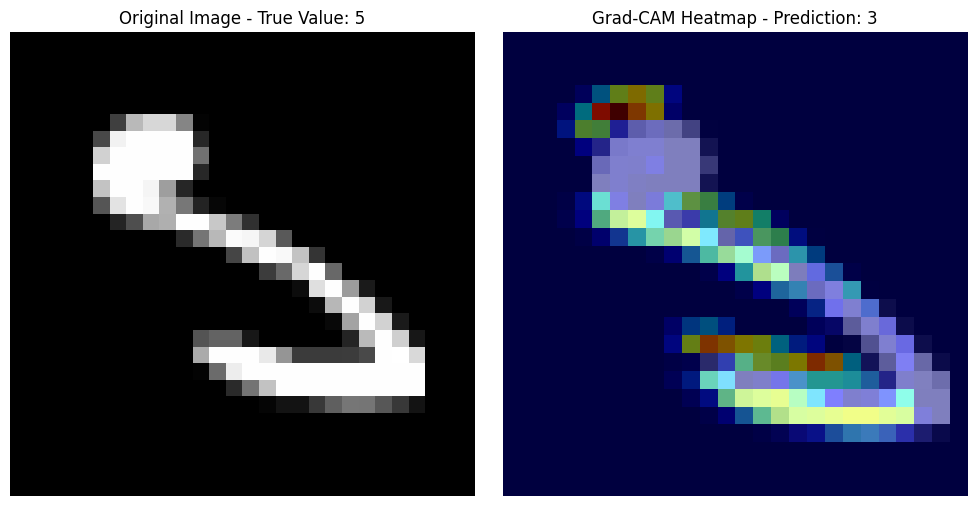

<Figure size 640x480 with 0 Axes>

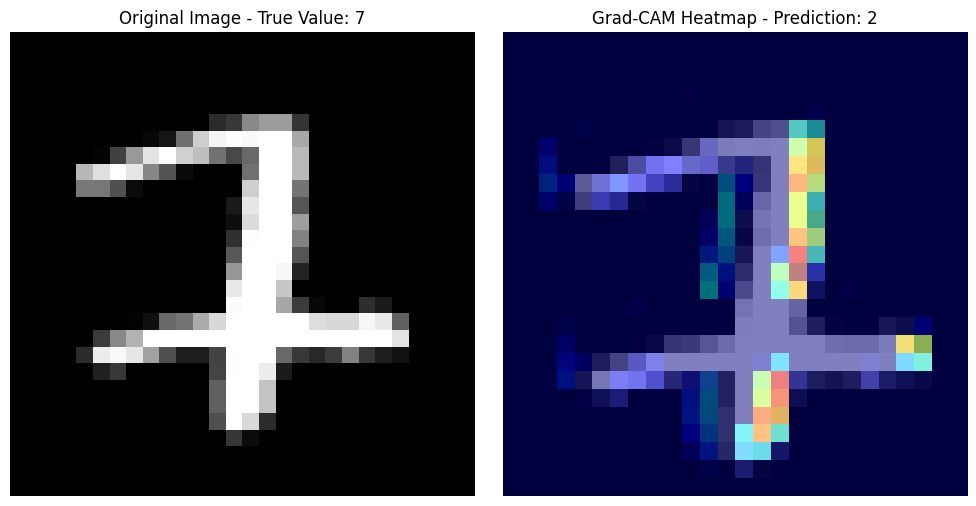

<Figure size 640x480 with 0 Axes>

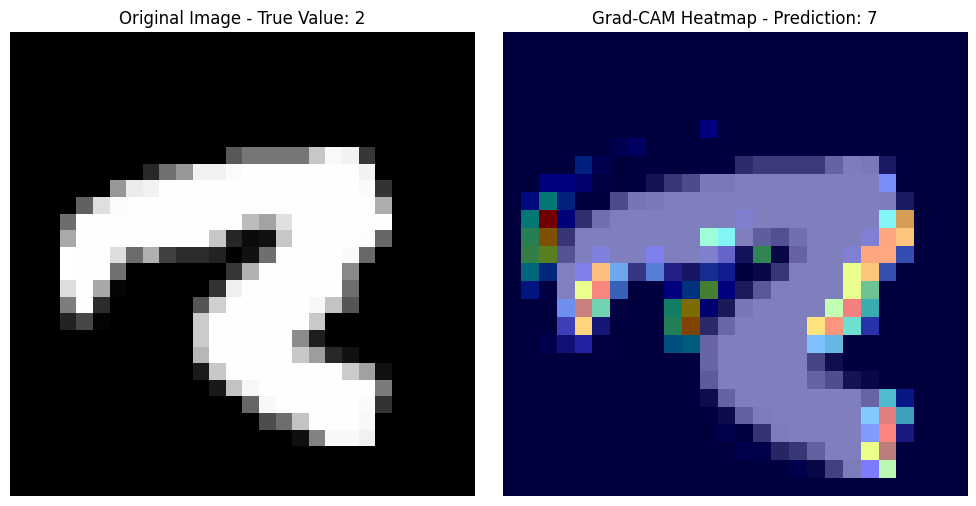

<Figure size 640x480 with 0 Axes>

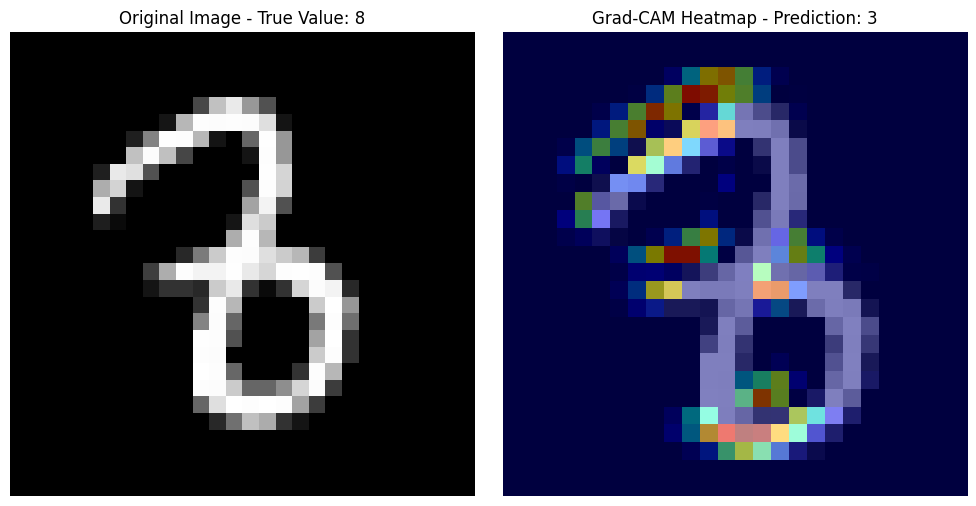

<Figure size 640x480 with 0 Axes>

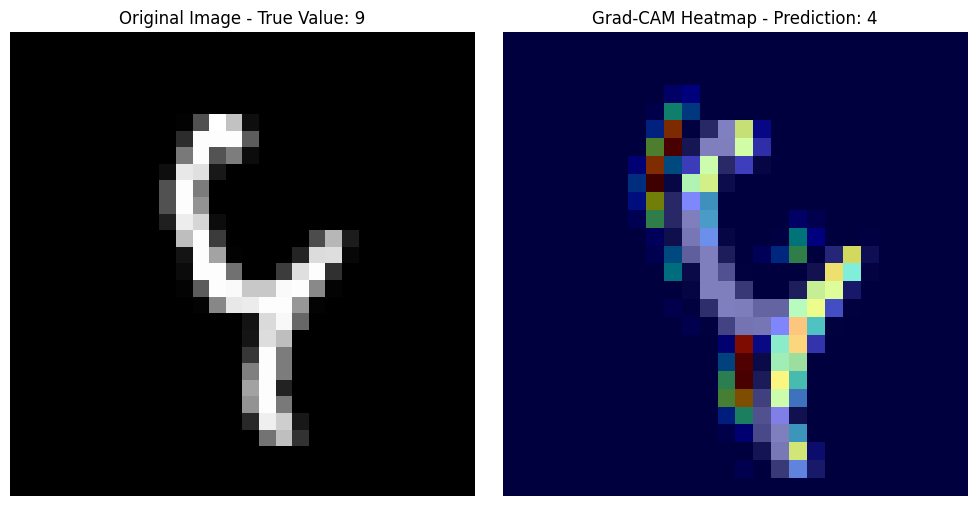

<Figure size 640x480 with 0 Axes>

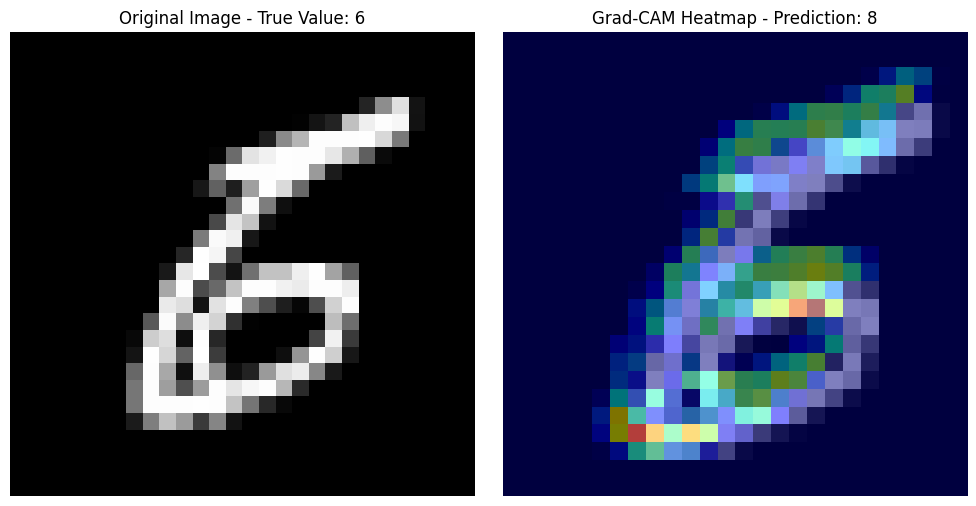

<Figure size 640x480 with 0 Axes>

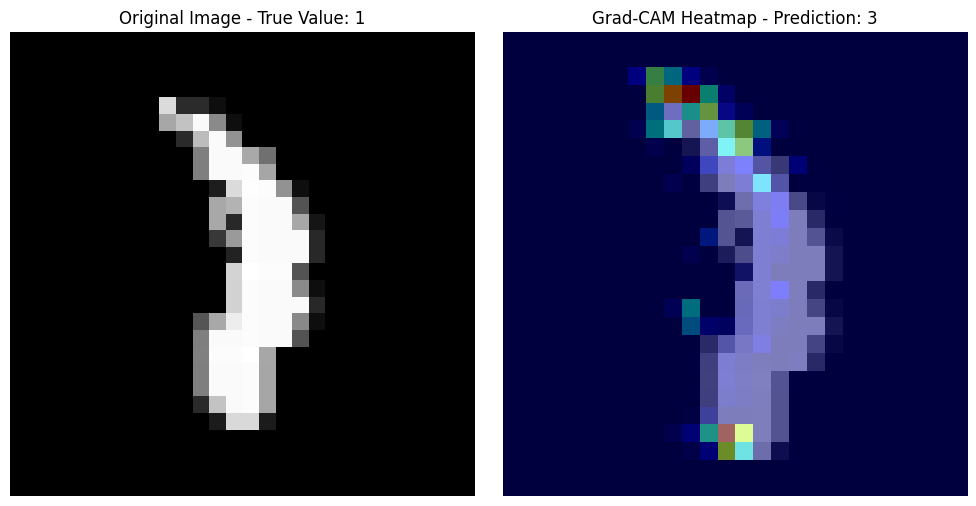

<Figure size 640x480 with 0 Axes>

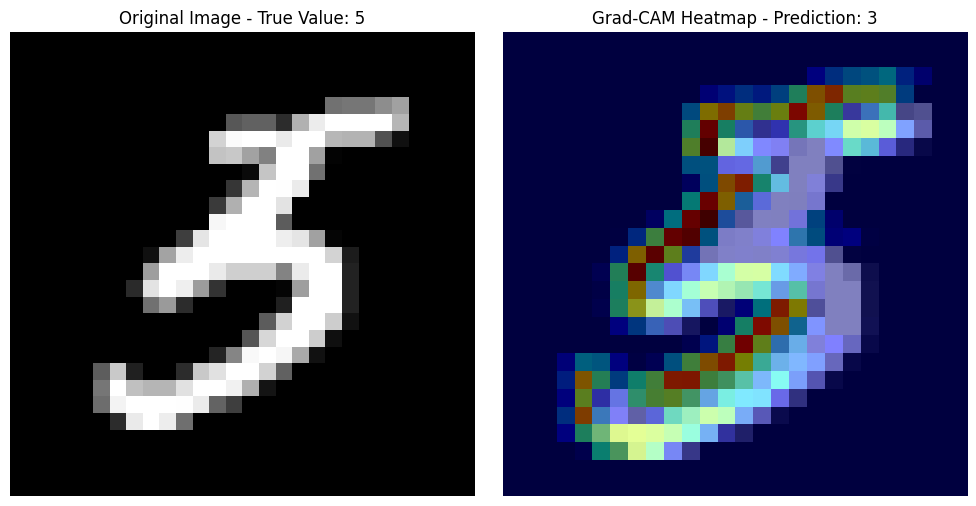

<Figure size 640x480 with 0 Axes>

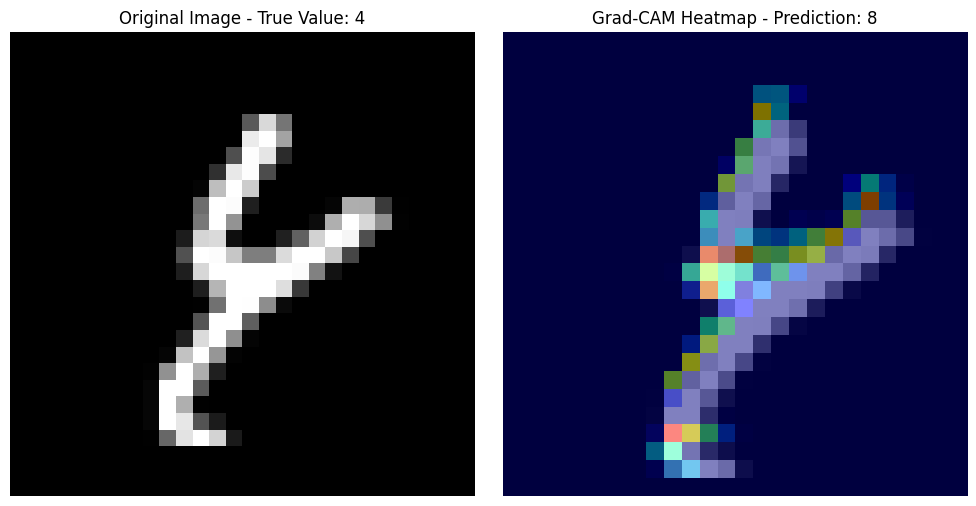

<Figure size 640x480 with 0 Axes>

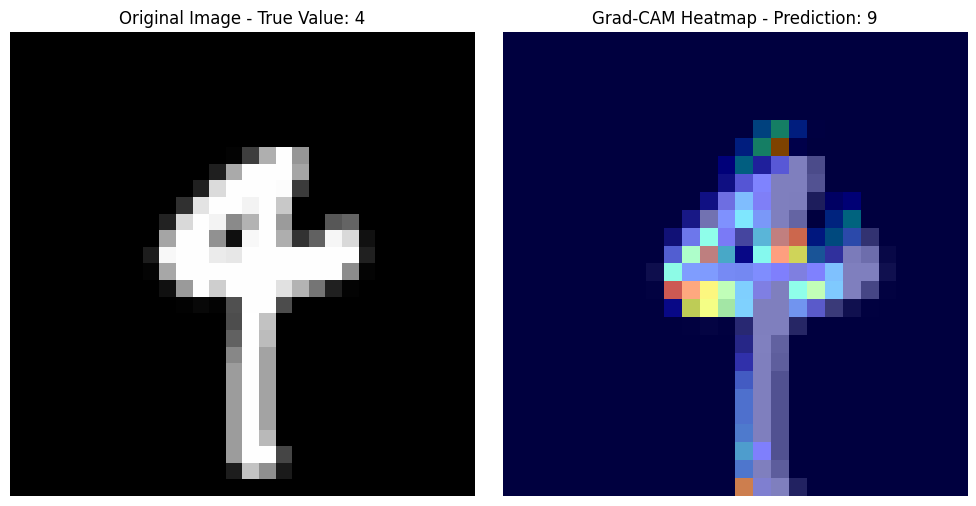

<Figure size 640x480 with 0 Axes>

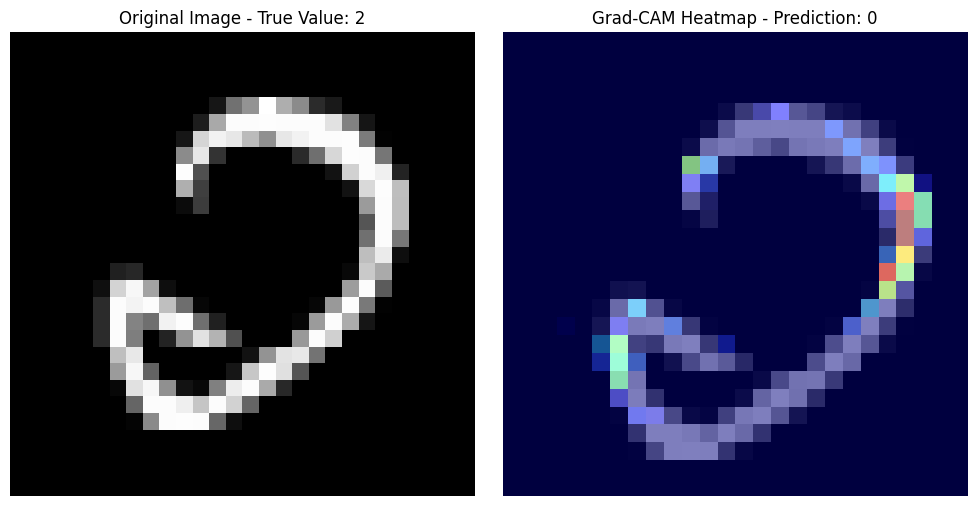

<Figure size 640x480 with 0 Axes>

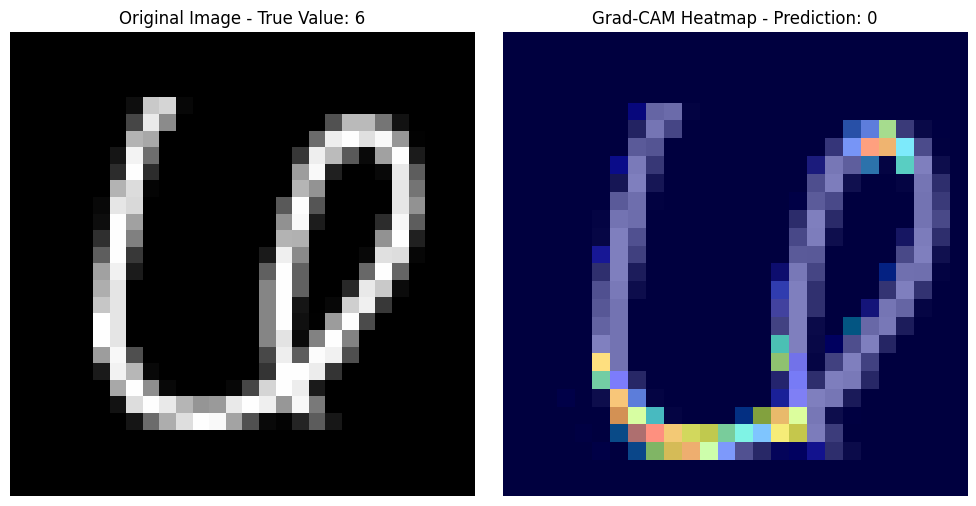

<Figure size 640x480 with 0 Axes>

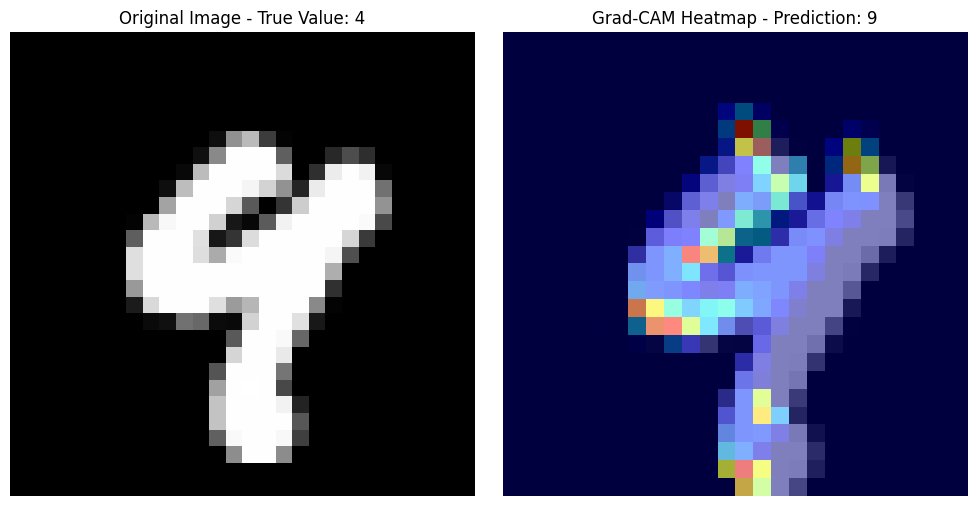

<Figure size 640x480 with 0 Axes>

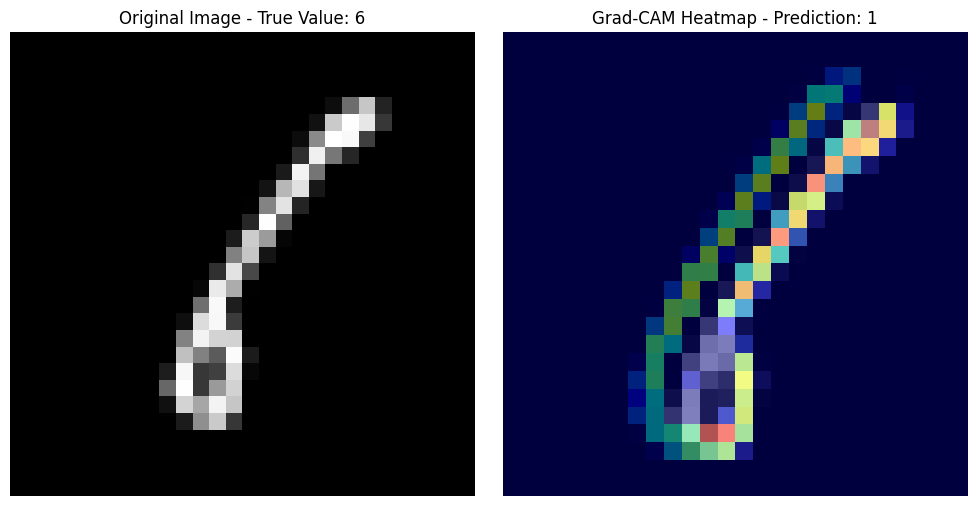

<Figure size 640x480 with 0 Axes>

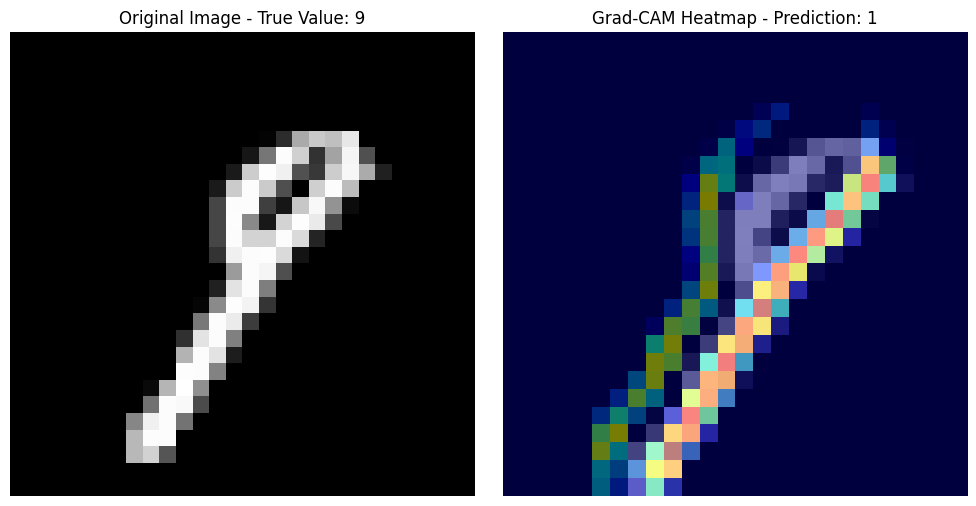

<Figure size 640x480 with 0 Axes>

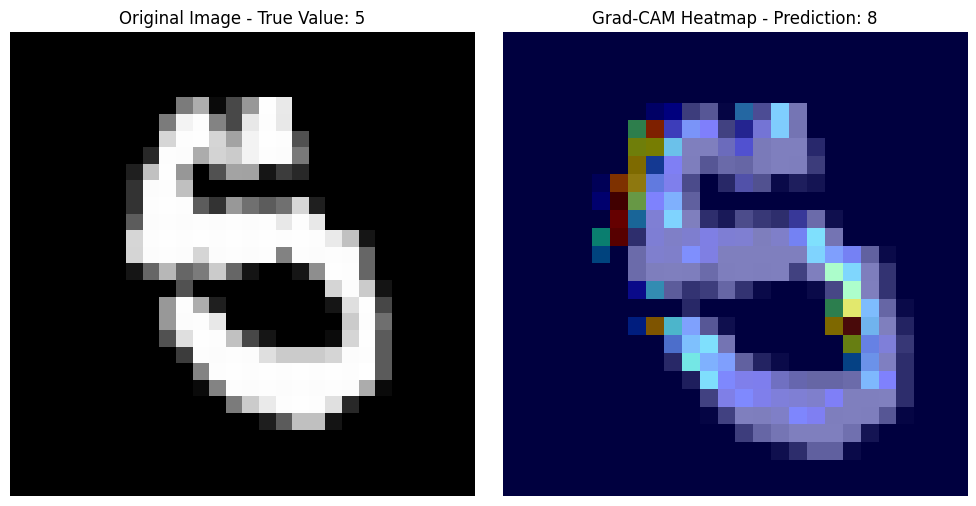

<Figure size 640x480 with 0 Axes>

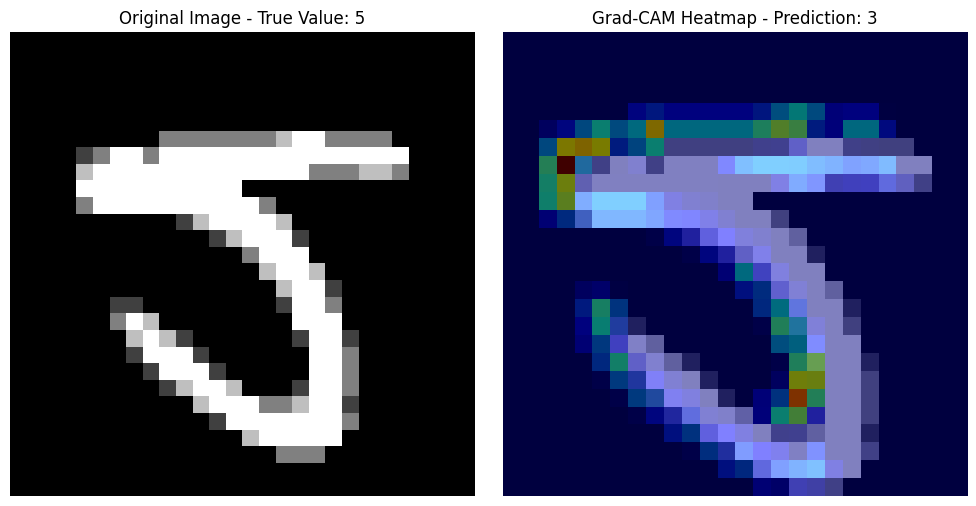

<Figure size 640x480 with 0 Axes>

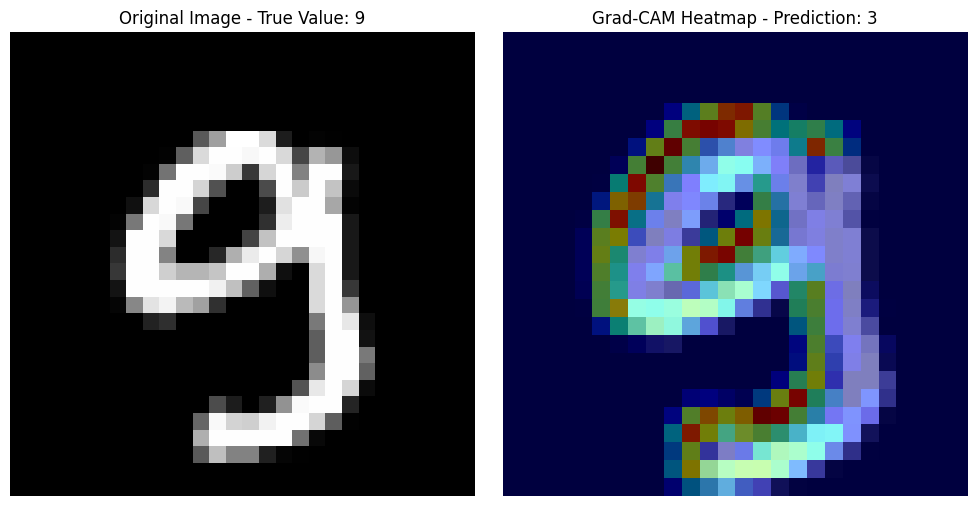

<Figure size 640x480 with 0 Axes>

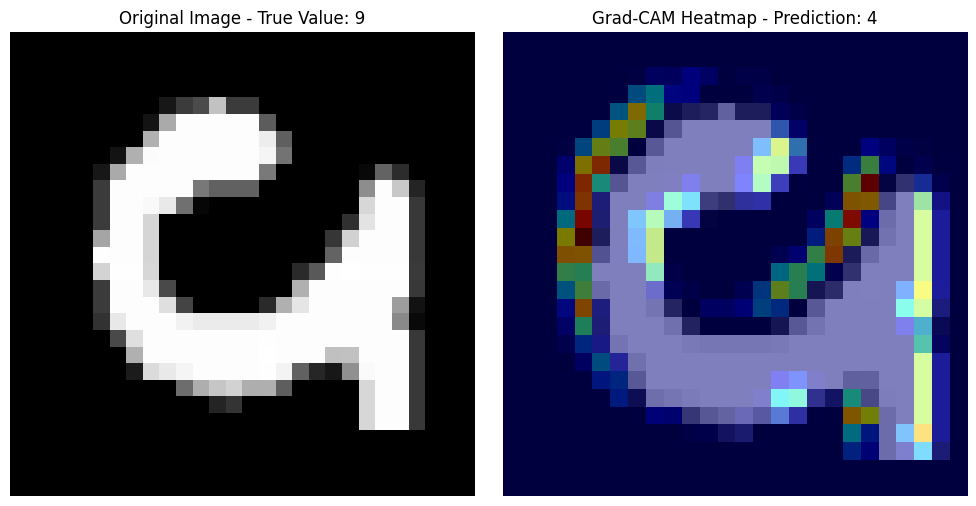

<Figure size 640x480 with 0 Axes>

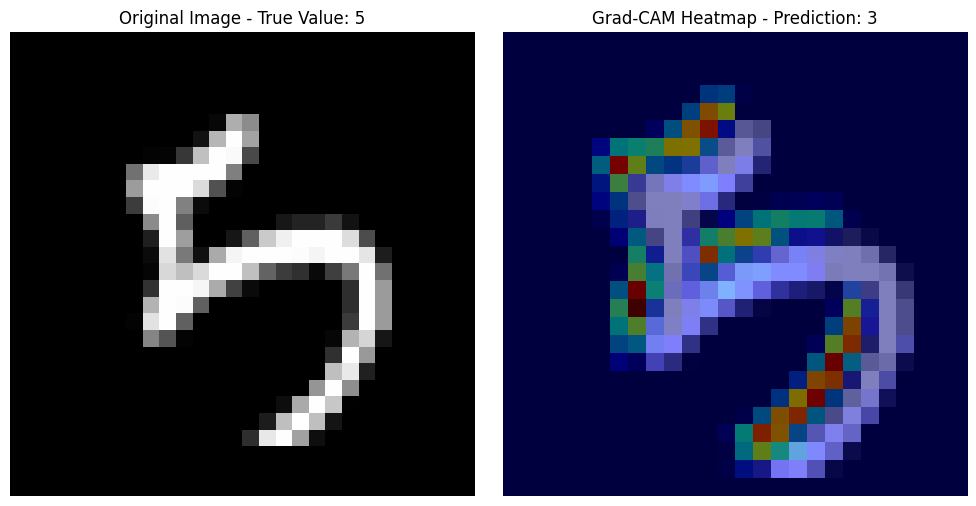

<Figure size 640x480 with 0 Axes>

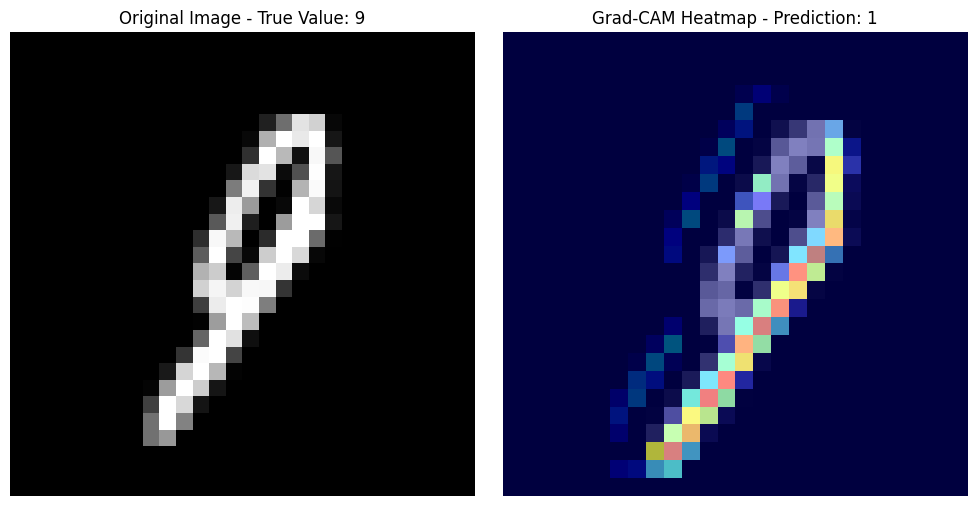

<Figure size 640x480 with 0 Axes>

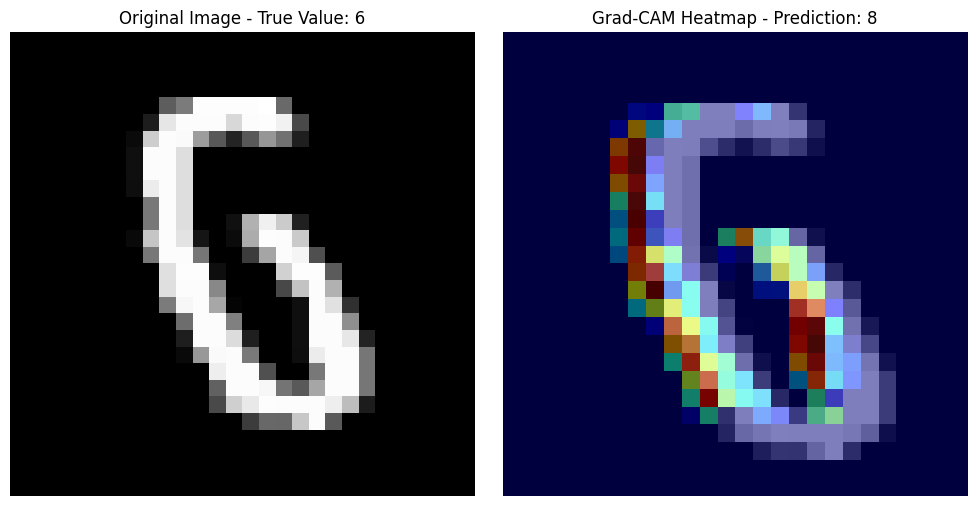

<Figure size 640x480 with 0 Axes>

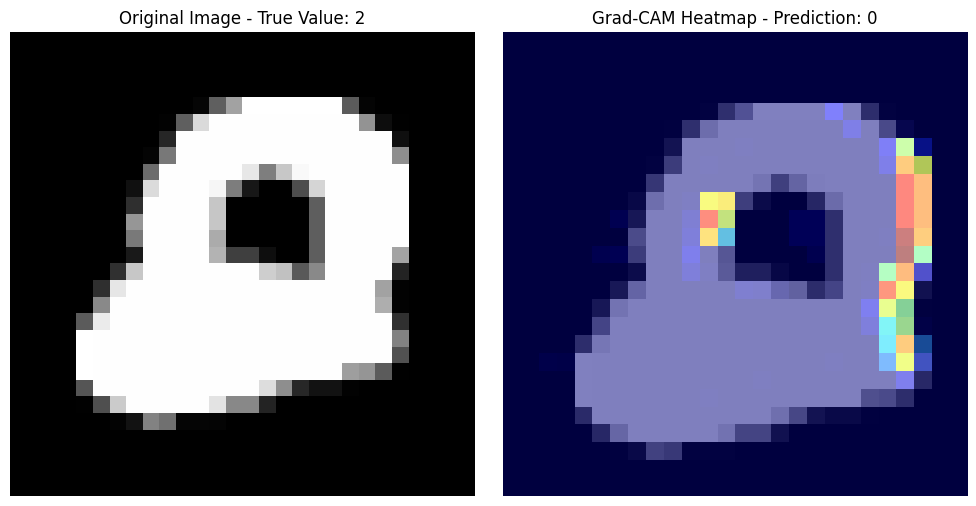

<Figure size 640x480 with 0 Axes>

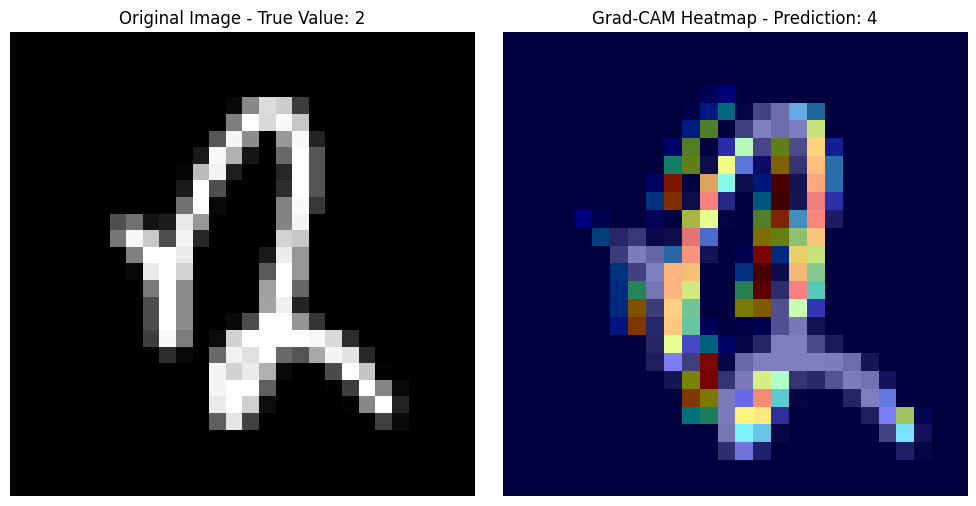

<Figure size 640x480 with 0 Axes>

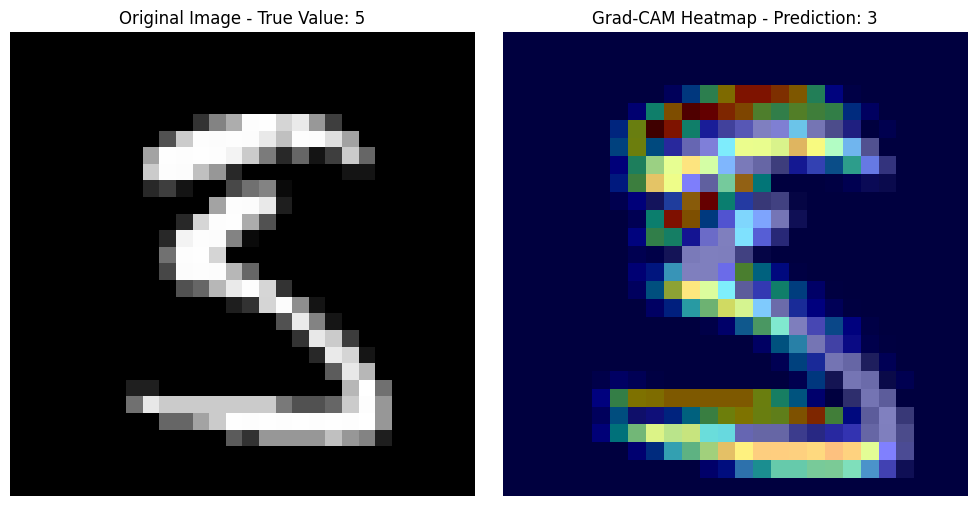

<Figure size 640x480 with 0 Axes>

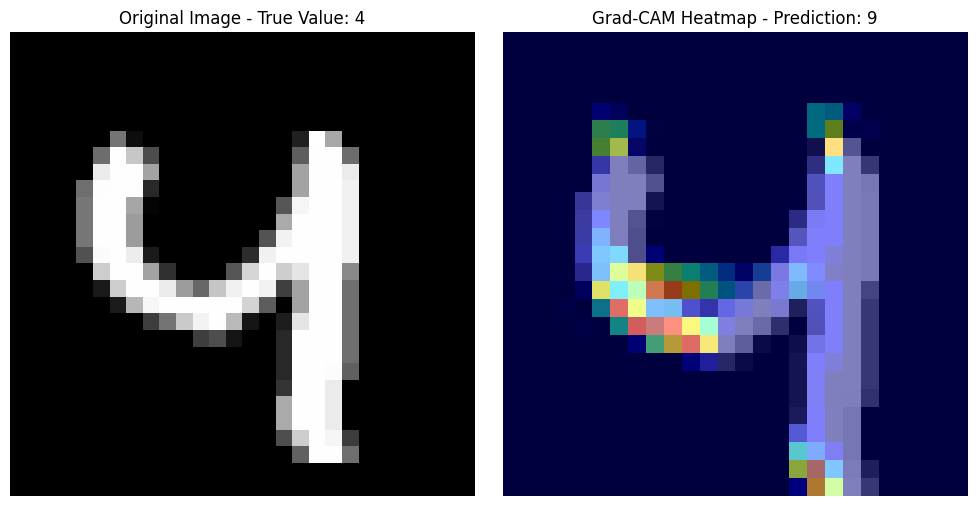

<Figure size 640x480 with 0 Axes>

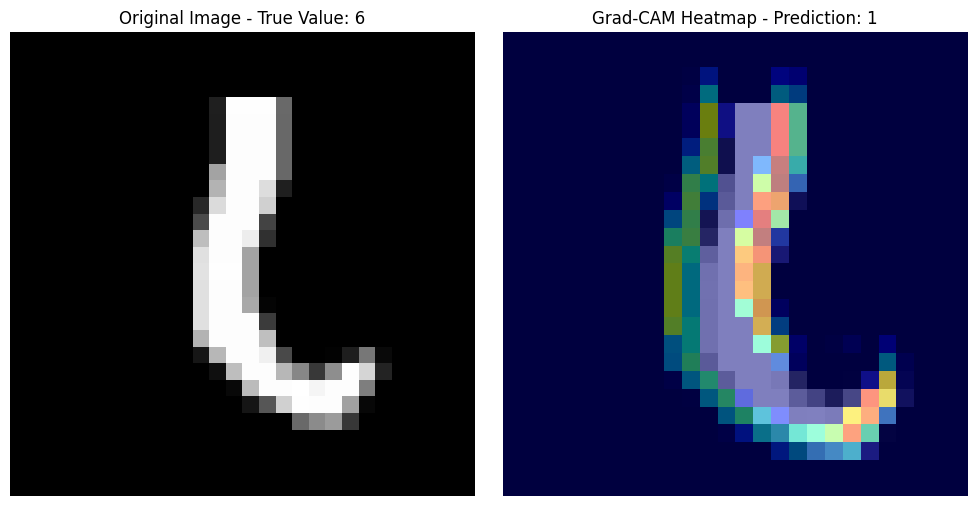

<Figure size 640x480 with 0 Axes>

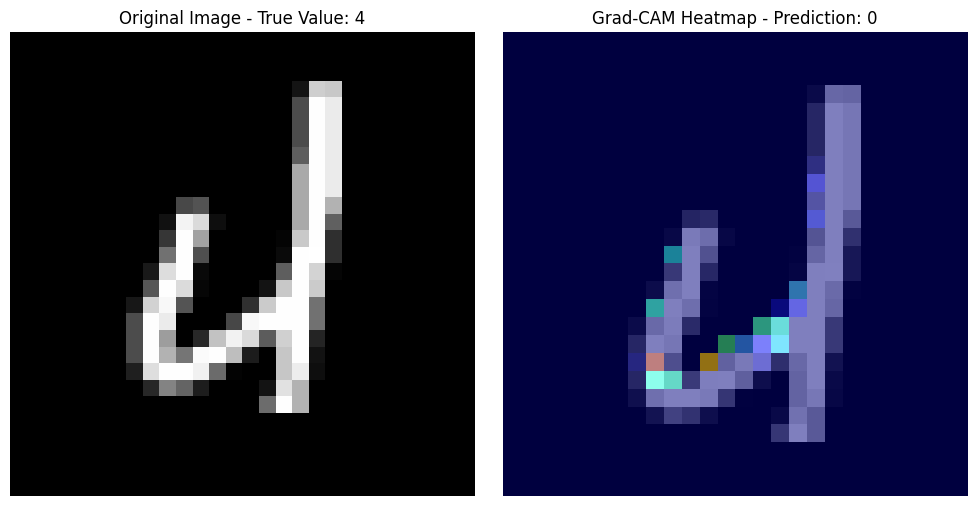

<Figure size 640x480 with 0 Axes>

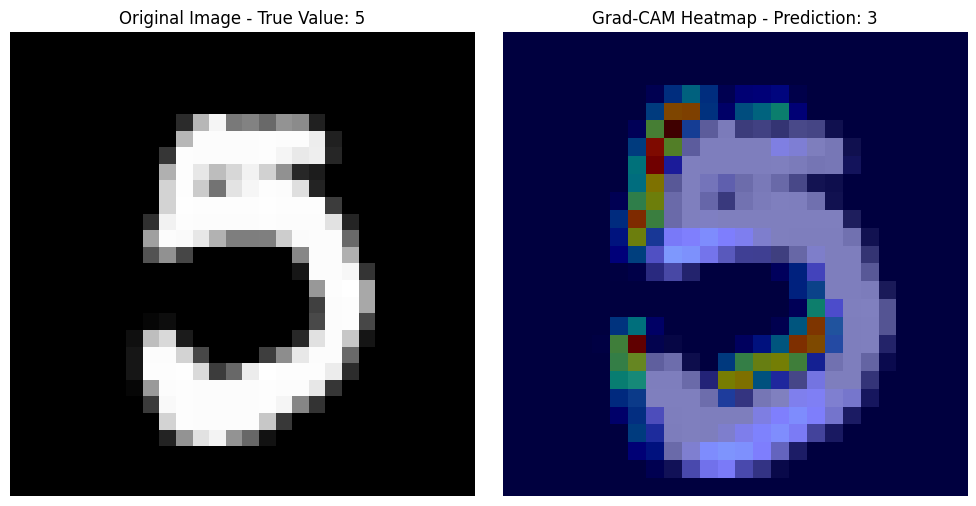

<Figure size 640x480 with 0 Axes>

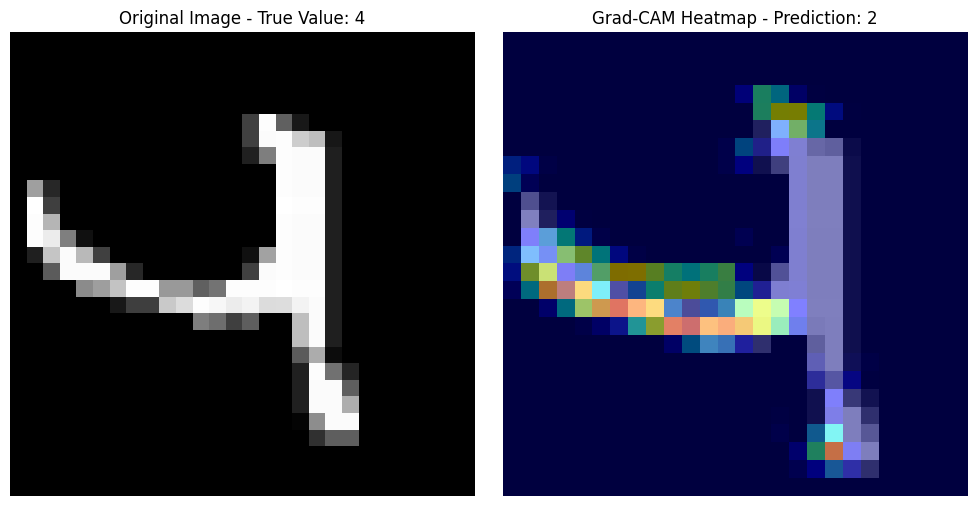

<Figure size 640x480 with 0 Axes>

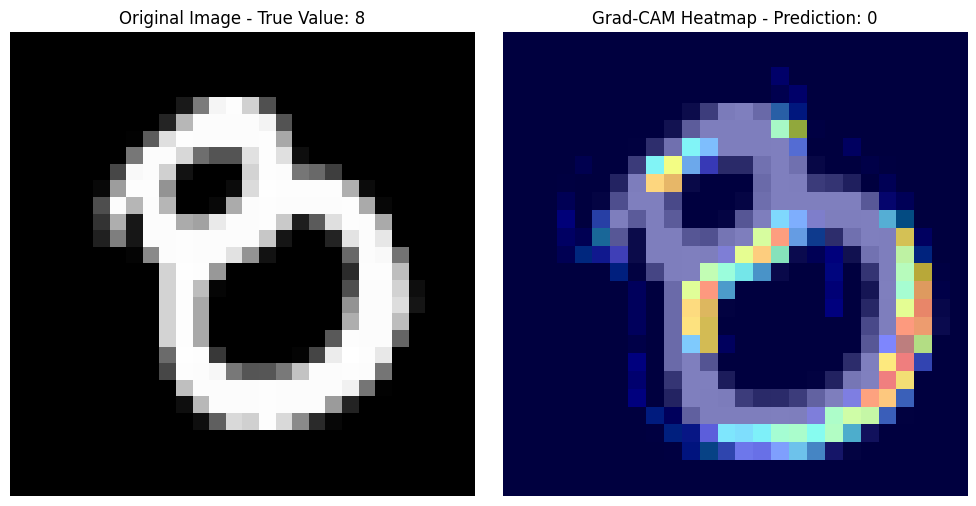

<Figure size 640x480 with 0 Axes>

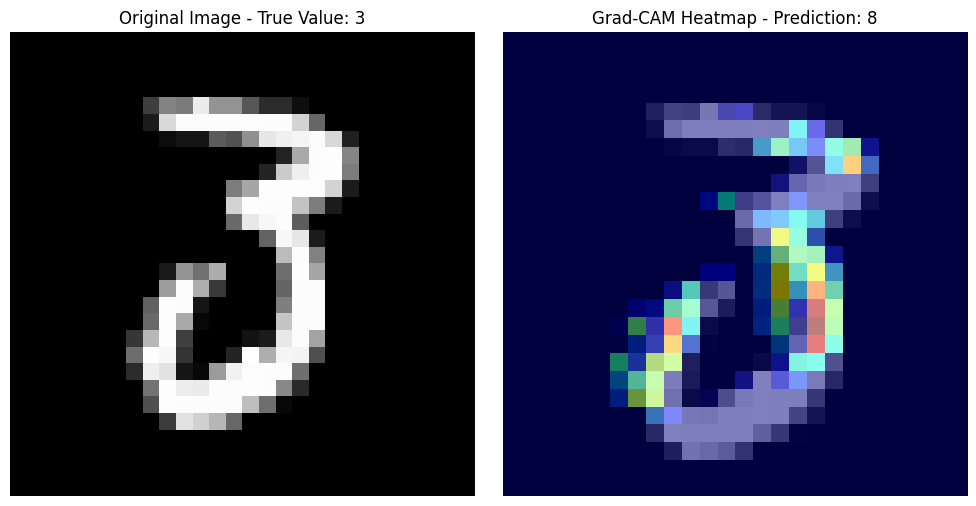

<Figure size 640x480 with 0 Axes>

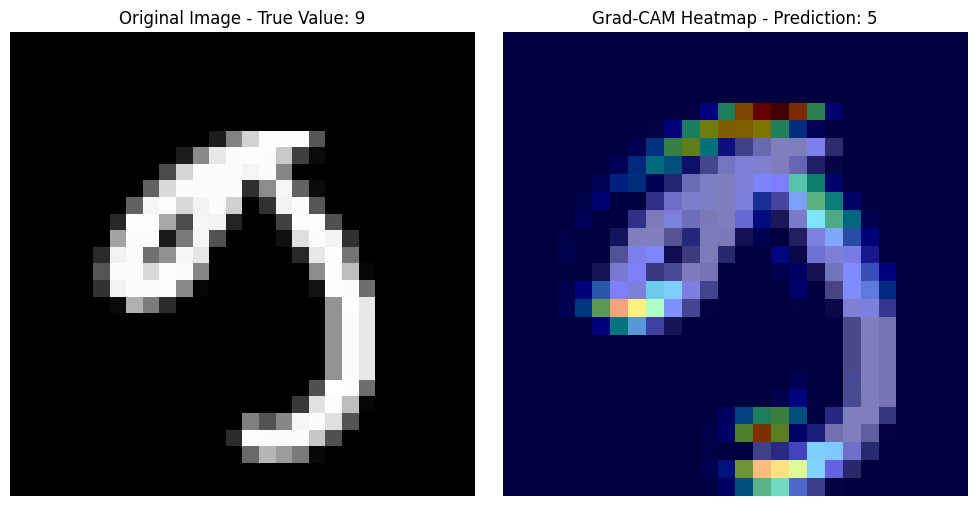

<Figure size 640x480 with 0 Axes>

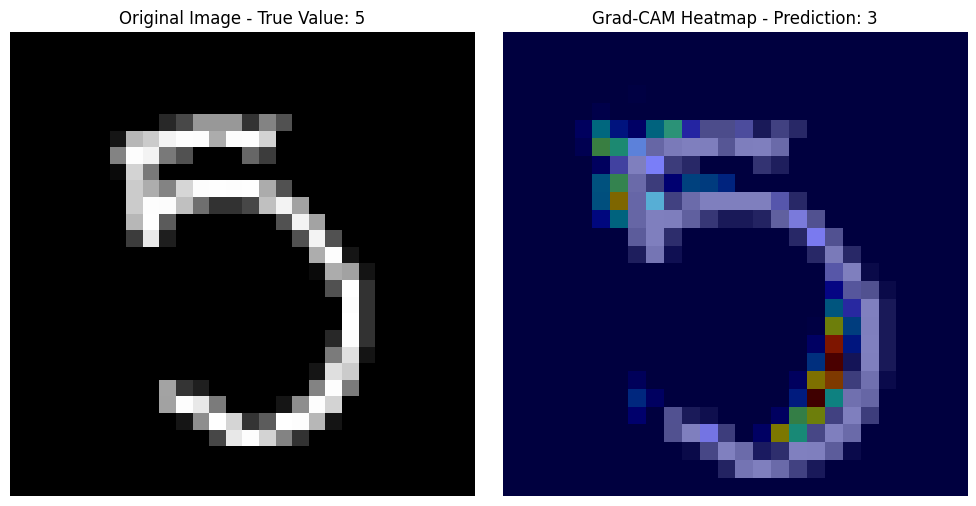

<Figure size 640x480 with 0 Axes>

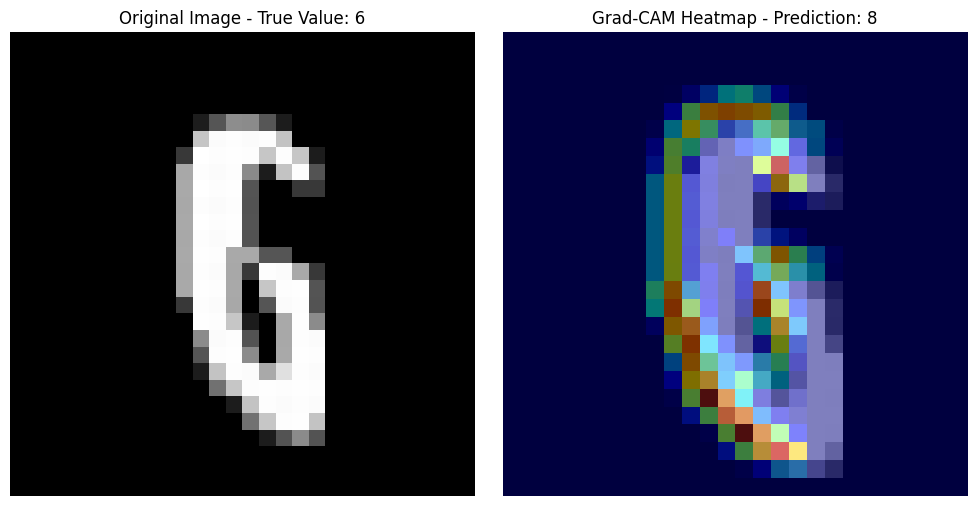

<Figure size 640x480 with 0 Axes>

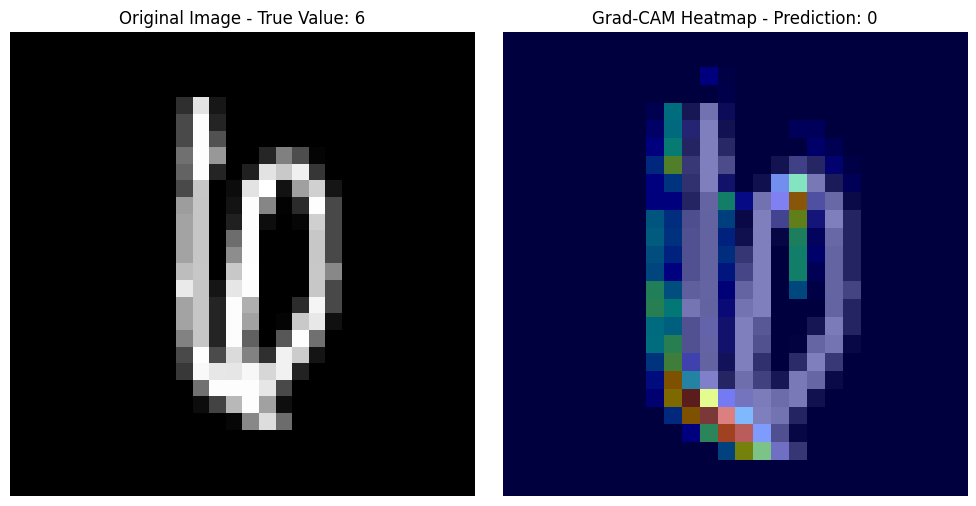

<Figure size 640x480 with 0 Axes>

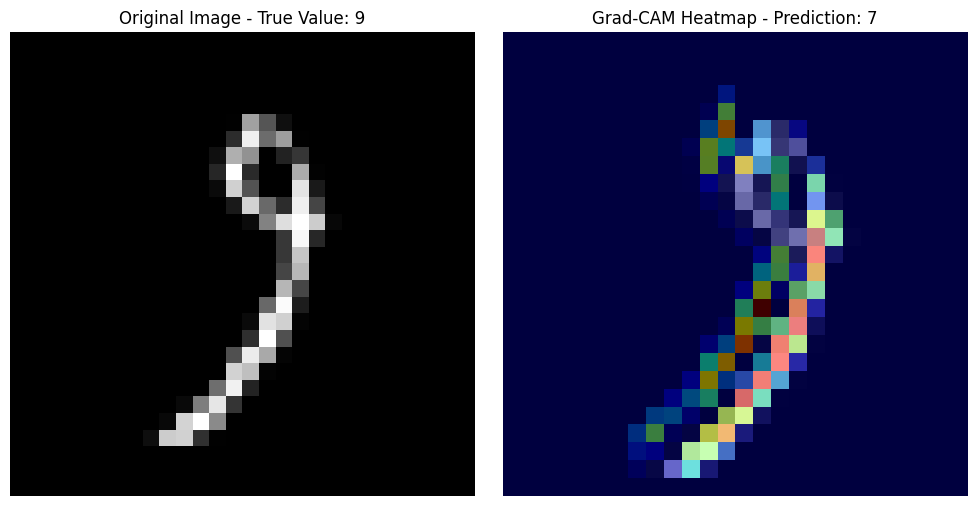

<Figure size 640x480 with 0 Axes>

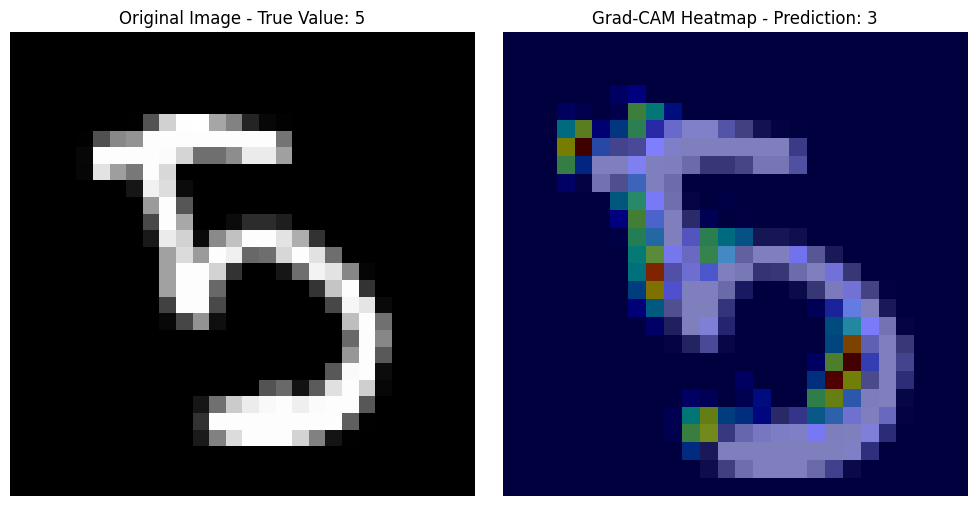

<Figure size 640x480 with 0 Axes>

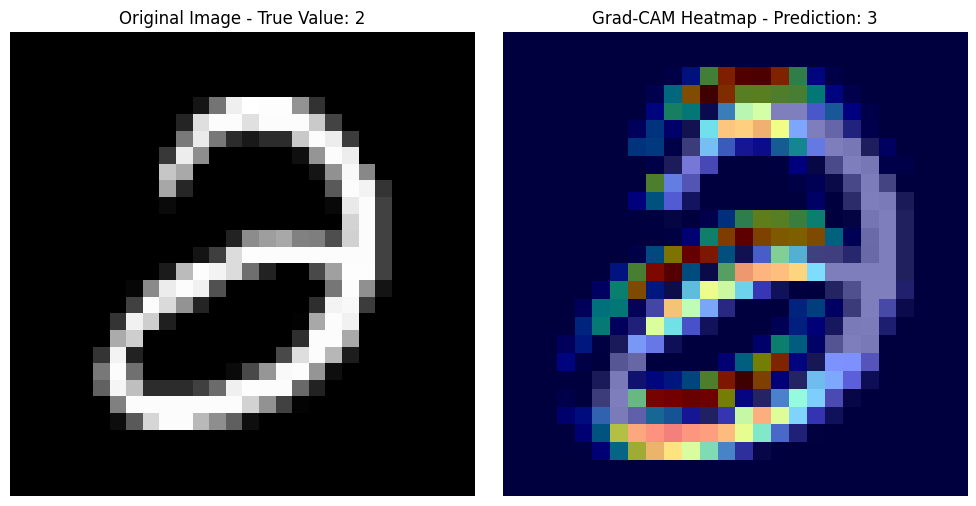

<Figure size 640x480 with 0 Axes>

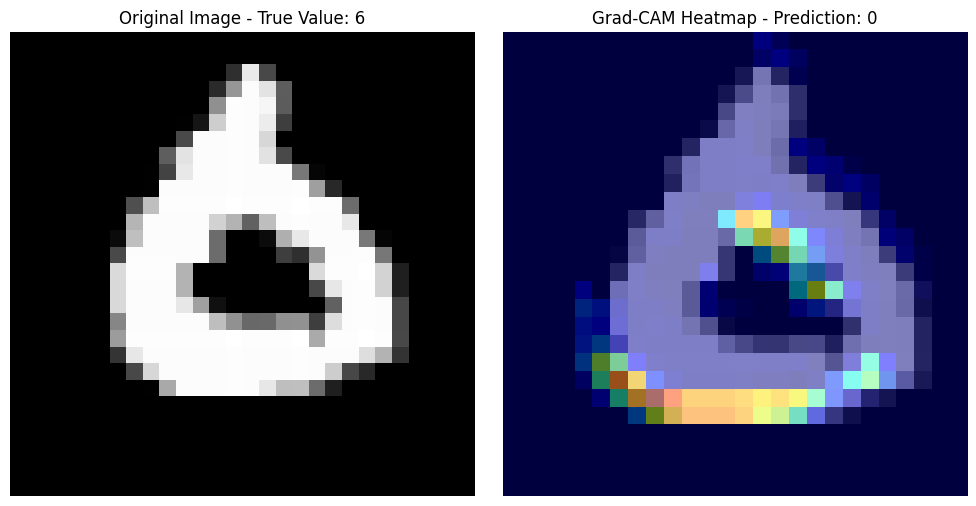

<Figure size 640x480 with 0 Axes>

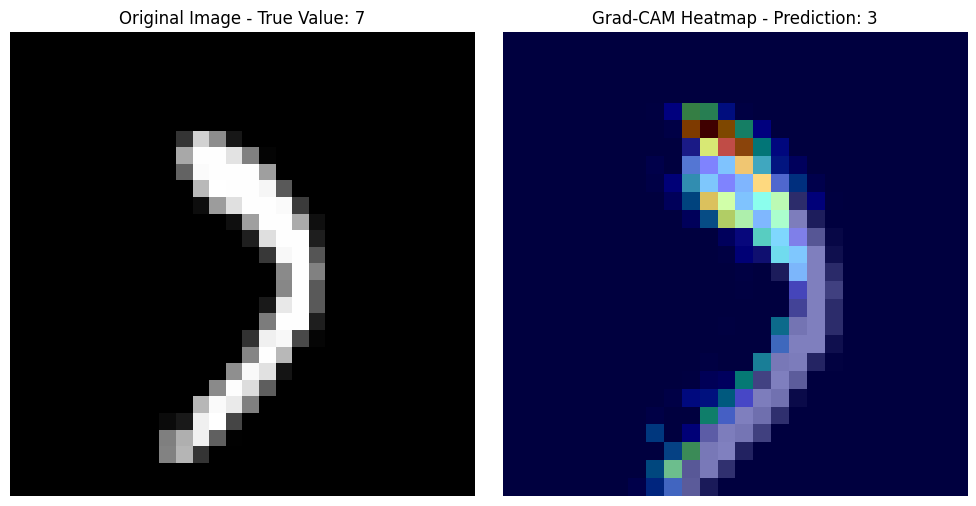

<Figure size 640x480 with 0 Axes>

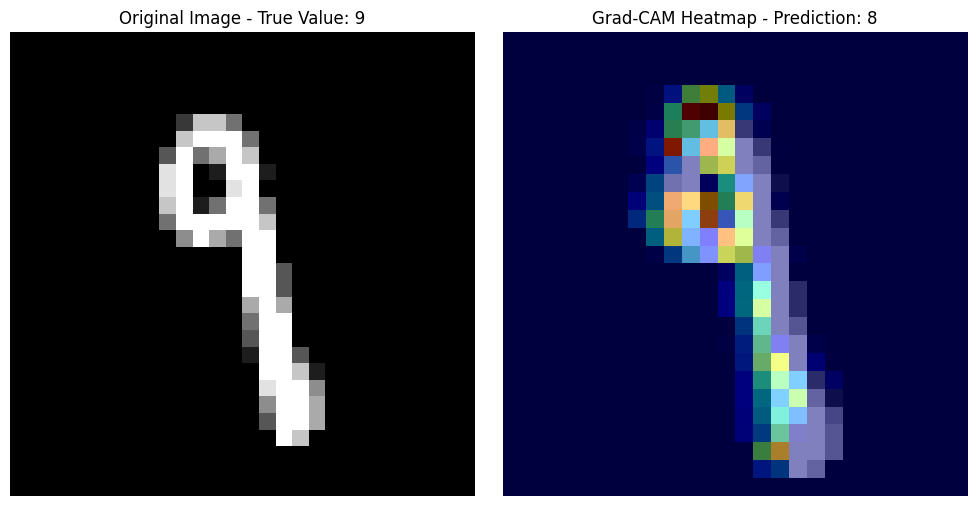

<Figure size 640x480 with 0 Axes>

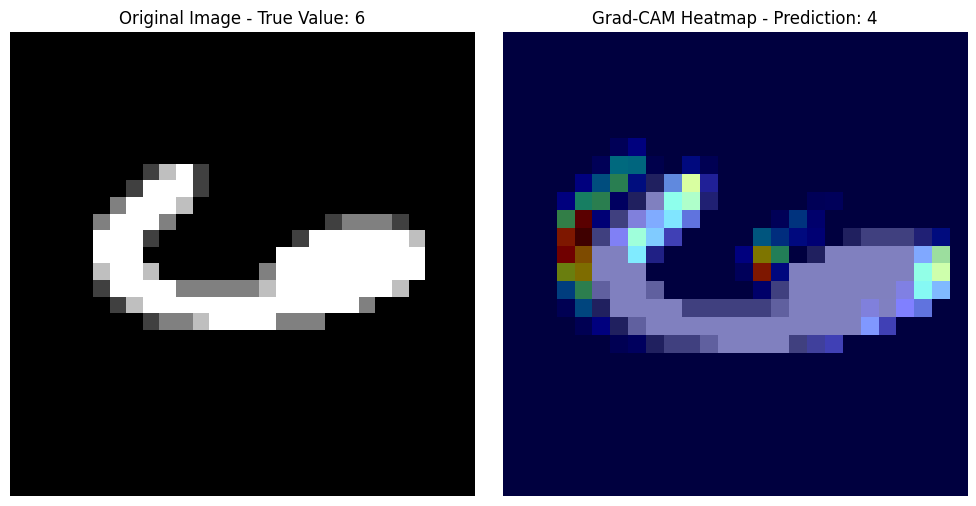

<Figure size 640x480 with 0 Axes>

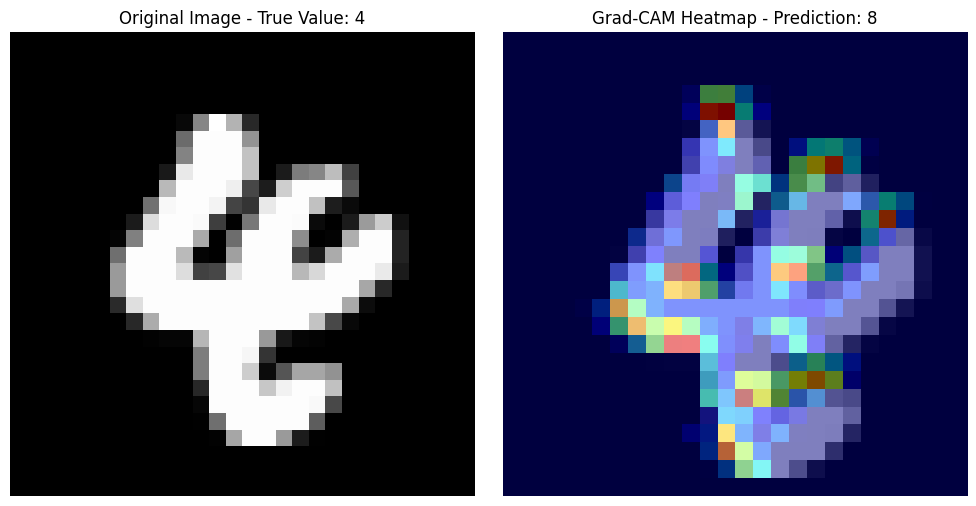

<Figure size 640x480 with 0 Axes>

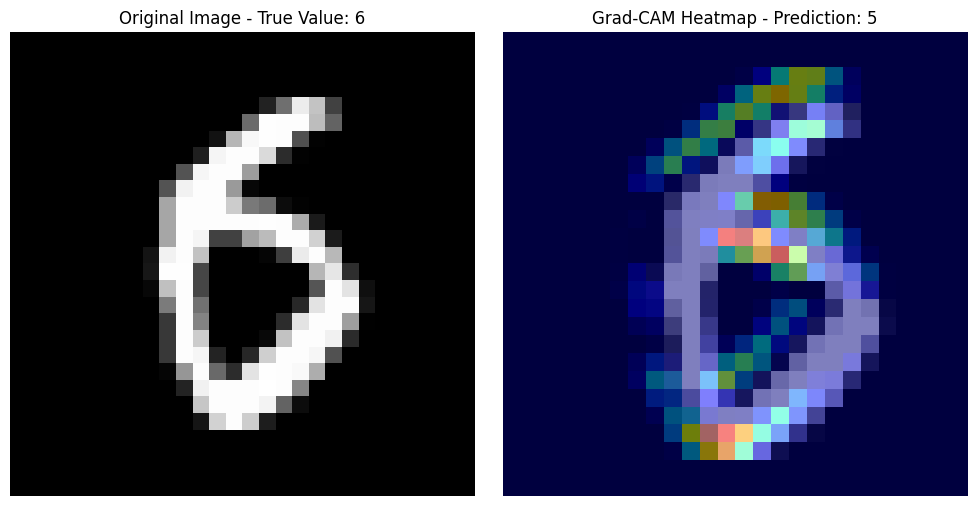

<Figure size 640x480 with 0 Axes>

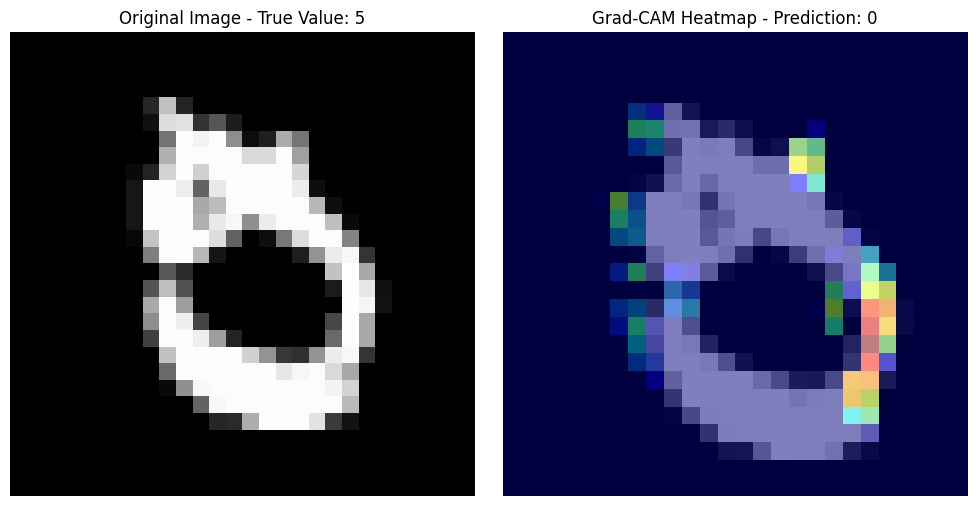

<Figure size 640x480 with 0 Axes>

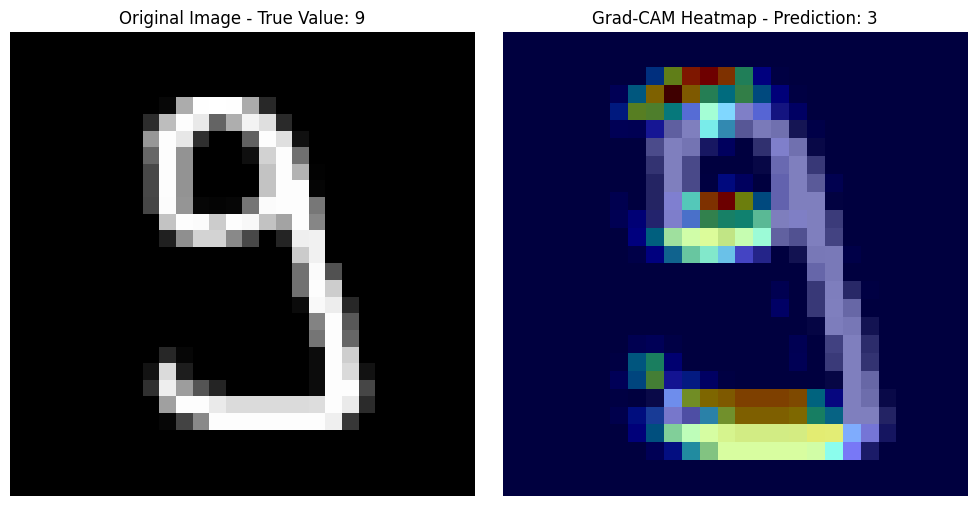

<Figure size 640x480 with 0 Axes>

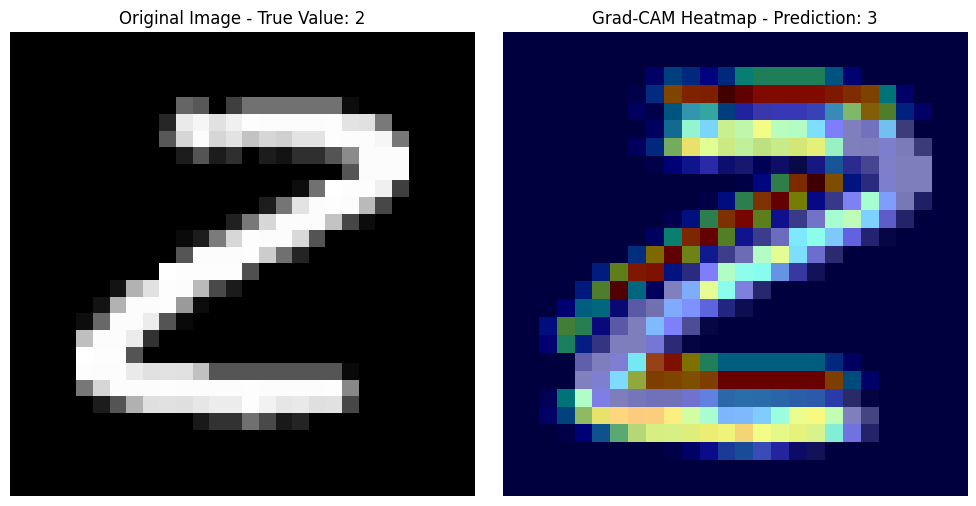

<Figure size 640x480 with 0 Axes>

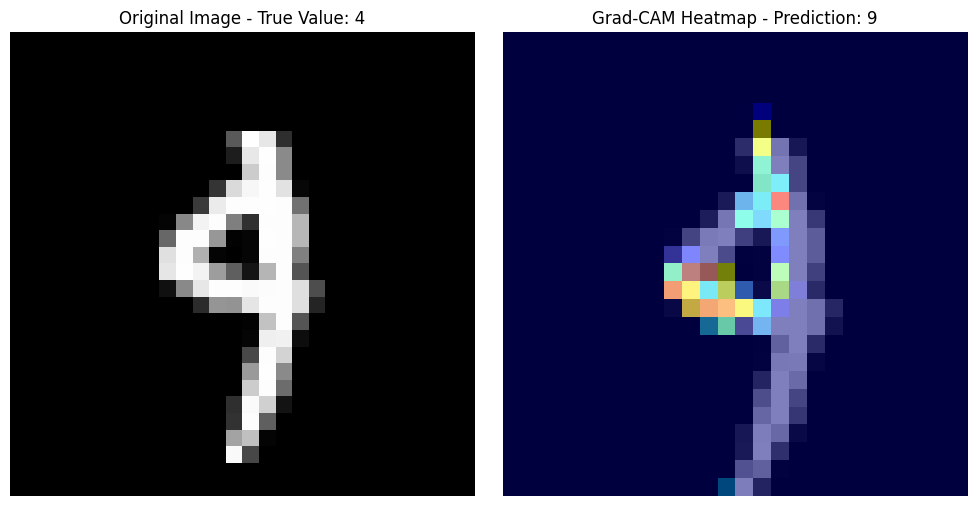

<Figure size 640x480 with 0 Axes>

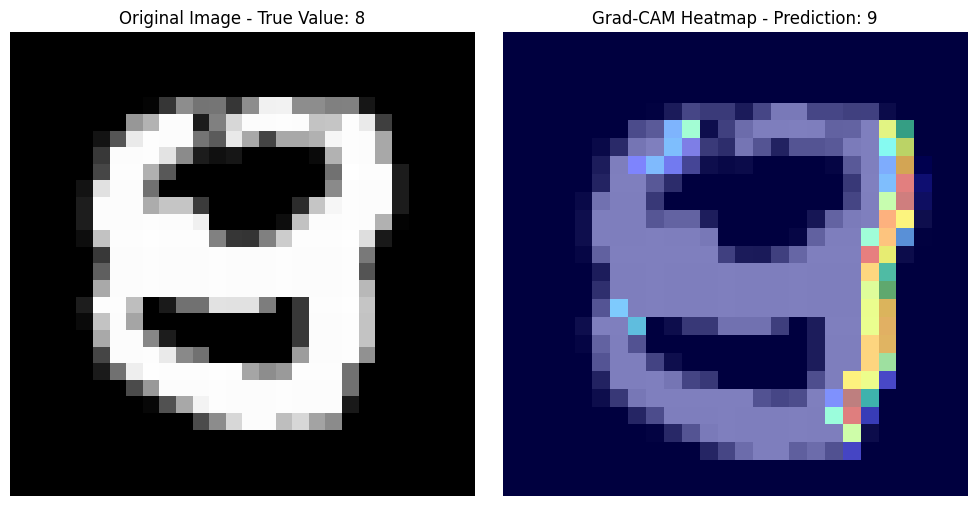

<Figure size 640x480 with 0 Axes>

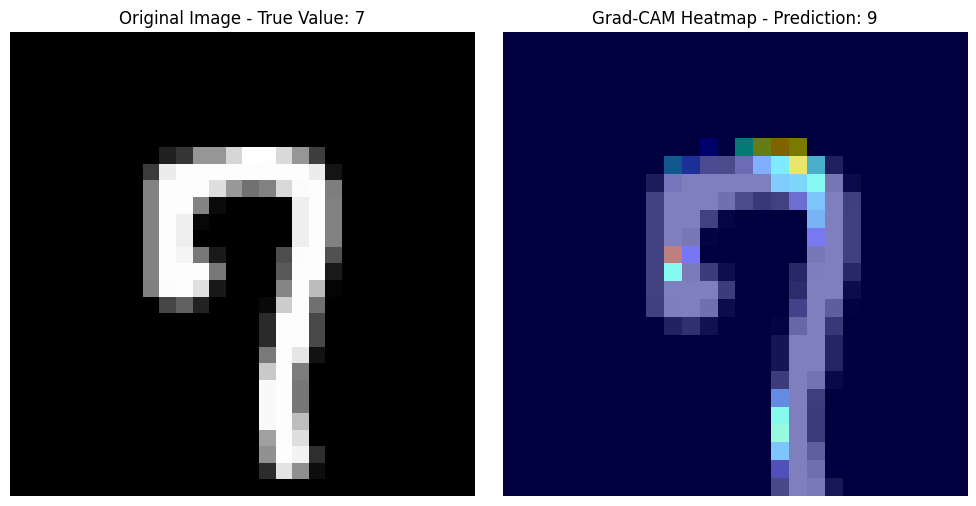

<Figure size 640x480 with 0 Axes>

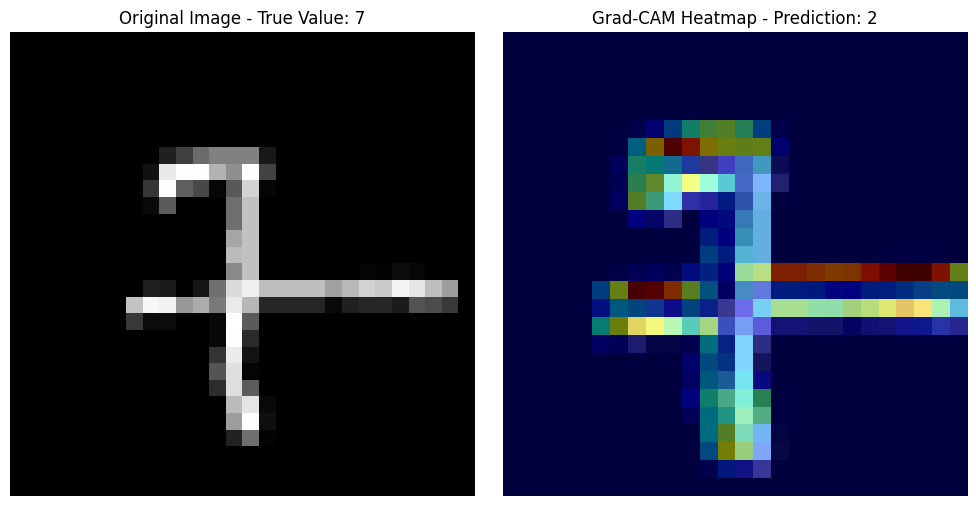

<Figure size 640x480 with 0 Axes>

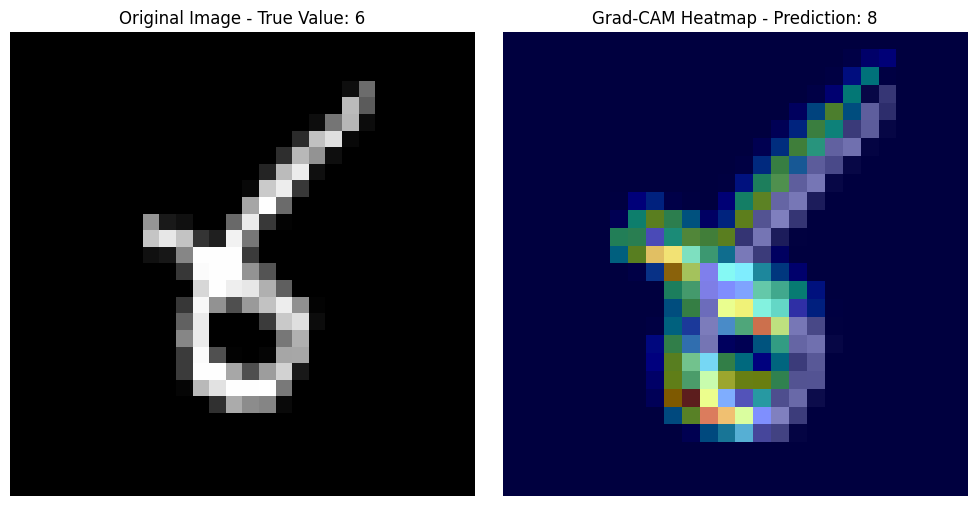

<Figure size 640x480 with 0 Axes>

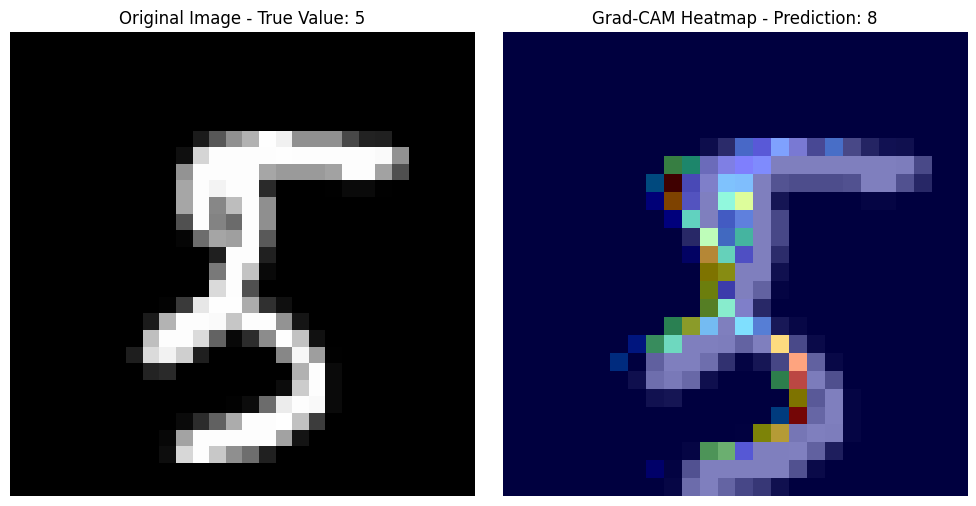

<Figure size 640x480 with 0 Axes>

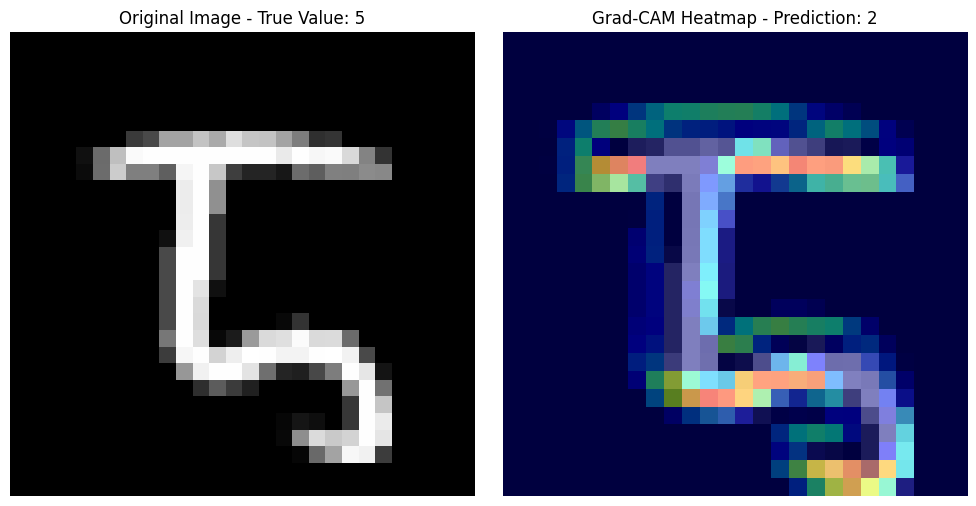

<Figure size 640x480 with 0 Axes>

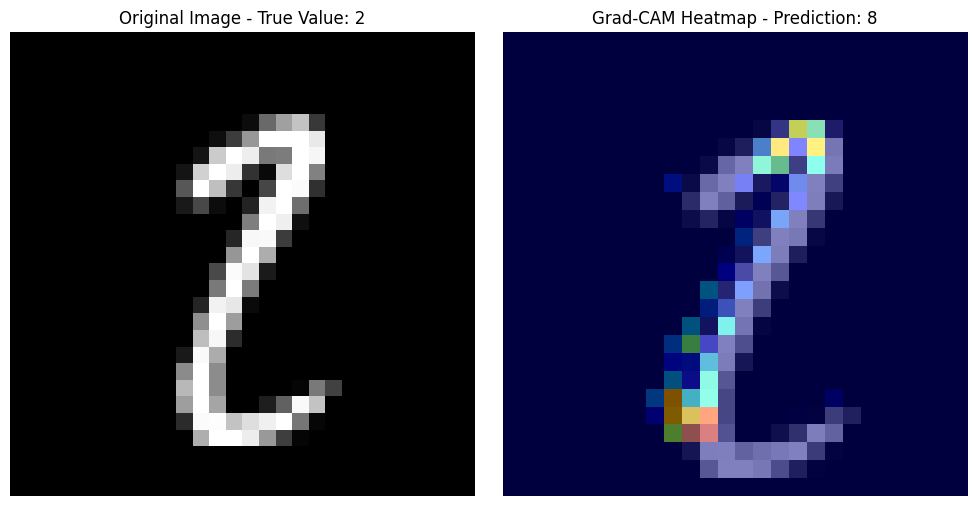

<Figure size 640x480 with 0 Axes>

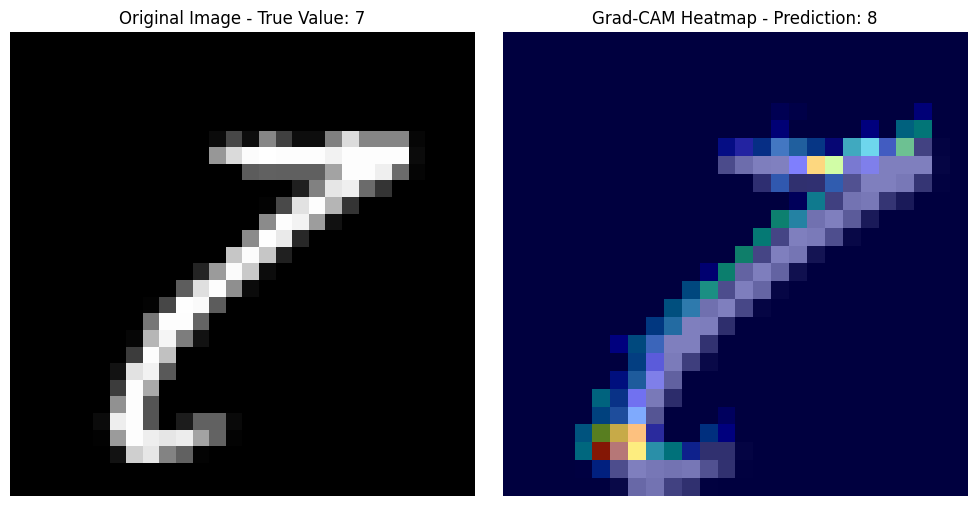

<Figure size 640x480 with 0 Axes>

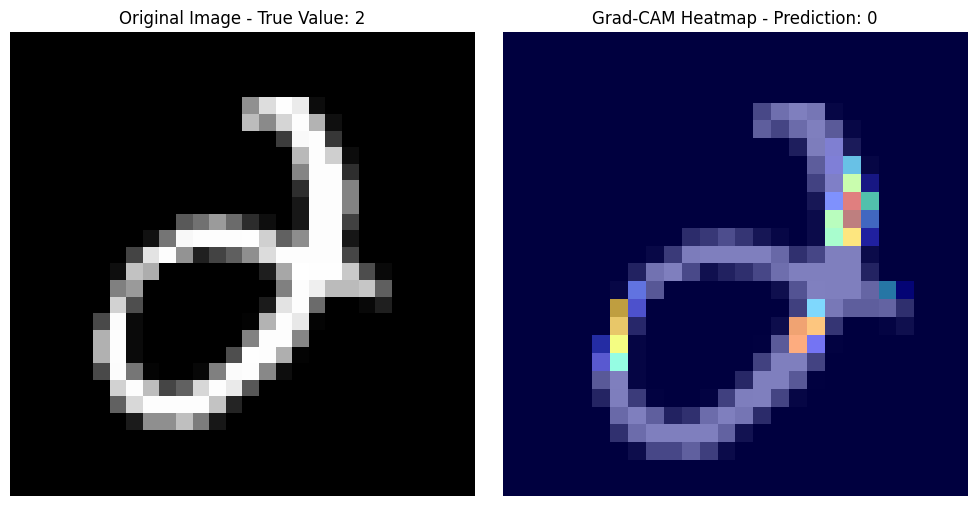

<Figure size 640x480 with 0 Axes>

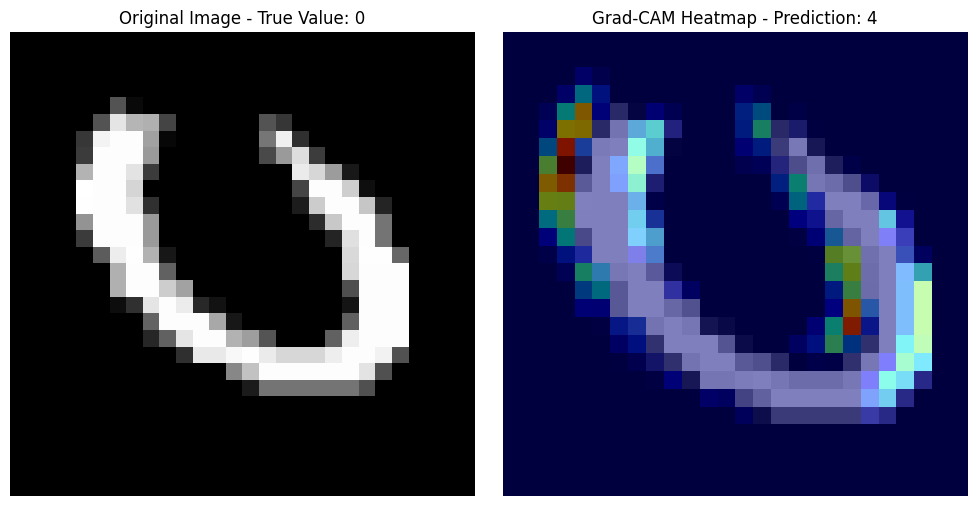

<Figure size 640x480 with 0 Axes>

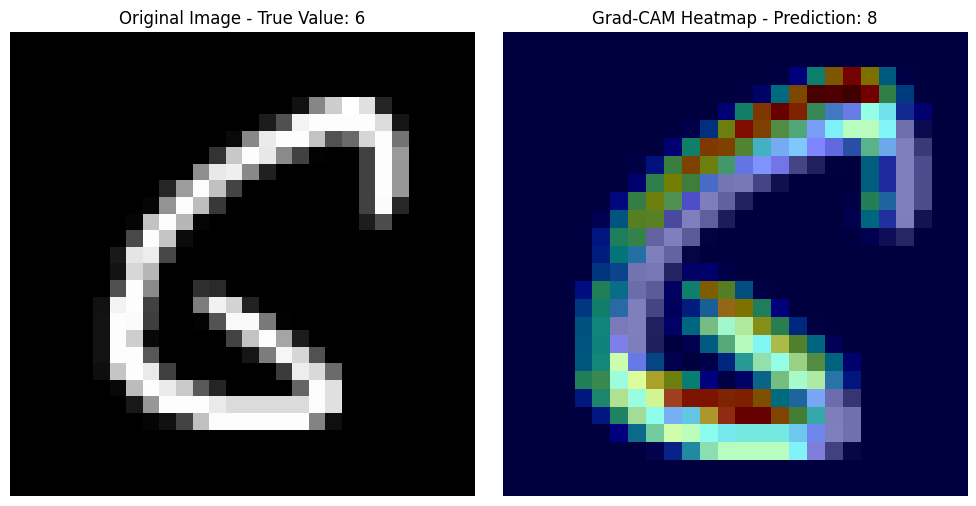

<Figure size 640x480 with 0 Axes>

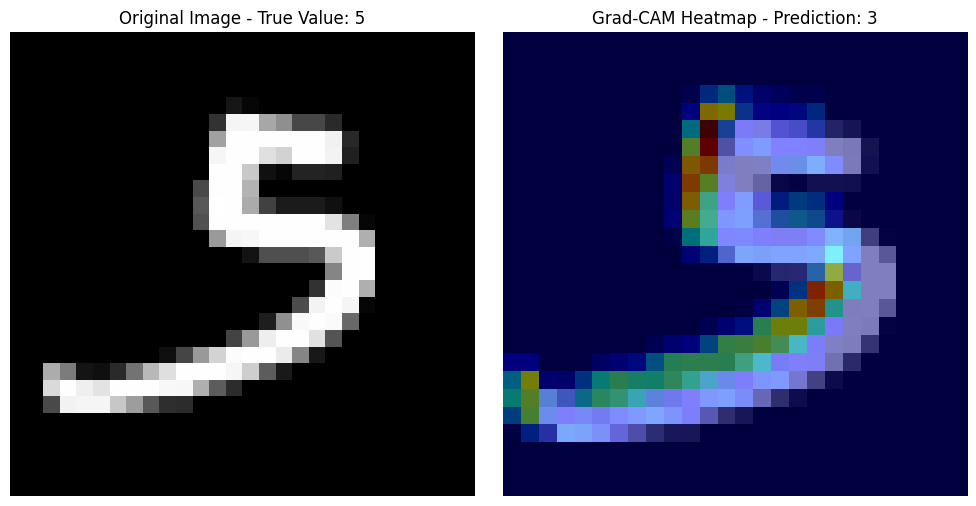

<Figure size 640x480 with 0 Axes>

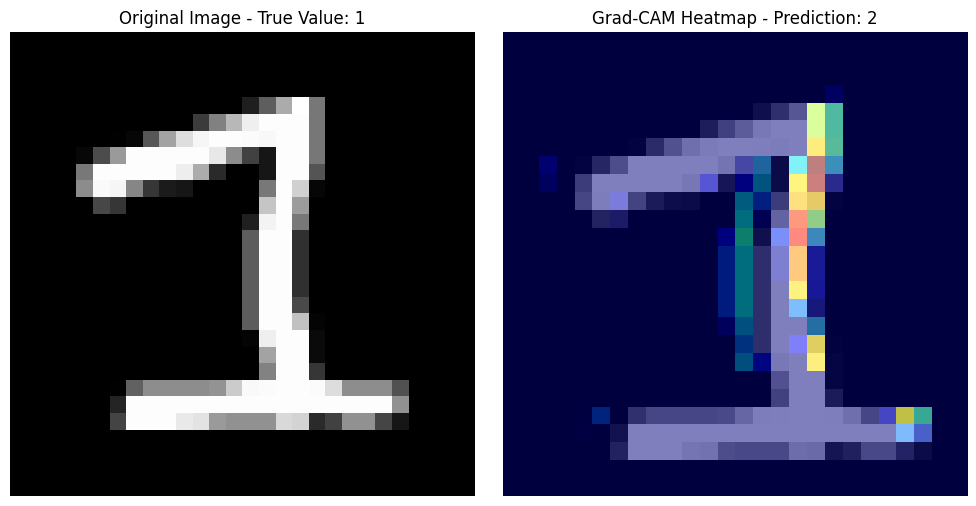

<Figure size 640x480 with 0 Axes>

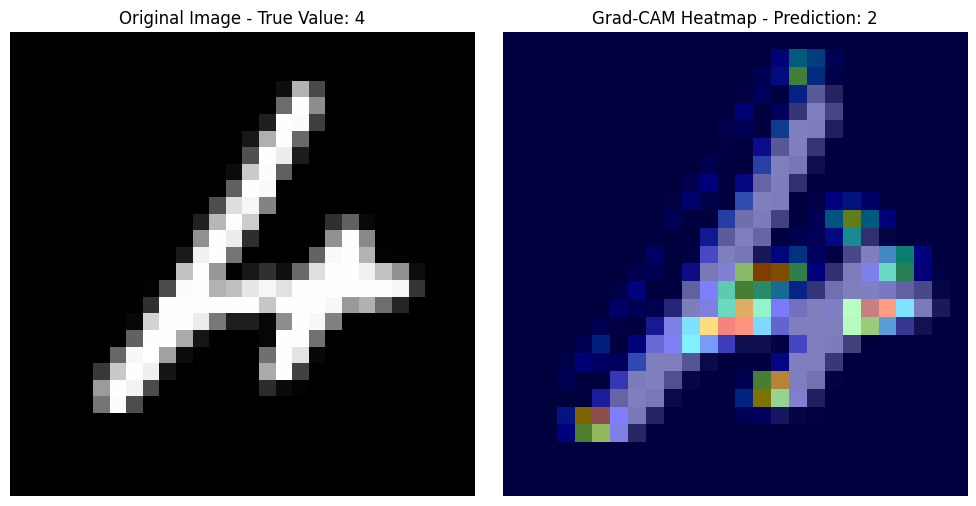

<Figure size 640x480 with 0 Axes>

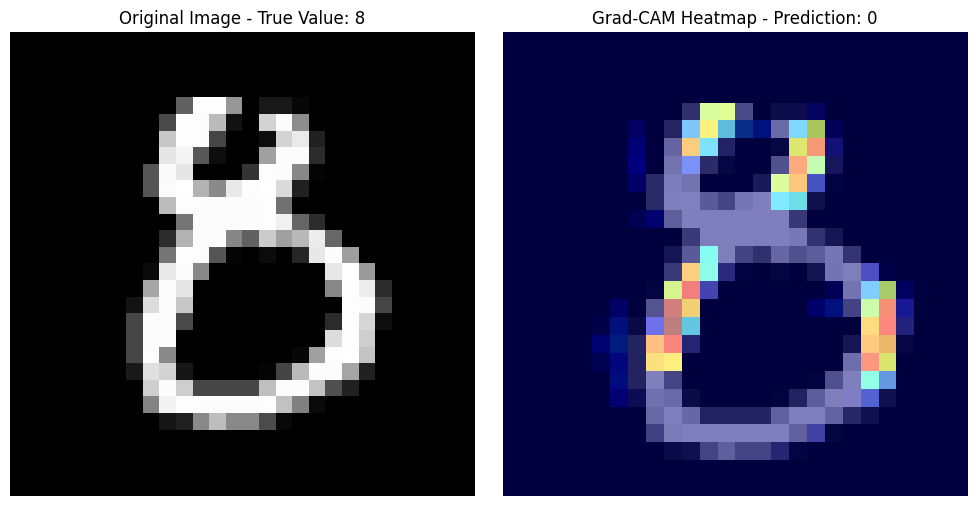

<Figure size 640x480 with 0 Axes>

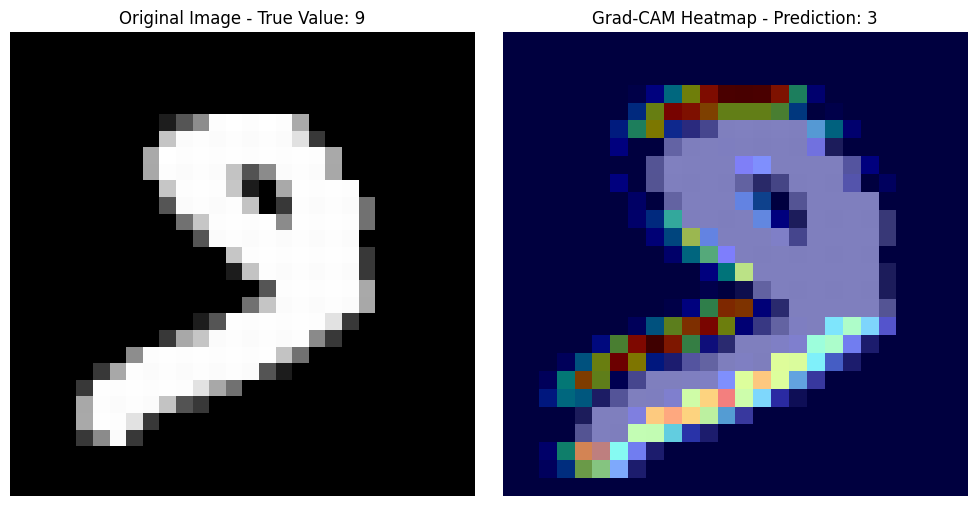

<Figure size 640x480 with 0 Axes>

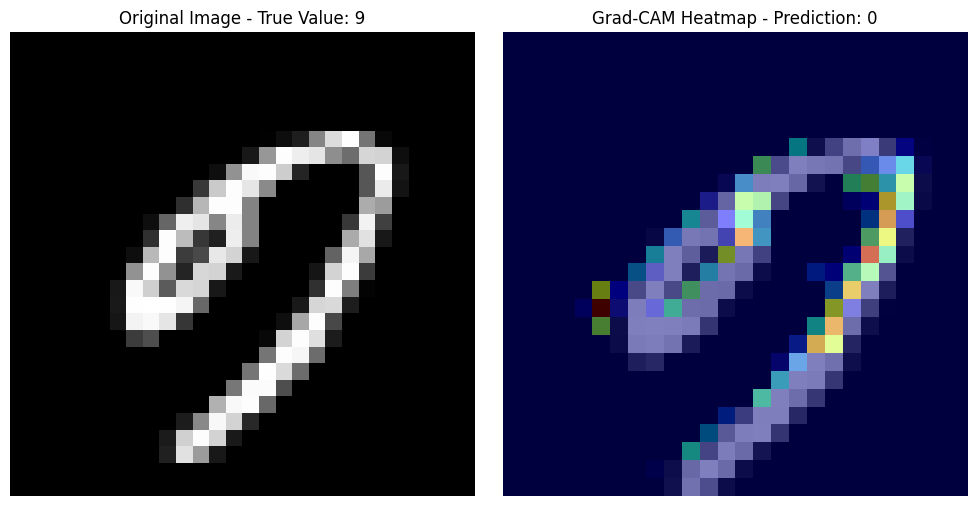

<Figure size 640x480 with 0 Axes>

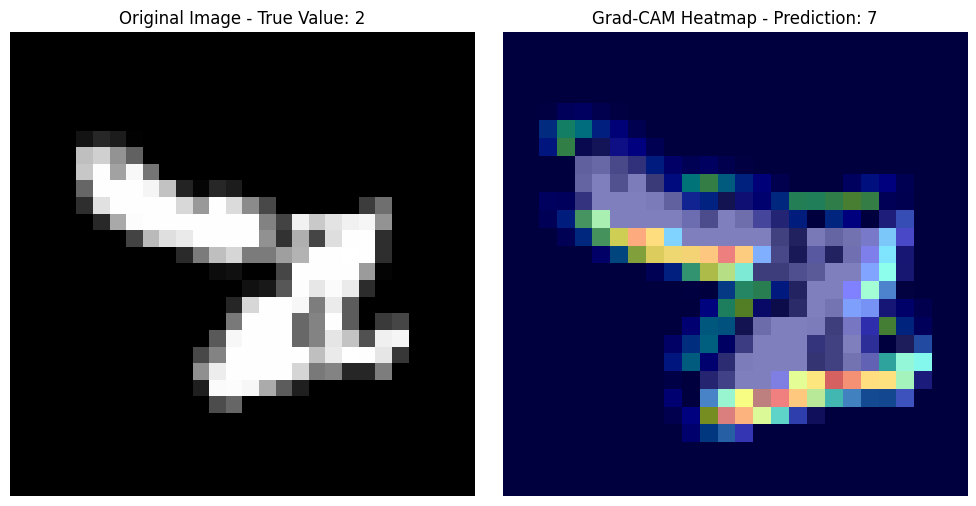

<Figure size 640x480 with 0 Axes>

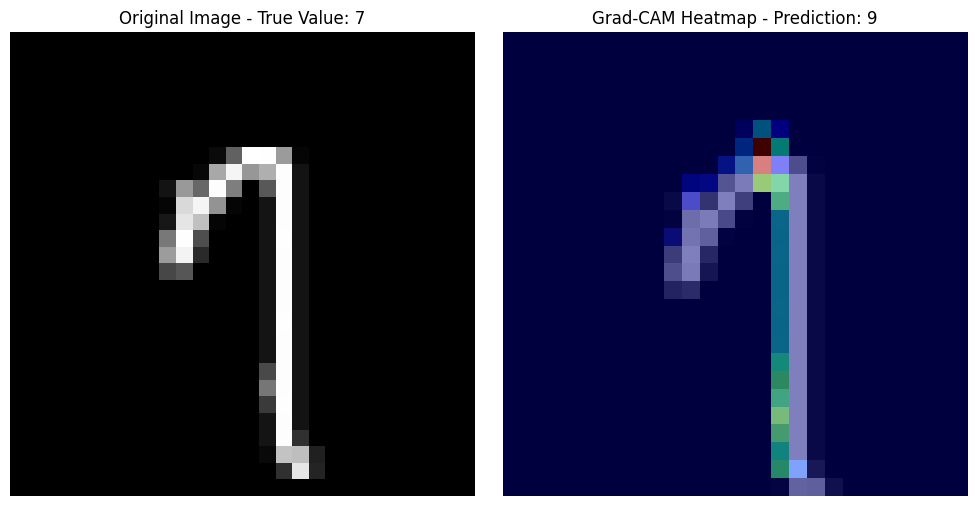

<Figure size 640x480 with 0 Axes>

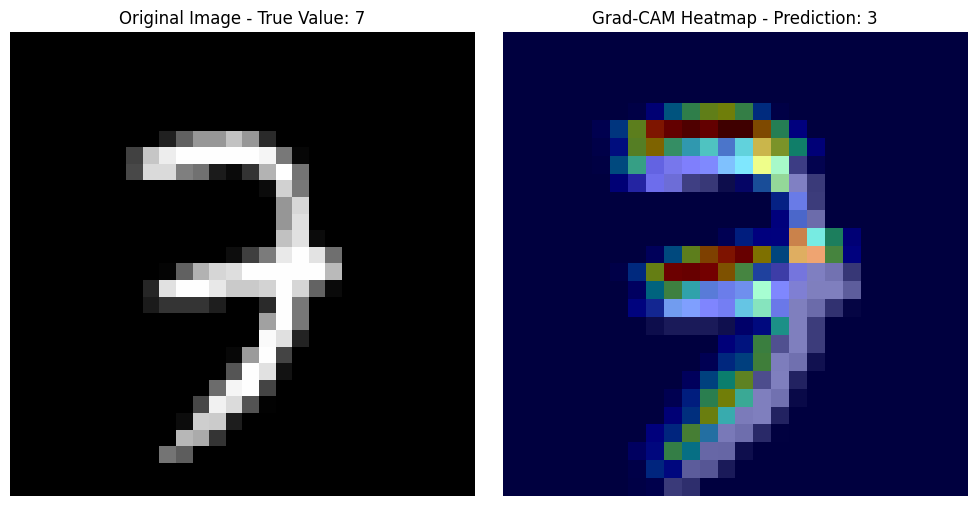

<Figure size 640x480 with 0 Axes>

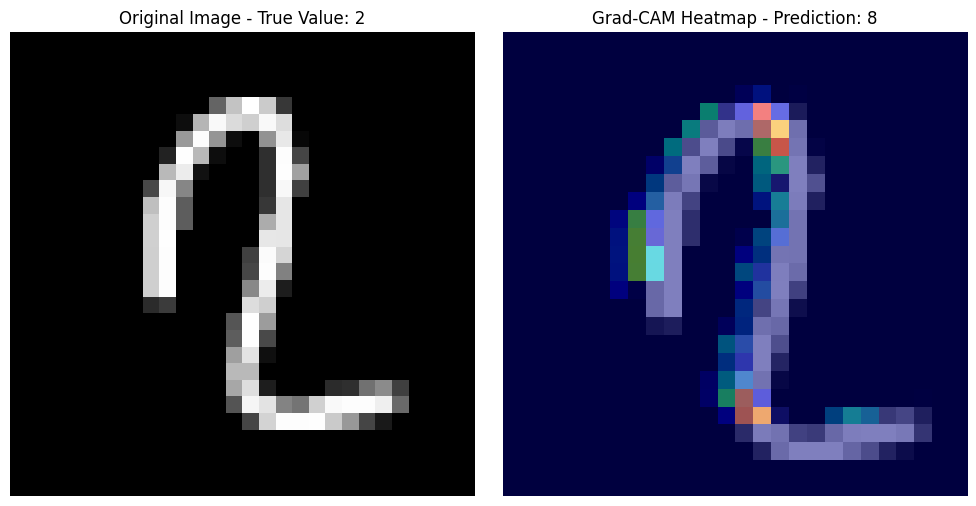

<Figure size 640x480 with 0 Axes>

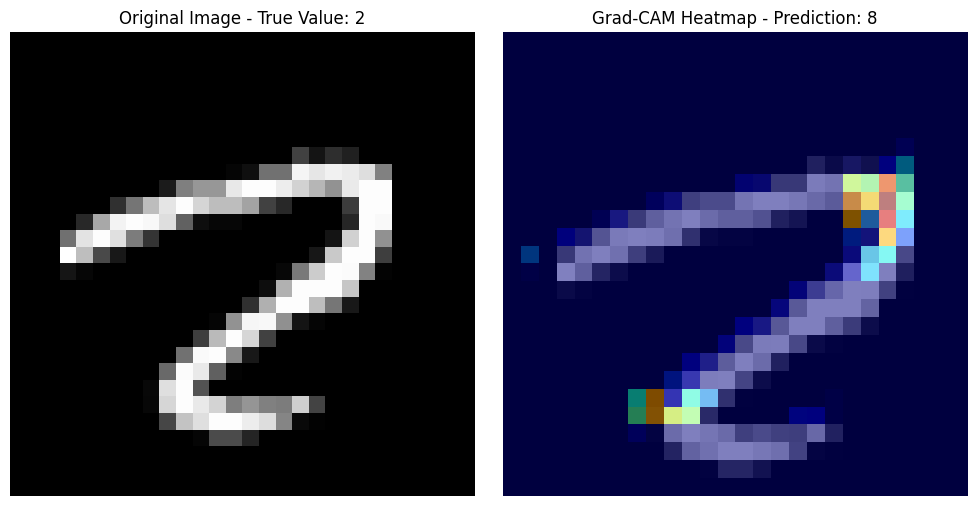

<Figure size 640x480 with 0 Axes>

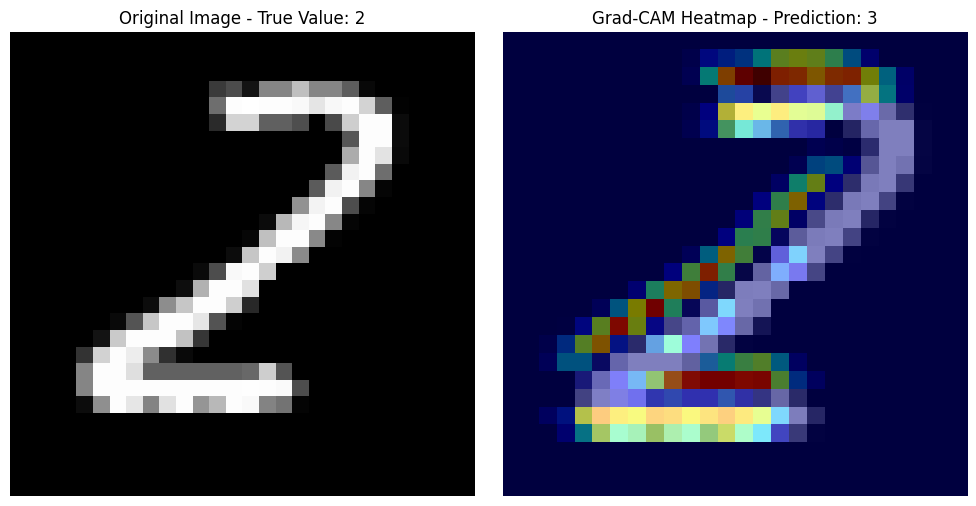

<Figure size 640x480 with 0 Axes>

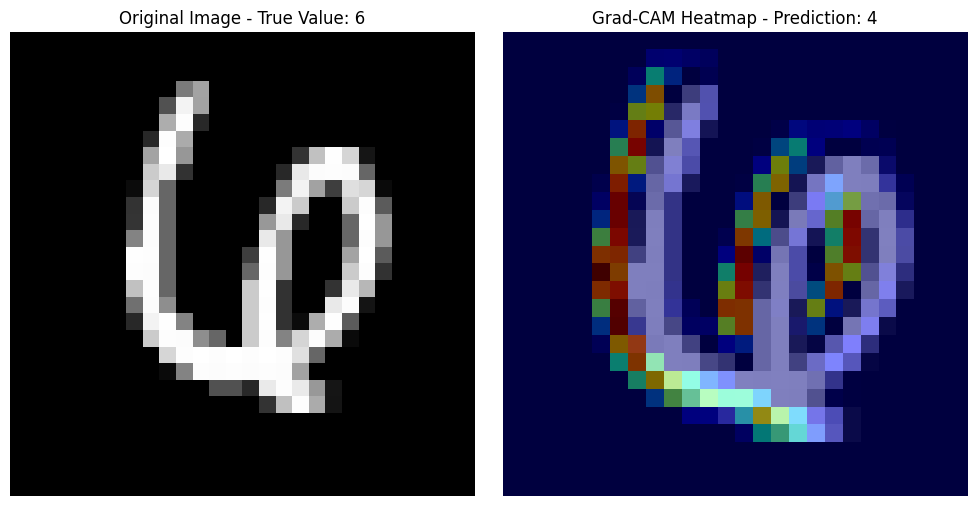

<Figure size 640x480 with 0 Axes>

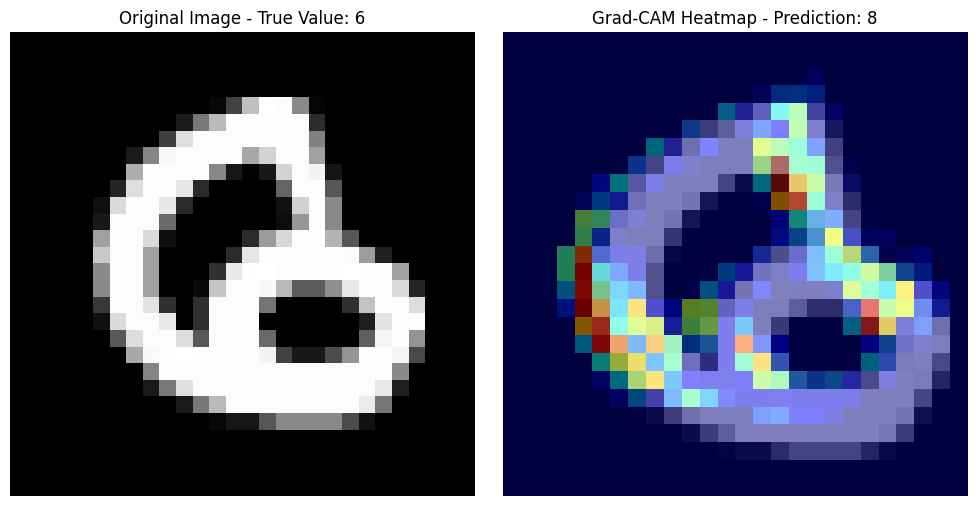

<Figure size 640x480 with 0 Axes>

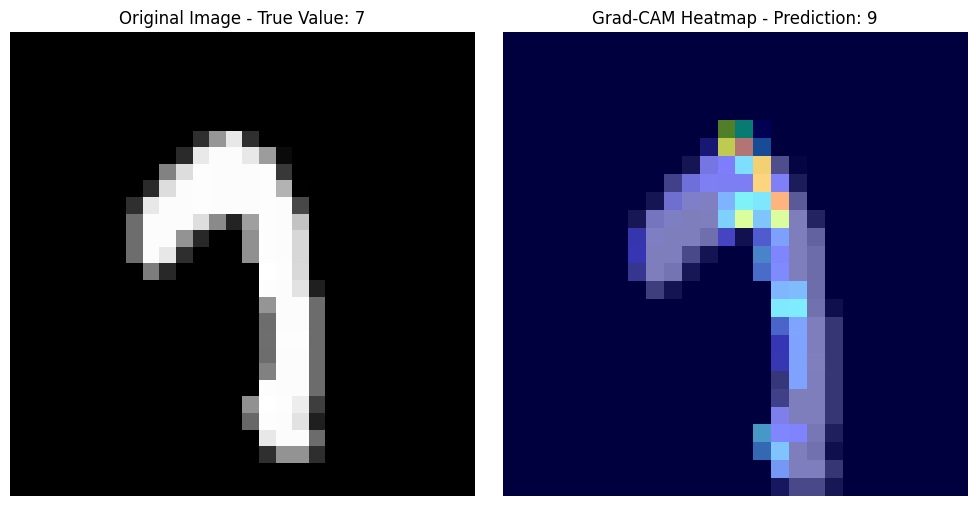

<Figure size 640x480 with 0 Axes>

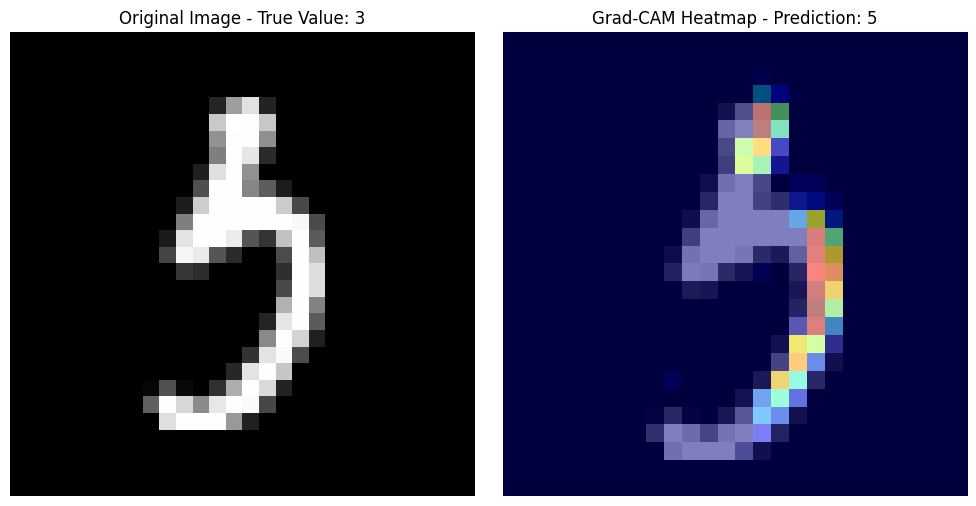

<Figure size 640x480 with 0 Axes>

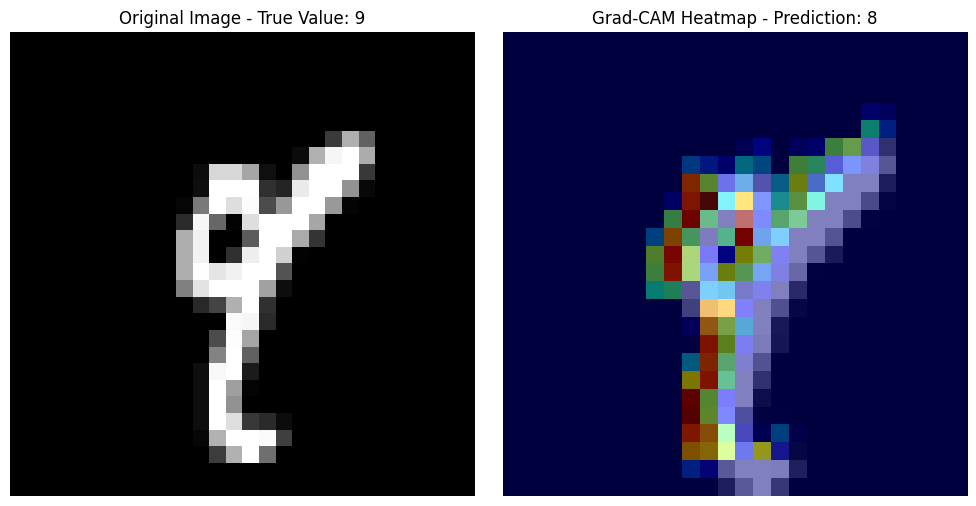

<Figure size 640x480 with 0 Axes>

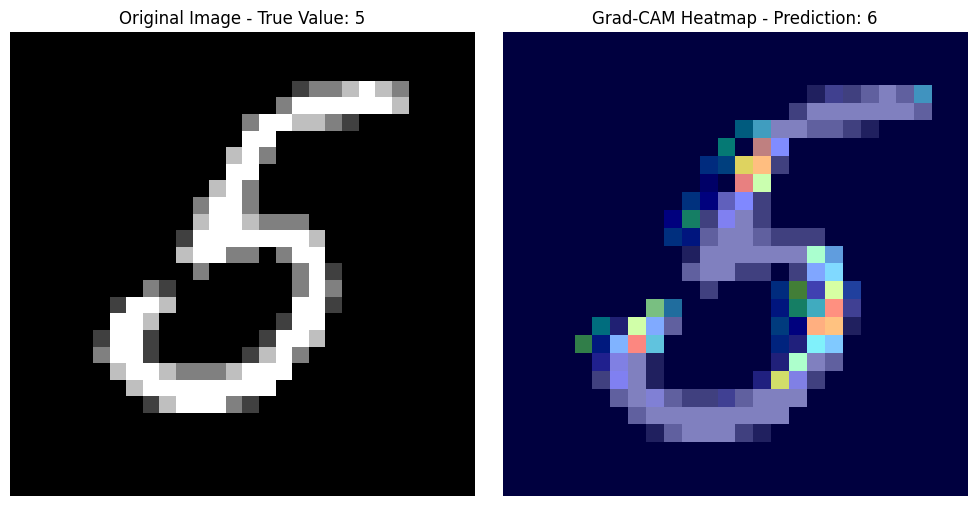

<Figure size 640x480 with 0 Axes>

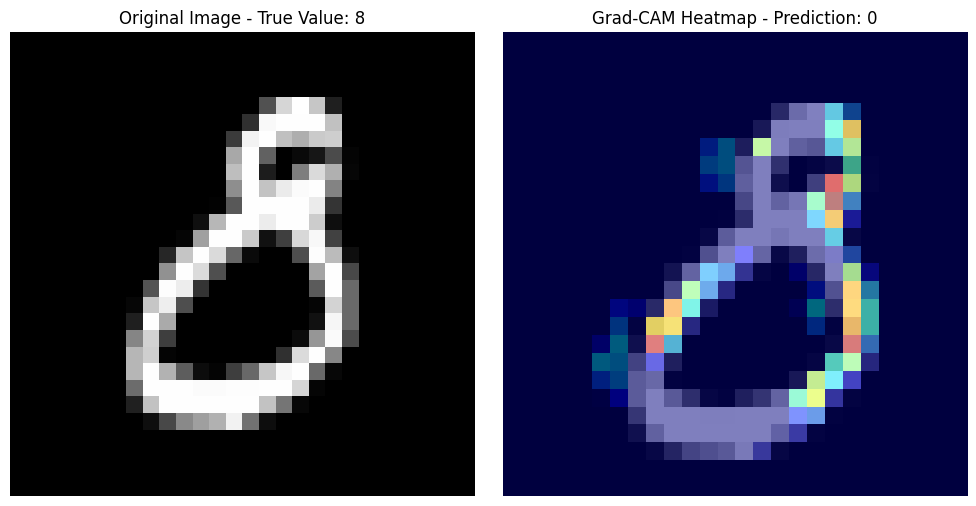

<Figure size 640x480 with 0 Axes>

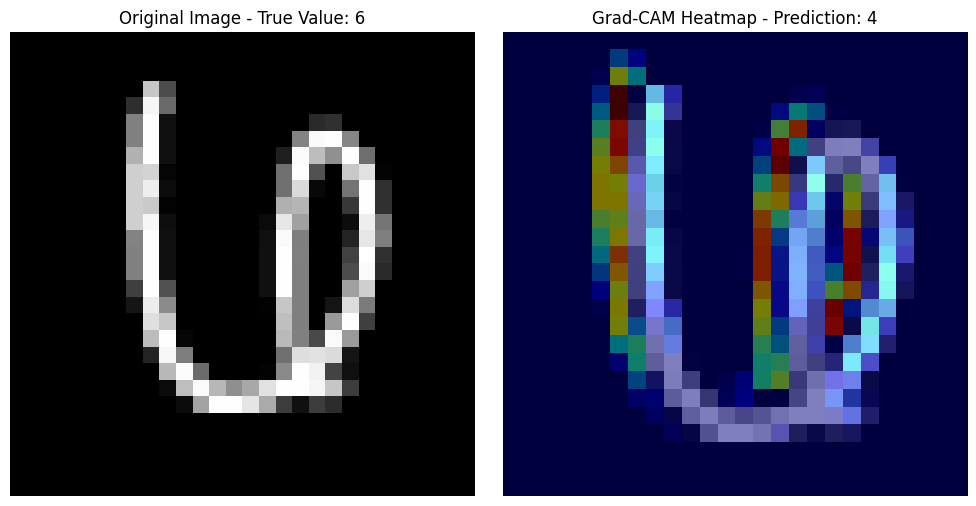

<Figure size 640x480 with 0 Axes>

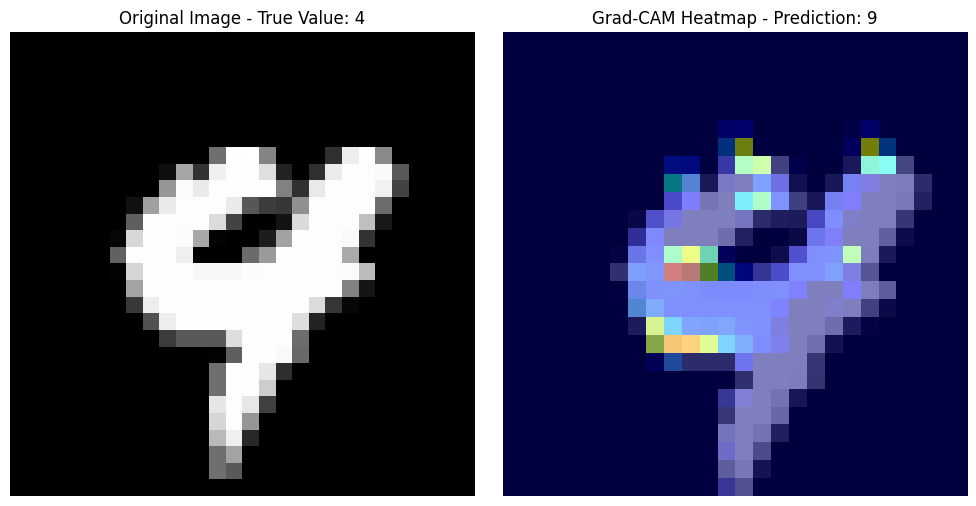

<Figure size 640x480 with 0 Axes>

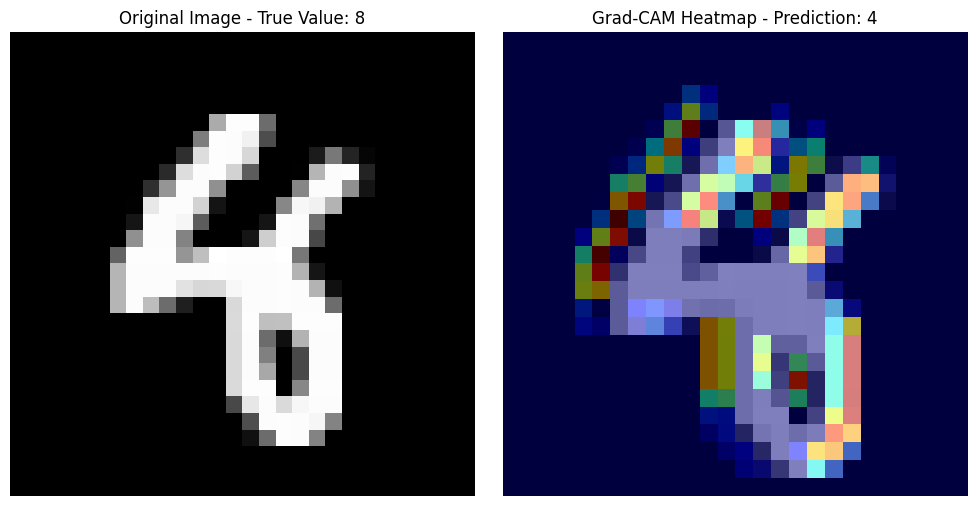

<Figure size 640x480 with 0 Axes>

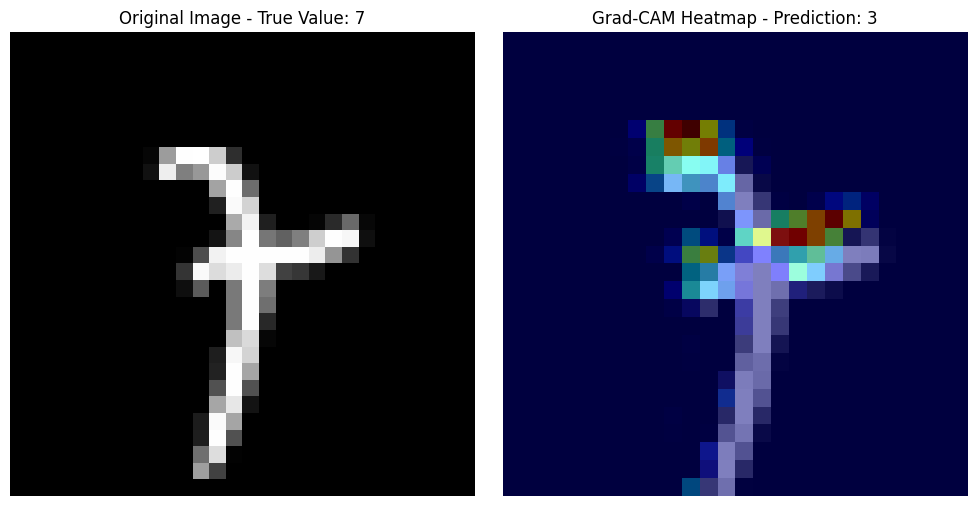

<Figure size 640x480 with 0 Axes>

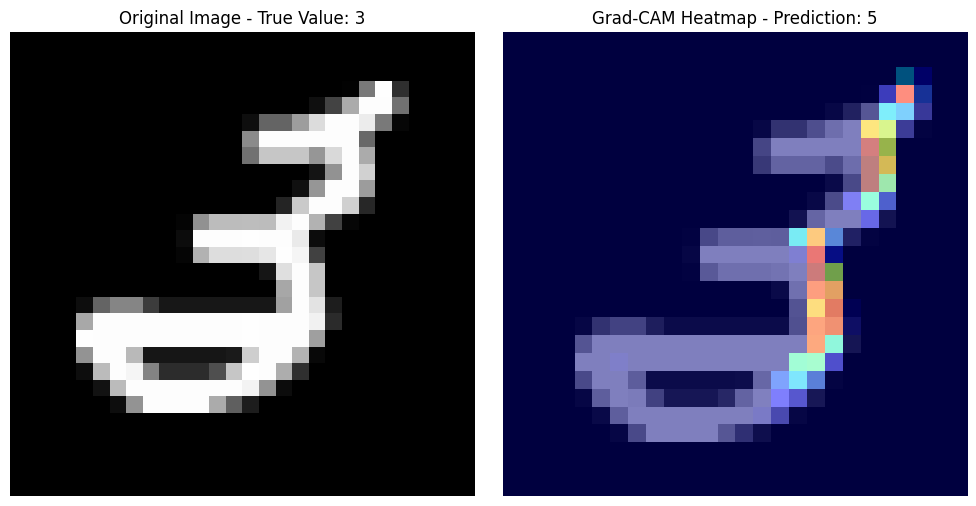

<Figure size 640x480 with 0 Axes>

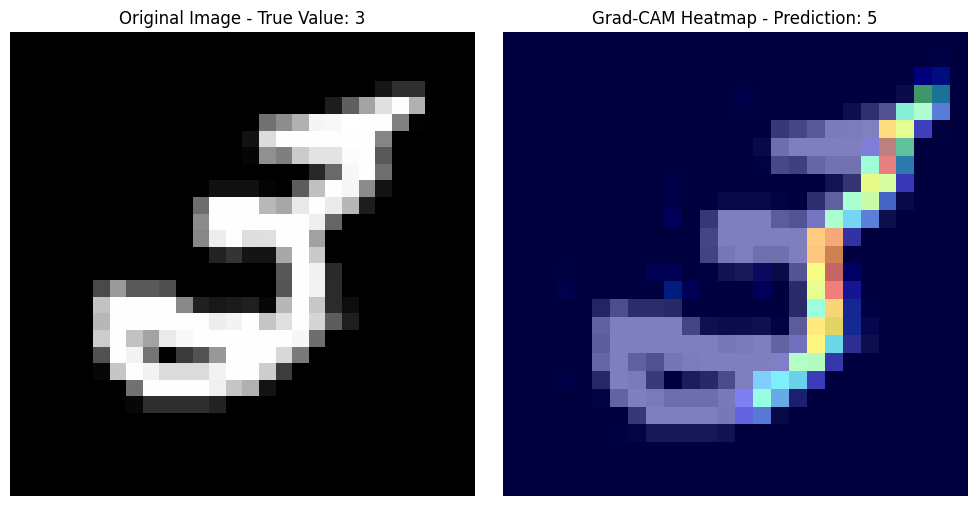

<Figure size 640x480 with 0 Axes>

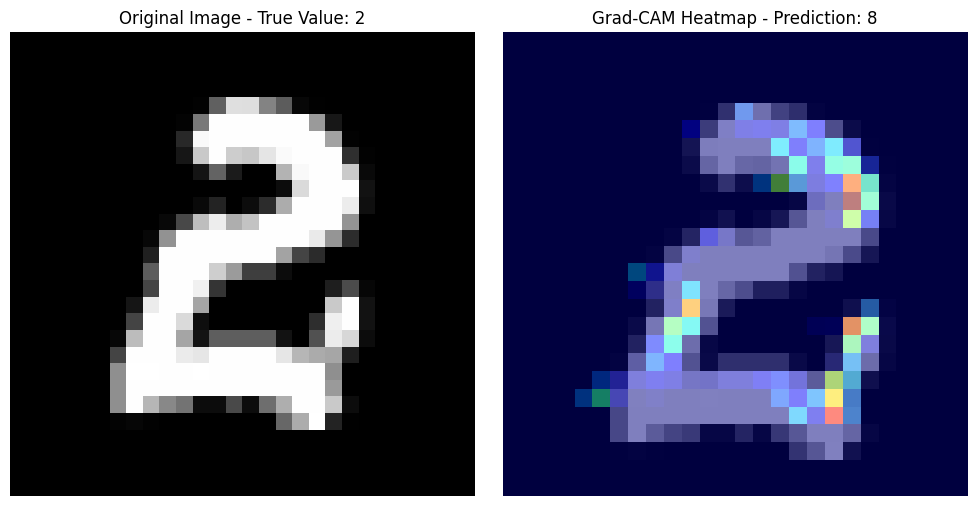

<Figure size 640x480 with 0 Axes>

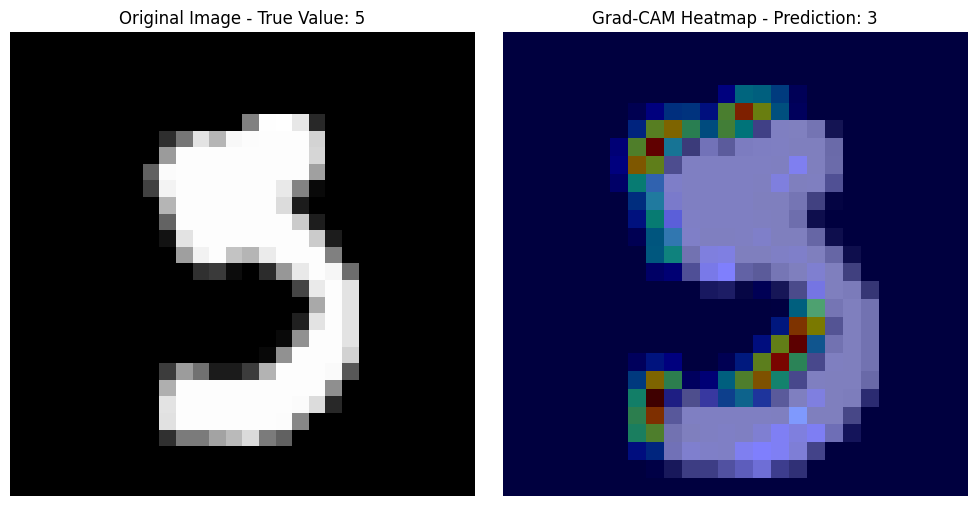

<Figure size 640x480 with 0 Axes>

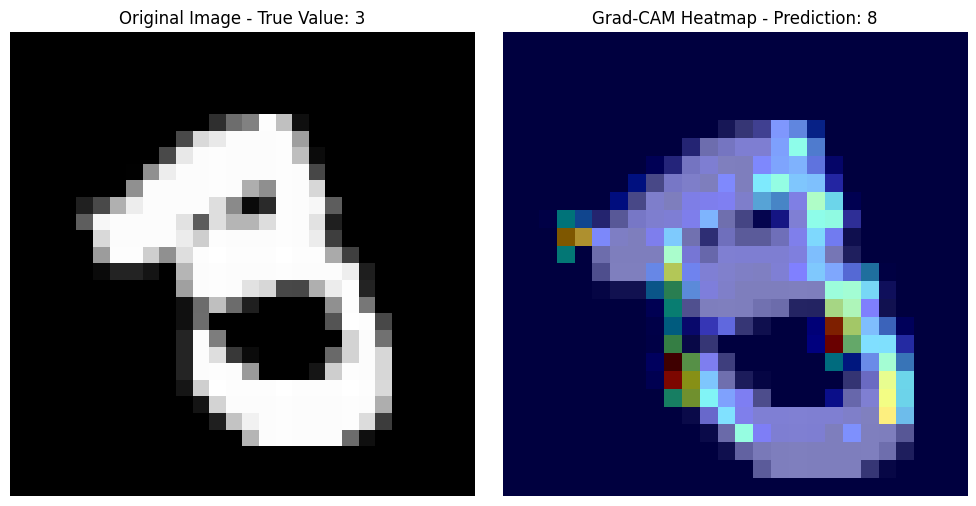

<Figure size 640x480 with 0 Axes>

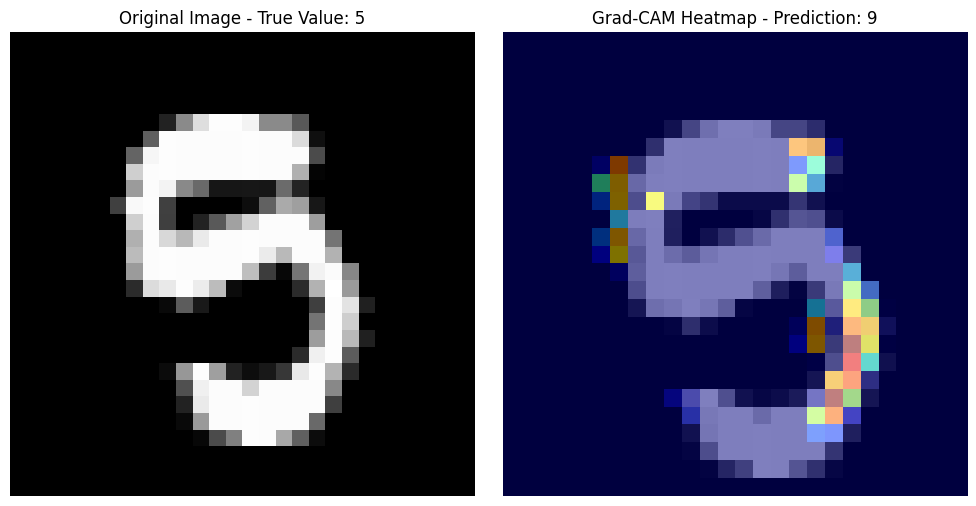

<Figure size 640x480 with 0 Axes>

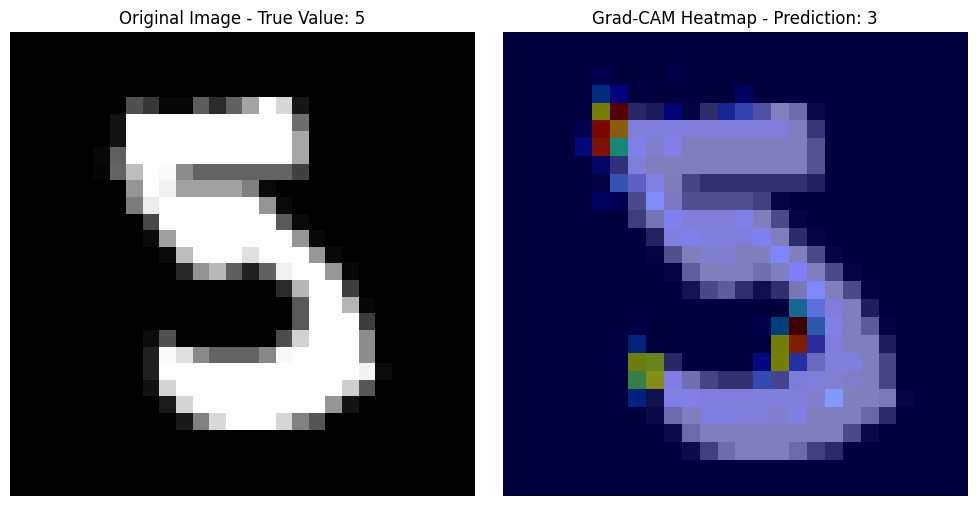

<Figure size 640x480 with 0 Axes>

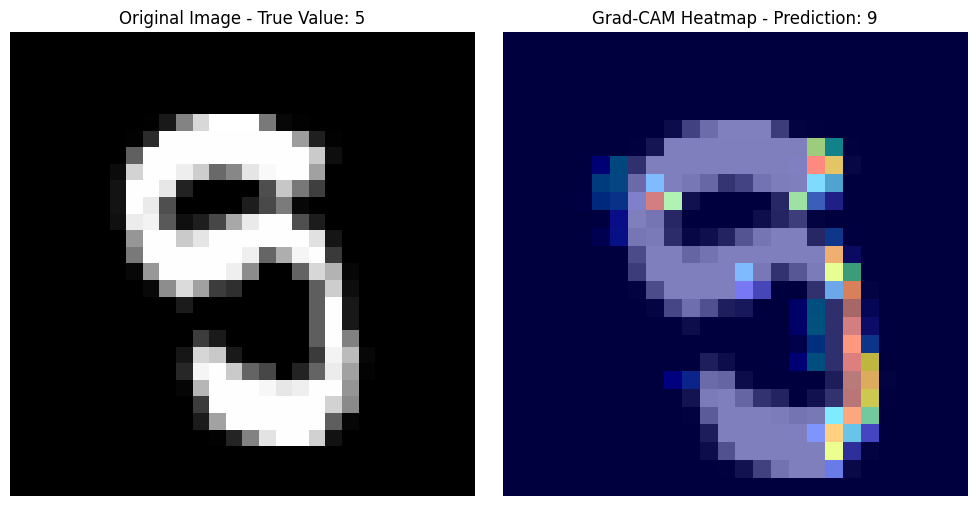

<Figure size 640x480 with 0 Axes>

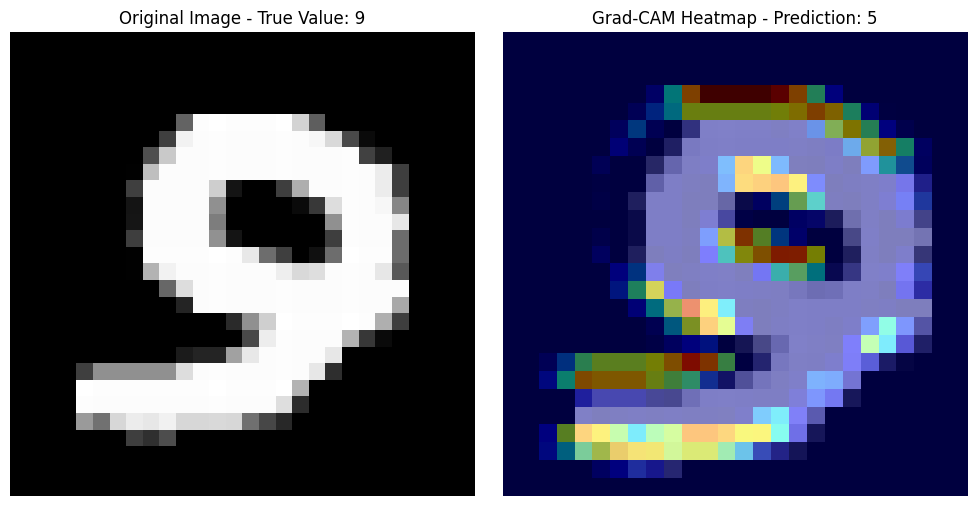

<Figure size 640x480 with 0 Axes>

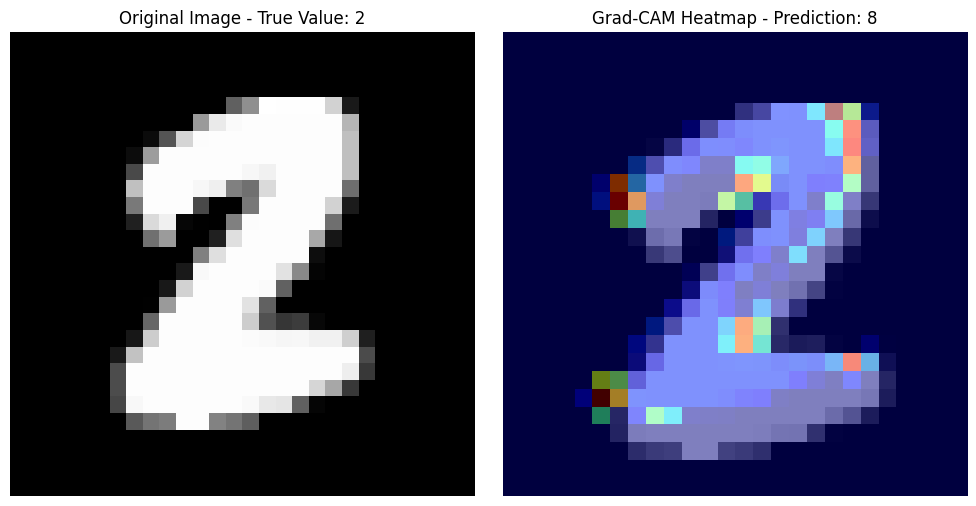

<Figure size 640x480 with 0 Axes>

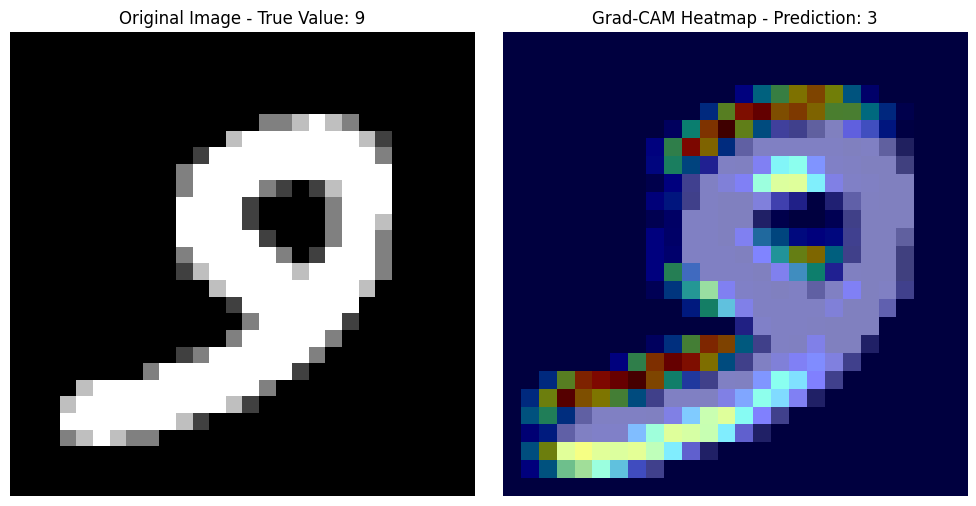

<Figure size 640x480 with 0 Axes>

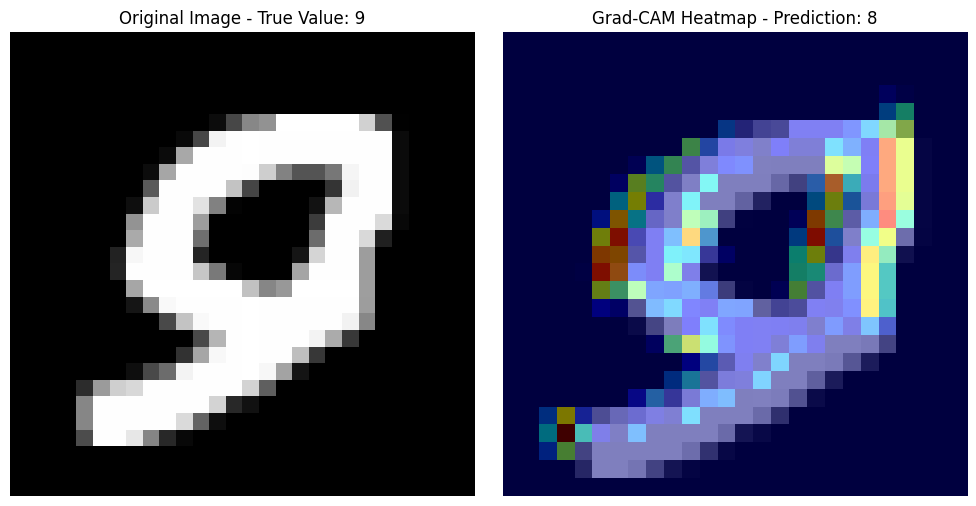

<Figure size 640x480 with 0 Axes>

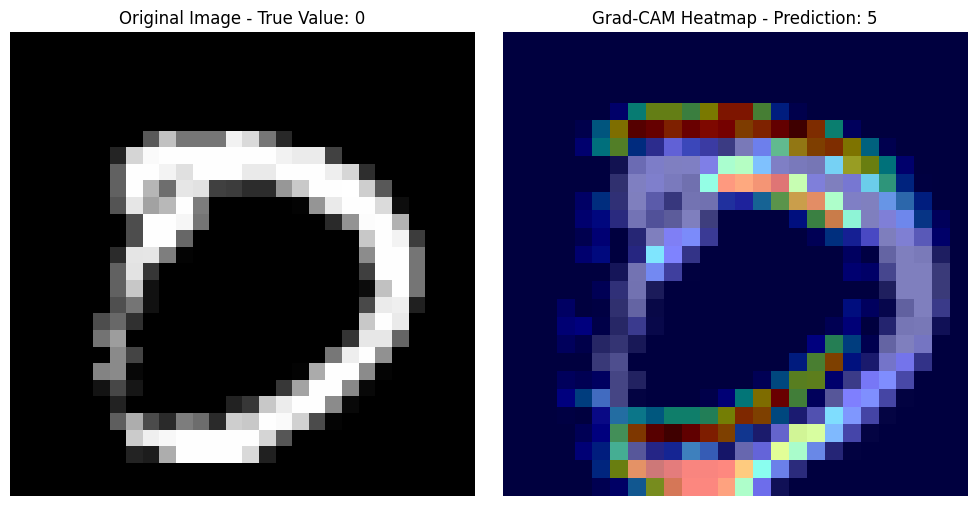

<Figure size 640x480 with 0 Axes>

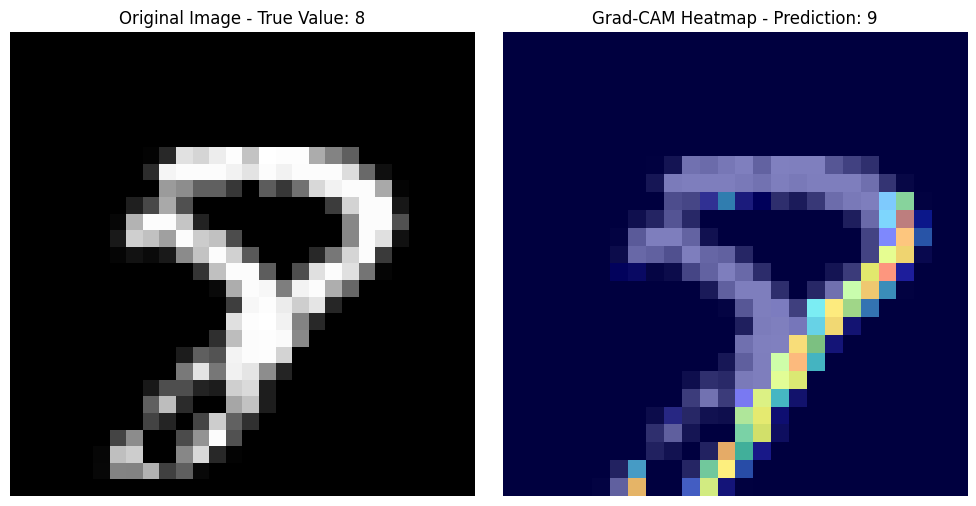

<Figure size 640x480 with 0 Axes>

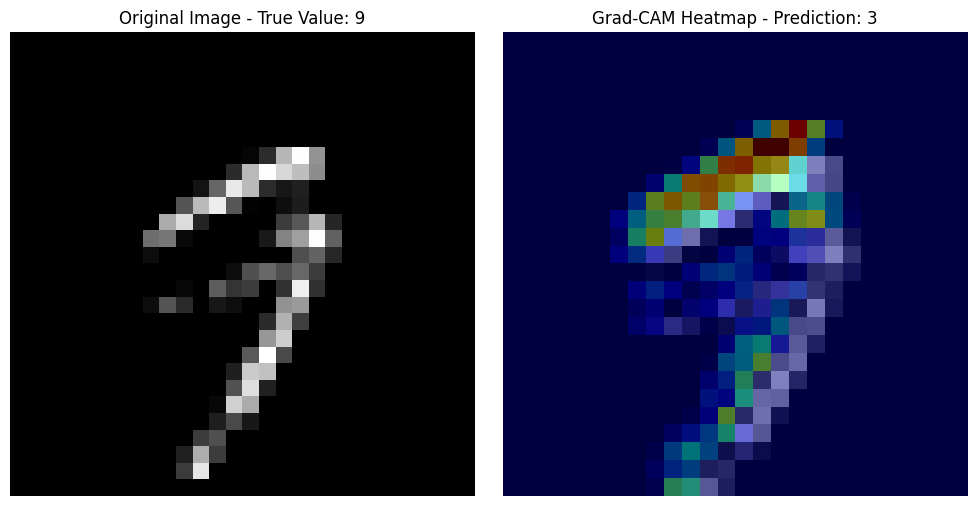

<Figure size 640x480 with 0 Axes>

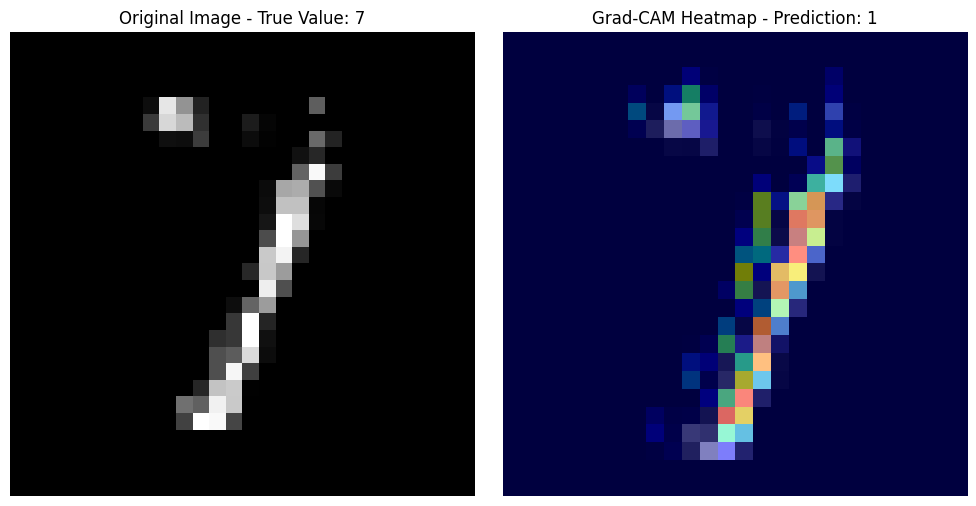

<Figure size 640x480 with 0 Axes>

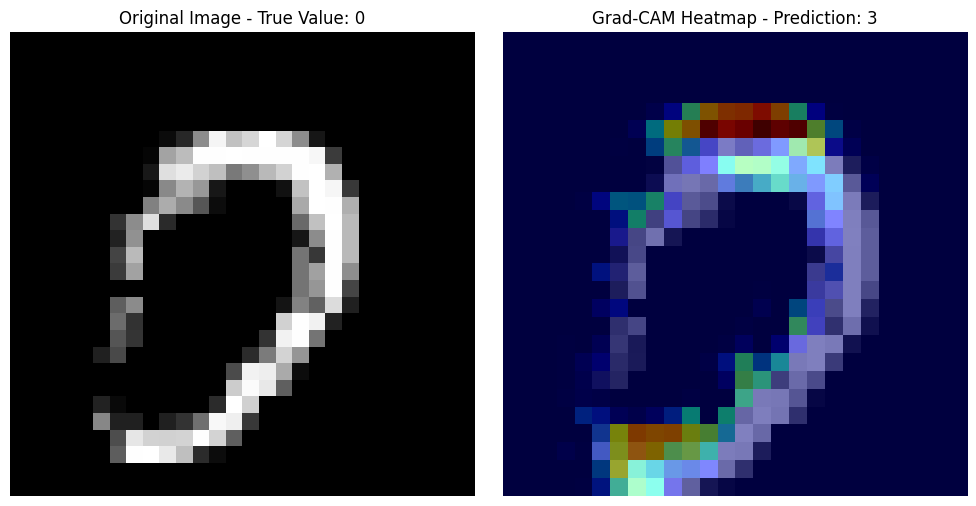

<Figure size 640x480 with 0 Axes>

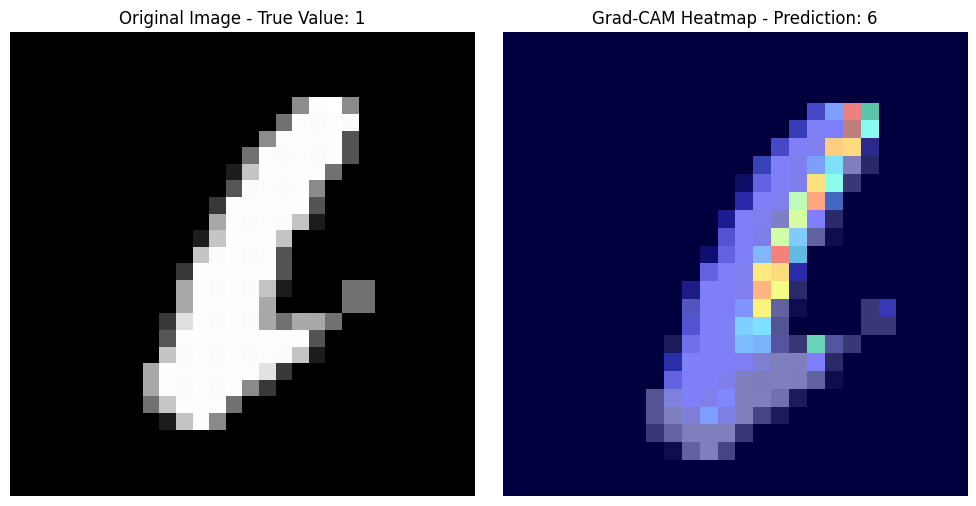

<Figure size 640x480 with 0 Axes>

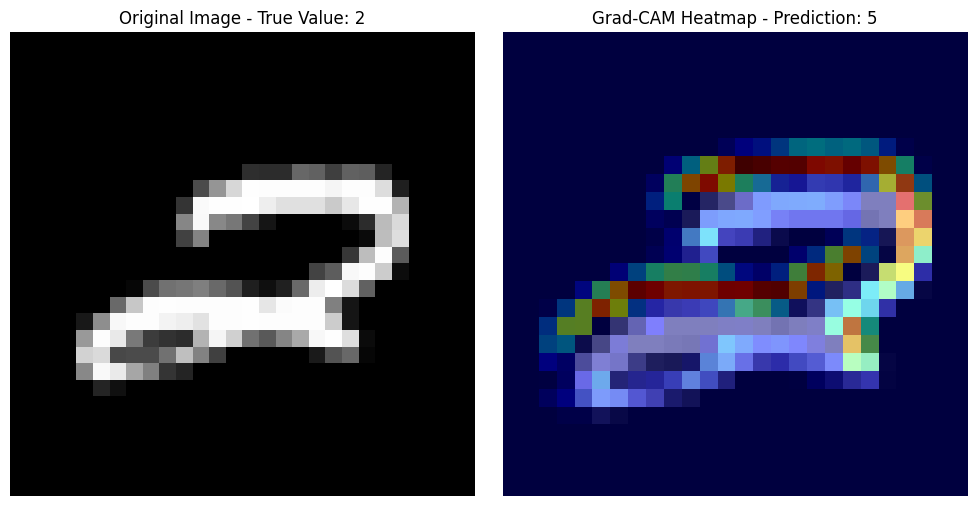

<Figure size 640x480 with 0 Axes>

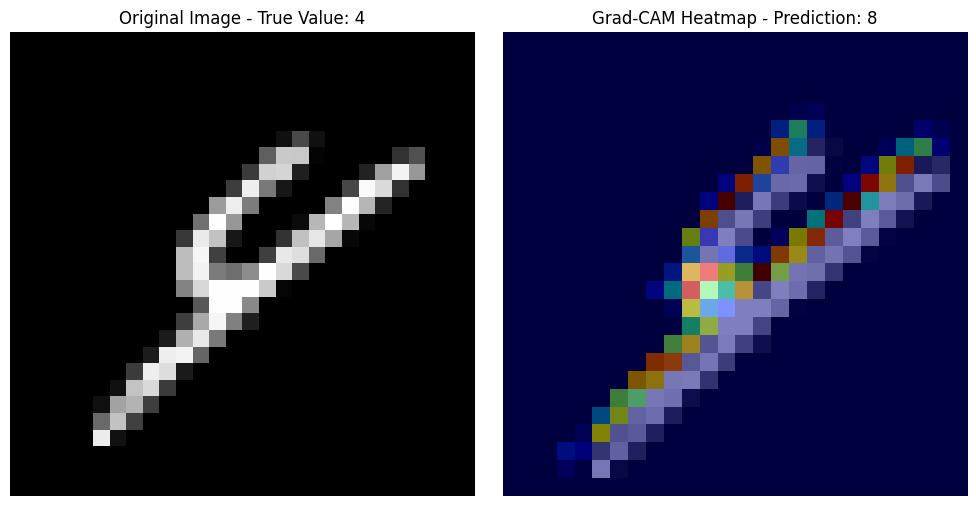

<Figure size 640x480 with 0 Axes>

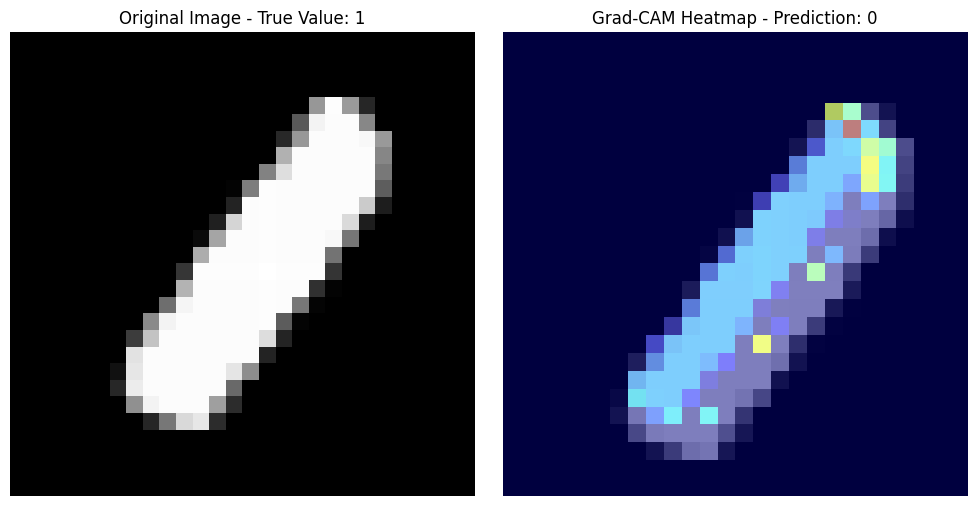

<Figure size 640x480 with 0 Axes>

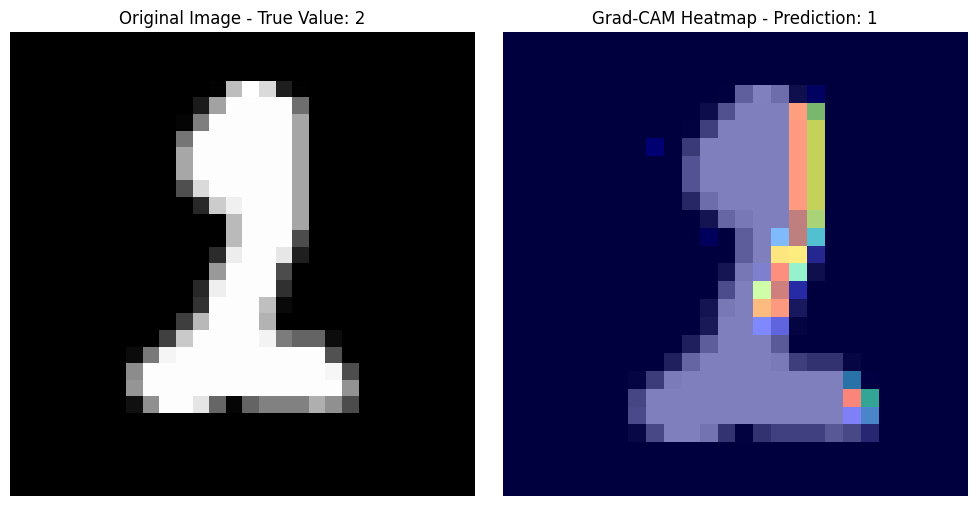

<Figure size 640x480 with 0 Axes>

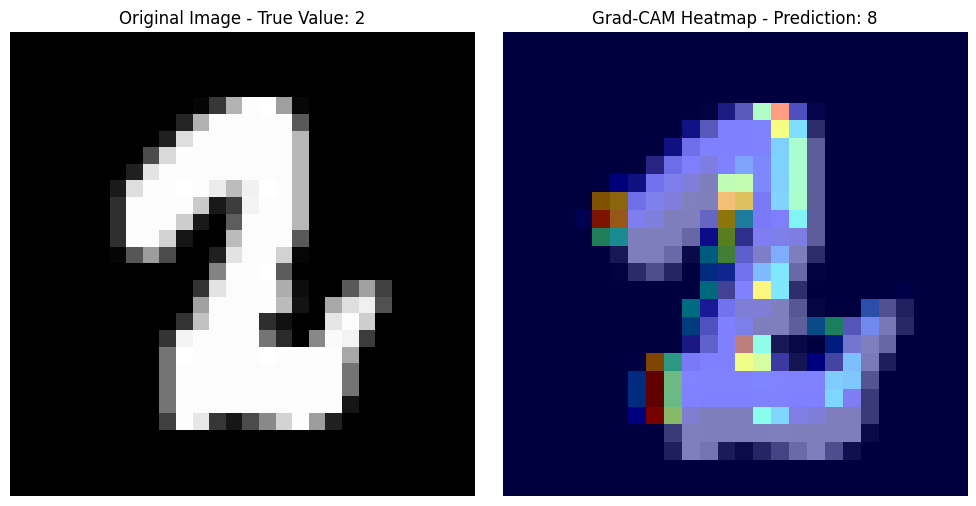

<Figure size 640x480 with 0 Axes>

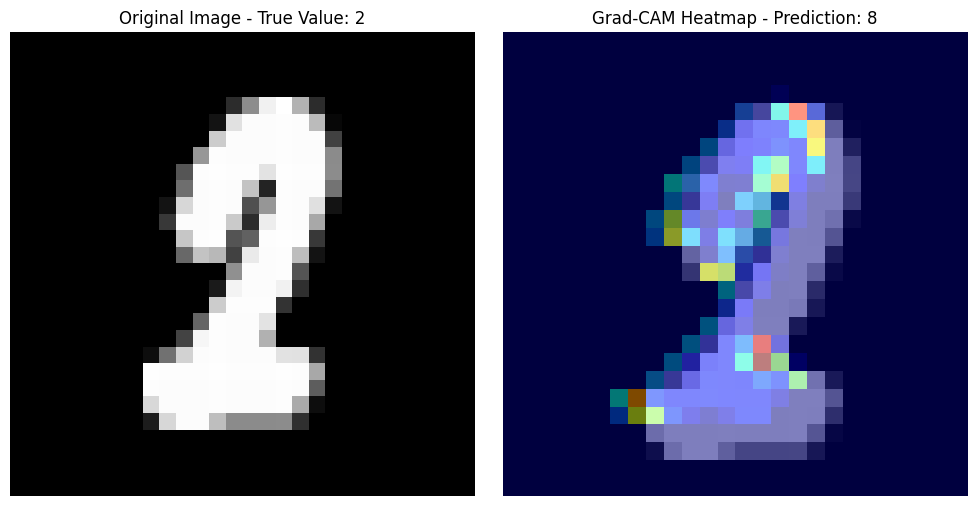

<Figure size 640x480 with 0 Axes>

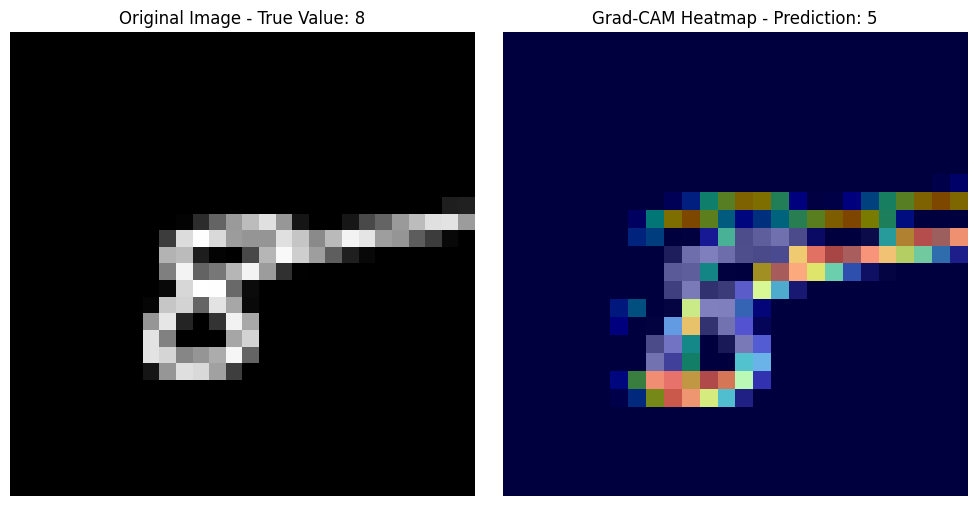

<Figure size 640x480 with 0 Axes>

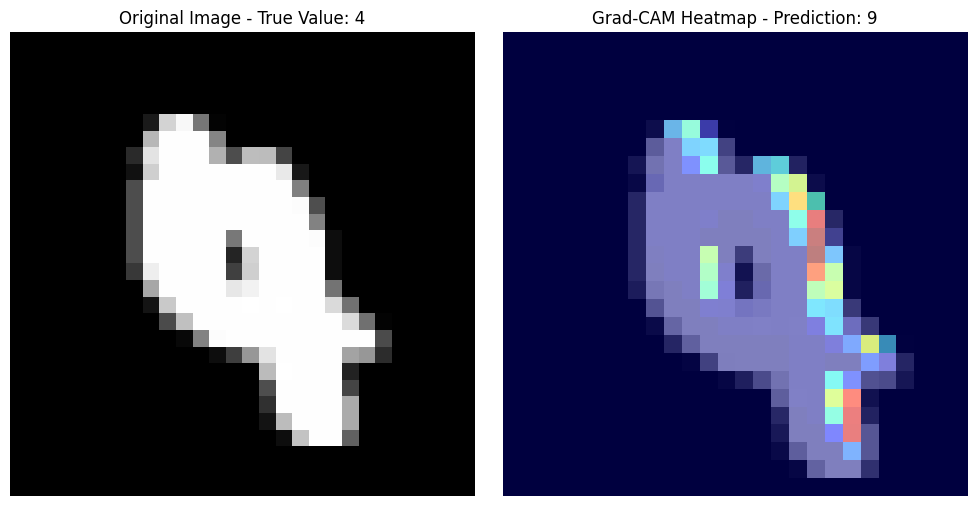

<Figure size 640x480 with 0 Axes>

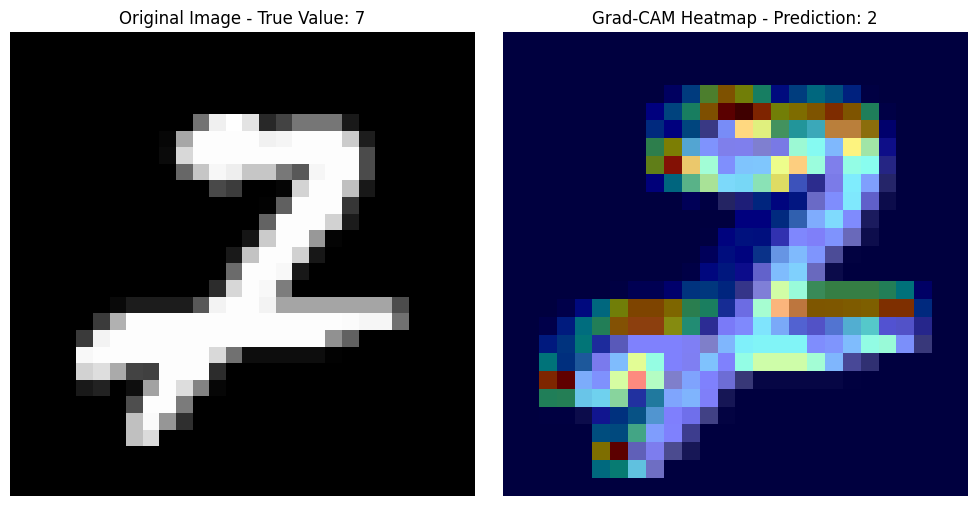

<Figure size 640x480 with 0 Axes>

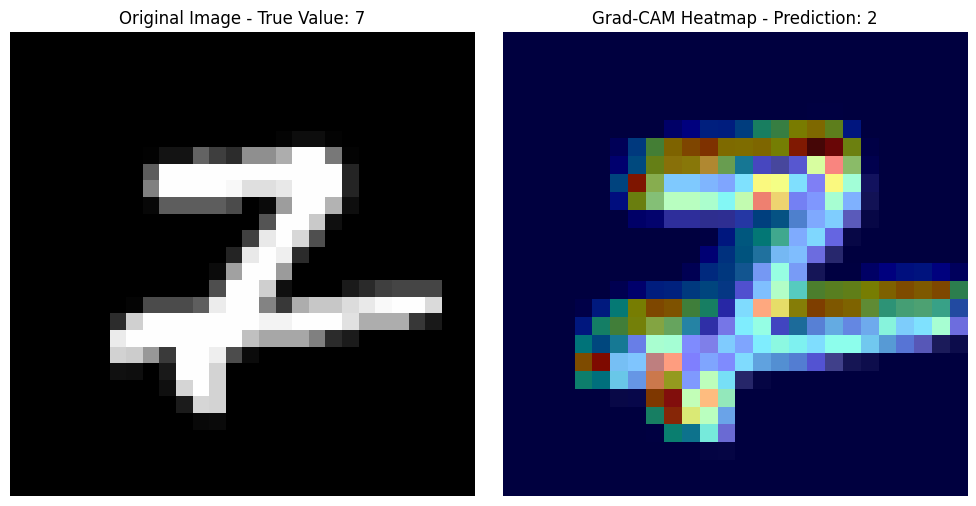

<Figure size 640x480 with 0 Axes>

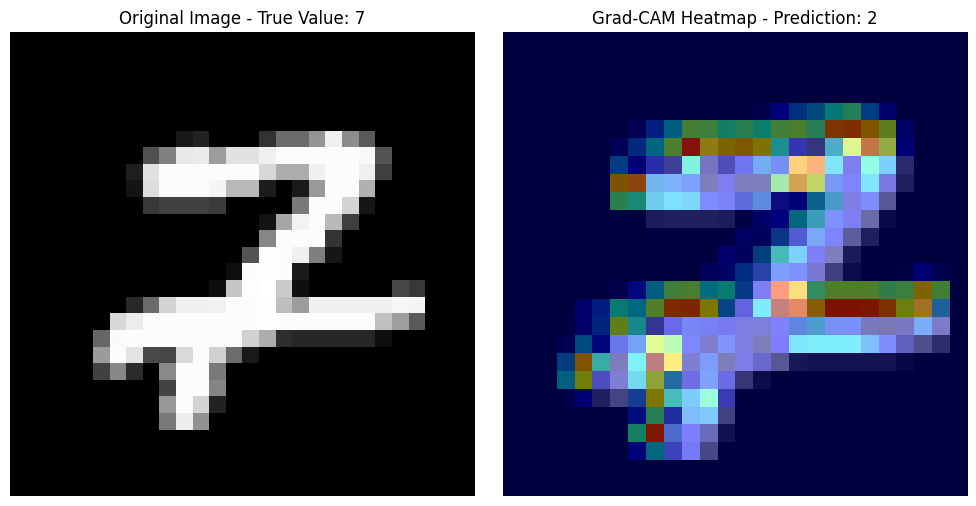

<Figure size 640x480 with 0 Axes>

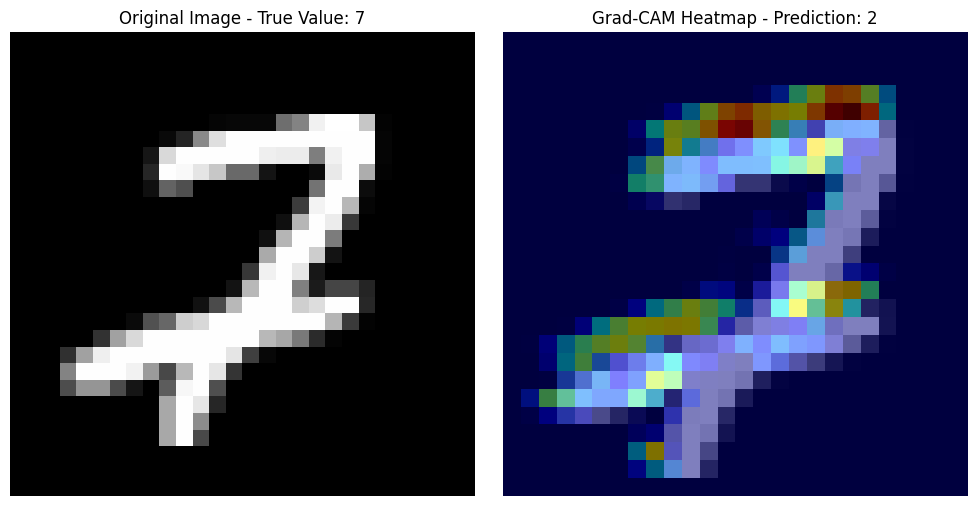

<Figure size 640x480 with 0 Axes>

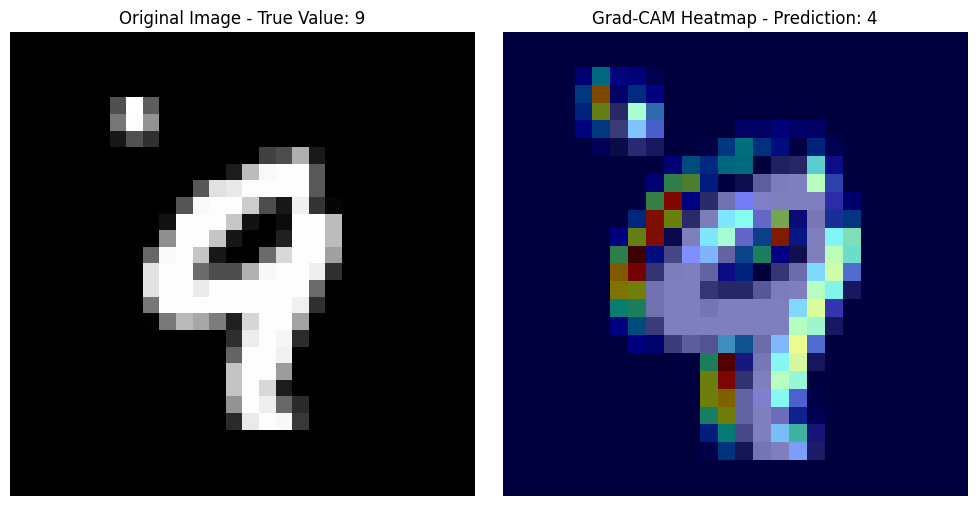

<Figure size 640x480 with 0 Axes>

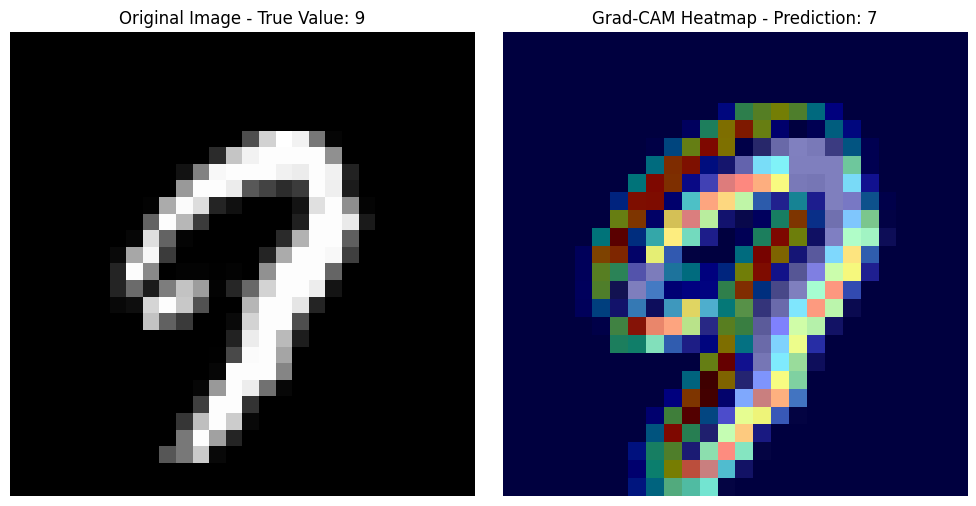

<Figure size 640x480 with 0 Axes>

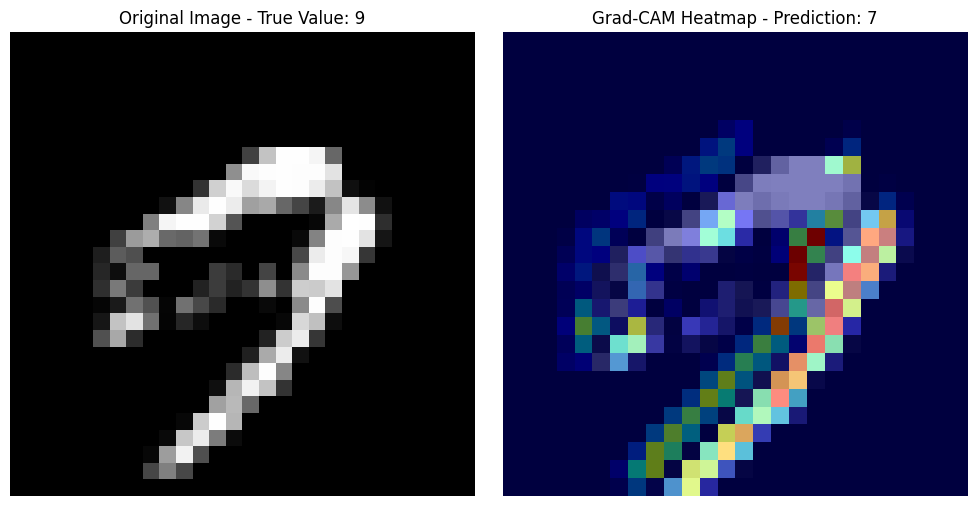

<Figure size 640x480 with 0 Axes>

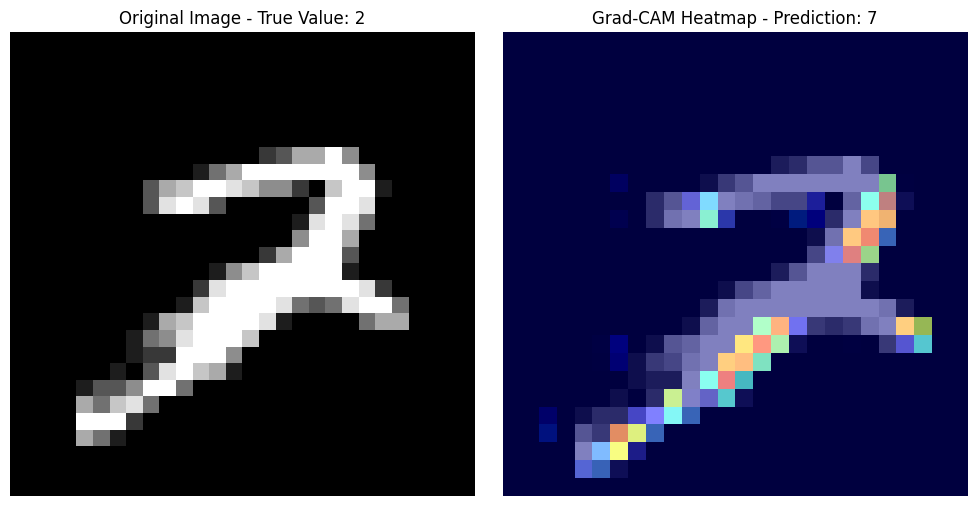

<Figure size 640x480 with 0 Axes>

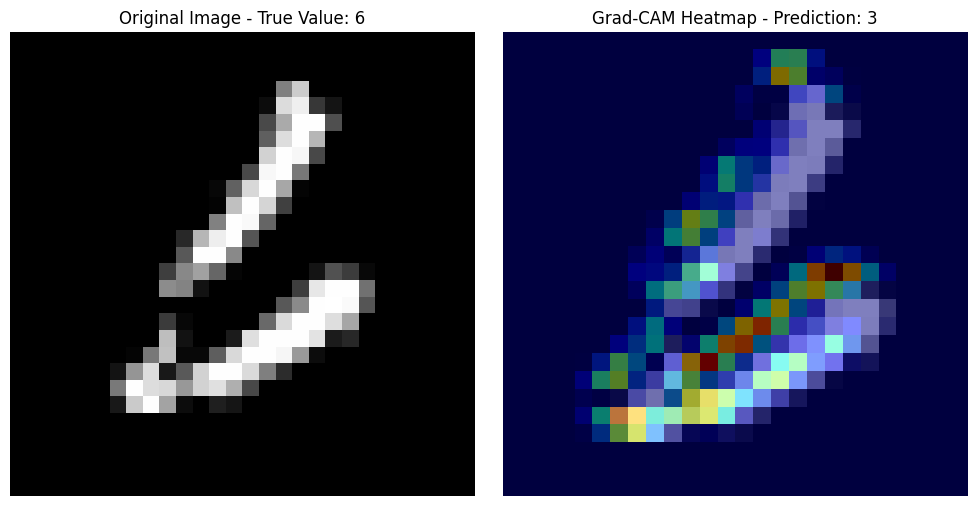

<Figure size 640x480 with 0 Axes>

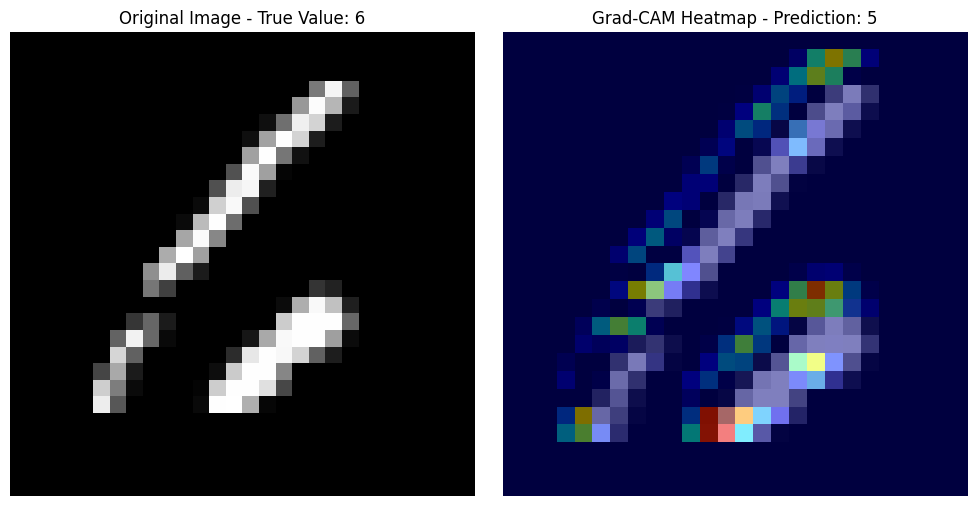

<Figure size 640x480 with 0 Axes>

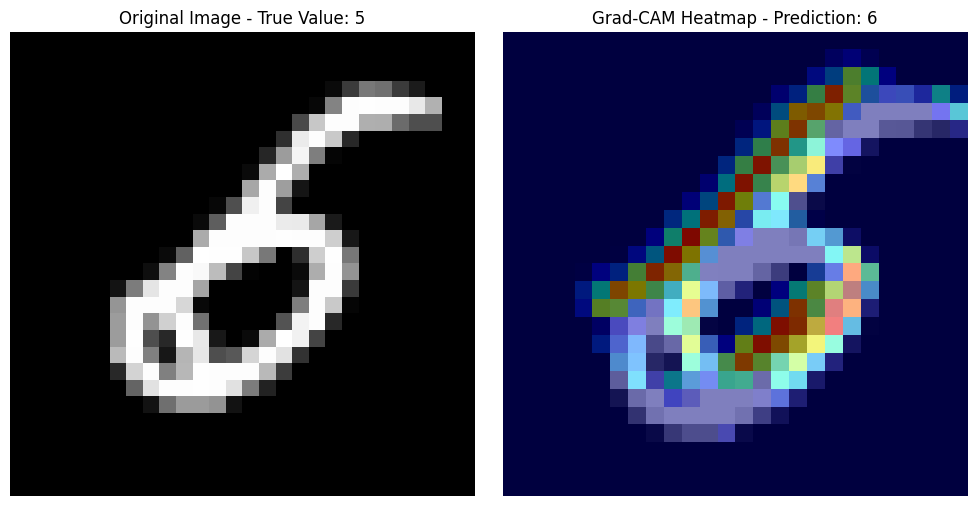

<Figure size 640x480 with 0 Axes>

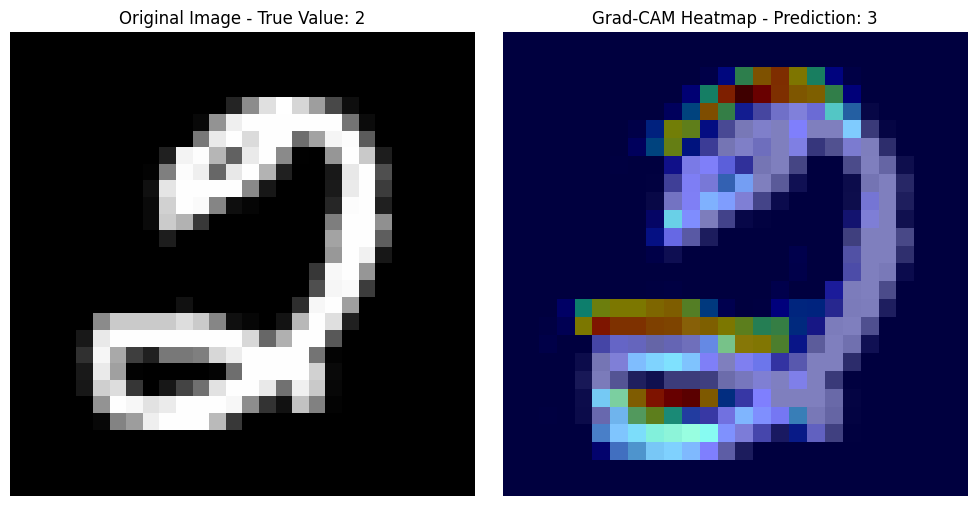

<Figure size 640x480 with 0 Axes>

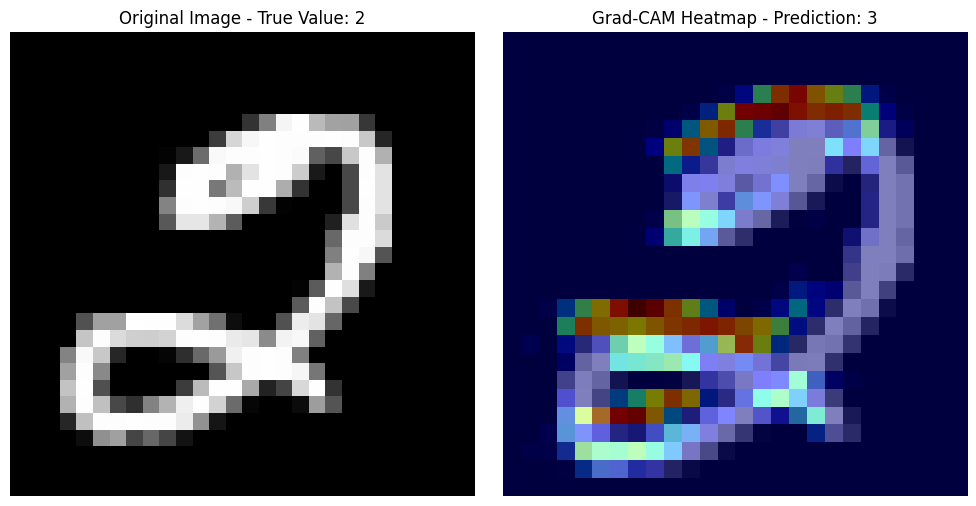

<Figure size 640x480 with 0 Axes>

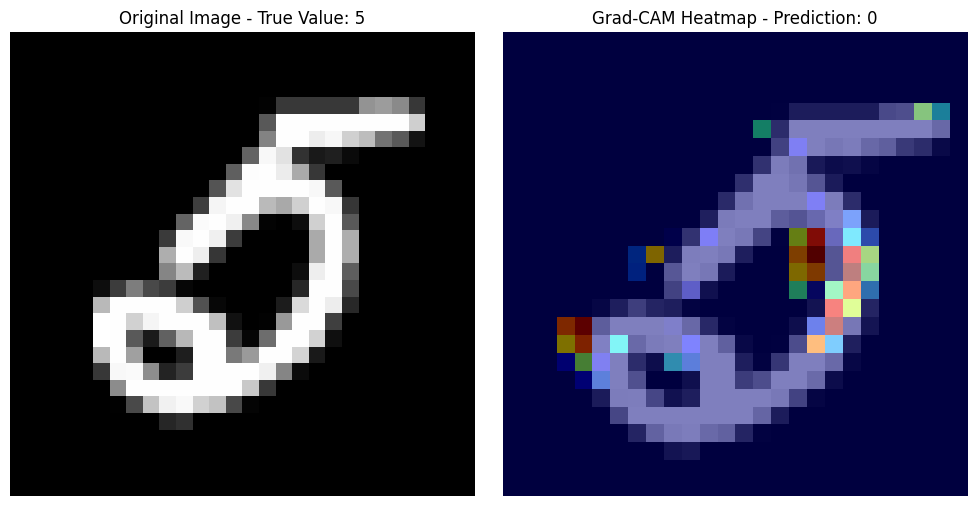

<Figure size 640x480 with 0 Axes>

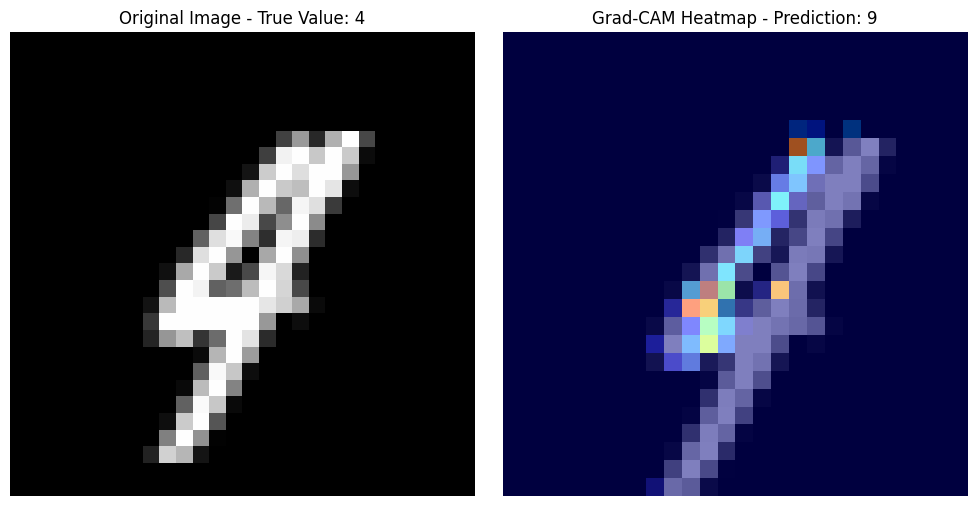

<Figure size 640x480 with 0 Axes>

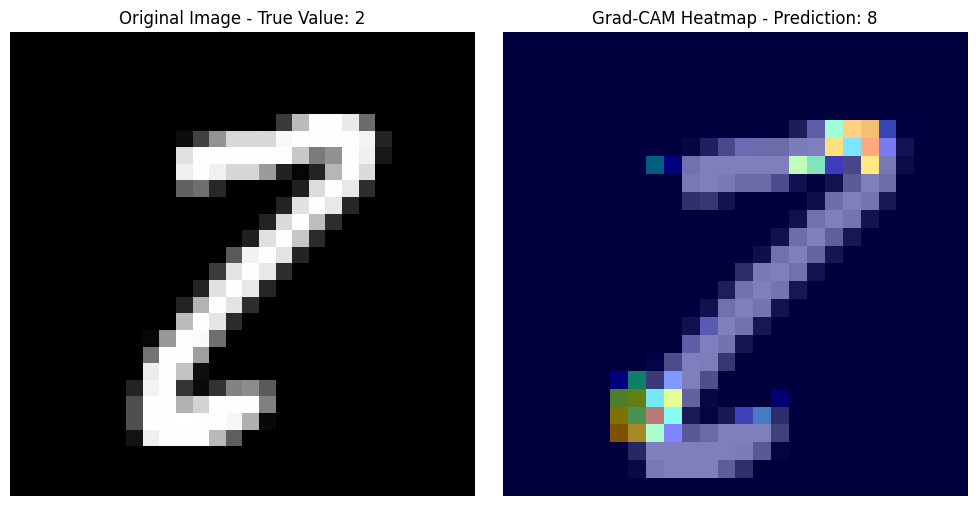

<Figure size 640x480 with 0 Axes>

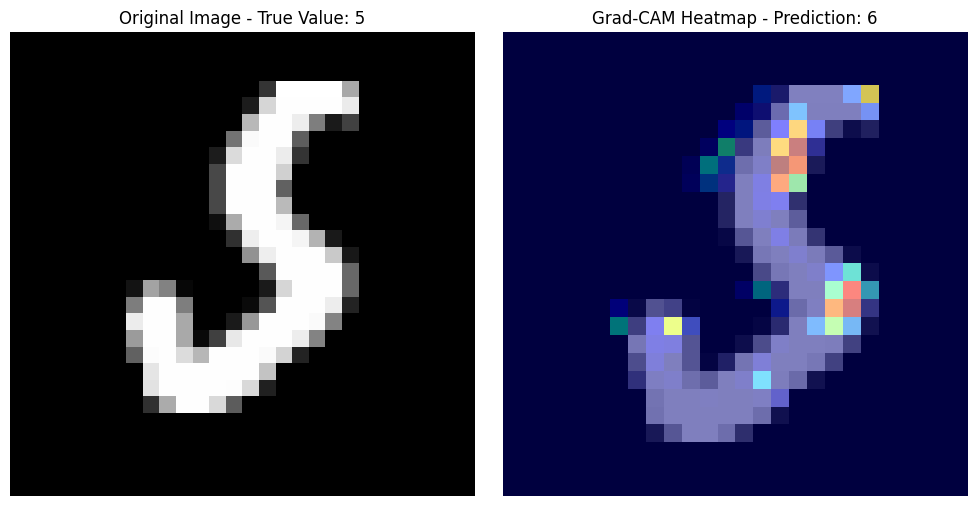

<Figure size 640x480 with 0 Axes>

In [108]:
for img_ind in error_inds:
    img_to_explain = X_test[img_ind]
    f = explain_image(img_to_explain,model,'conv2d')
    plt.show(f)
    plt.savefig(f'gradcam_error_ind_img_{img_ind}.png')